# Miller age

In [1]:
ood_seed = 12

In [2]:
num_ood = 1  # not functioning

In [3]:
obs_key = "age"

In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

(('Lung secretory cells', '15.0'), 595)

Removed datapoint: 595


In [10]:
adata

AnnData object with n_obs × n_vars = 6810 × 8192
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', 'age_continuous'
    uns: 'rank_genes_groups'
    obsm: 'Unintegrated', 'X_pca', 'harmony'

In [11]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"miller_ood_expression-seed-{ood_seed}_size-{num_ood}_obs-{obs_key}"
)

In [12]:
# vae = tardis.MyModel.load(dir_path, adata=adata)

In [13]:
(
    adata.obs["integration_donor"].nunique(),
    adata.obs["integration_biological_unit"].nunique(),
    adata.obs["integration_sample_status"].nunique(),
    adata.obs["integration_library_platform_coarse"].nunique(),
) 

(8, 1, 1, 1)

In [14]:
warmup_epoch_range = [6, 48]

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

tardis_loss_weight_1 = 100
tardis_loss_weight_2 = 10

disentenglement_targets_configurations=[
    dict(
        obs_key = obs_key,
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = True,
                weight = tardis_loss_weight_1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = tardis_loss_weight_1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
]


In [15]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)), 
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates=True,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key="cell_type",
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: tqxa2tbk
Name: jedi-carrier-478
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/tqxa2tbk
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240505_142612-tqxa2tbk/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `age` for `training` set. Number of elements in each group: 573,1856,2387,632
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `age` for `validation` set. Number of elements in each group: 134,473,618,137
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:03<37:19,  3.74s/it]

Epoch 1/600:   0%|          | 1/600 [00:03<37:19,  3.74s/it, v_num=bk_1, total_loss_train=1.21e+3, kl_local_train=12.1, tardis_age_0_train=34.3]

Epoch 2/600:   0%|          | 1/600 [00:03<37:19,  3.74s/it, v_num=bk_1, total_loss_train=1.21e+3, kl_local_train=12.1, tardis_age_0_train=34.3]

Epoch 2/600:   0%|          | 2/600 [00:07<35:59,  3.61s/it, v_num=bk_1, total_loss_train=1.21e+3, kl_local_train=12.1, tardis_age_0_train=34.3]

Epoch 2/600:   0%|          | 2/600 [00:07<35:59,  3.61s/it, v_num=bk_1, total_loss_train=1.06e+3, kl_local_train=36.3, tardis_age_0_train=34.7]

Epoch 3/600:   0%|          | 2/600 [00:07<35:59,  3.61s/it, v_num=bk_1, total_loss_train=1.06e+3, kl_local_train=36.3, tardis_age_0_train=34.7]

Epoch 3/600:   0%|          | 3/600 [00:10<35:35,  3.58s/it, v_num=bk_1, total_loss_train=1.06e+3, kl_local_train=36.3, tardis_age_0_train=34.7]

Epoch 3/600:   0%|          | 3/600 [00:10<35:35,  3.58s/it, v_num=bk_1, total_loss_train=1.01e+3, kl_local_train=40.3, tardis_age_0_train=33.8]

Epoch 4/600:   0%|          | 3/600 [00:10<35:35,  3.58s/it, v_num=bk_1, total_loss_train=1.01e+3, kl_local_train=40.3, tardis_age_0_train=33.8]

Epoch 4/600:   1%|          | 4/600 [00:14<35:23,  3.56s/it, v_num=bk_1, total_loss_train=1.01e+3, kl_local_train=40.3, tardis_age_0_train=33.8]

Epoch 4/600:   1%|          | 4/600 [00:14<35:23,  3.56s/it, v_num=bk_1, total_loss_train=994, kl_local_train=34.3, tardis_age_0_train=33.6]    

Epoch 5/600:   1%|          | 4/600 [00:14<35:23,  3.56s/it, v_num=bk_1, total_loss_train=994, kl_local_train=34.3, tardis_age_0_train=33.6]

Epoch 5/600:   1%|          | 5/600 [00:17<35:06,  3.54s/it, v_num=bk_1, total_loss_train=994, kl_local_train=34.3, tardis_age_0_train=33.6]

Epoch 5/600:   1%|          | 5/600 [00:17<35:06,  3.54s/it, v_num=bk_1, total_loss_train=962, kl_local_train=42.4, tardis_age_0_train=33.9]

Epoch 6/600:   1%|          | 5/600 [00:17<35:06,  3.54s/it, v_num=bk_1, total_loss_train=962, kl_local_train=42.4, tardis_age_0_train=33.9]

Epoch 6/600:   1%|          | 6/600 [00:21<35:07,  3.55s/it, v_num=bk_1, total_loss_train=962, kl_local_train=42.4, tardis_age_0_train=33.9]

Epoch 6/600:   1%|          | 6/600 [00:21<35:07,  3.55s/it, v_num=bk_1, total_loss_train=937, kl_local_train=46.2, tardis_age_0_train=34]  

Epoch 7/600:   1%|          | 6/600 [00:21<35:07,  3.55s/it, v_num=bk_1, total_loss_train=937, kl_local_train=46.2, tardis_age_0_train=34]

Epoch 7/600:   1%|          | 7/600 [00:24<34:51,  3.53s/it, v_num=bk_1, total_loss_train=937, kl_local_train=46.2, tardis_age_0_train=34]

Epoch 7/600:   1%|          | 7/600 [00:24<34:51,  3.53s/it, v_num=bk_1, total_loss_train=922, kl_local_train=47.1, tardis_age_0_train=34.2]

Epoch 8/600:   1%|          | 7/600 [00:24<34:51,  3.53s/it, v_num=bk_1, total_loss_train=922, kl_local_train=47.1, tardis_age_0_train=34.2]

Epoch 8/600:   1%|▏         | 8/600 [00:28<34:44,  3.52s/it, v_num=bk_1, total_loss_train=922, kl_local_train=47.1, tardis_age_0_train=34.2]

Epoch 8/600:   1%|▏         | 8/600 [00:28<34:44,  3.52s/it, v_num=bk_1, total_loss_train=913, kl_local_train=44.4, tardis_age_0_train=34.5]

Epoch 9/600:   1%|▏         | 8/600 [00:28<34:44,  3.52s/it, v_num=bk_1, total_loss_train=913, kl_local_train=44.4, tardis_age_0_train=34.5]

Epoch 9/600:   2%|▏         | 9/600 [00:31<34:38,  3.52s/it, v_num=bk_1, total_loss_train=913, kl_local_train=44.4, tardis_age_0_train=34.5]

Epoch 9/600:   2%|▏         | 9/600 [00:31<34:38,  3.52s/it, v_num=bk_1, total_loss_train=907, kl_local_train=43.5, tardis_age_0_train=34.9]

Epoch 10/600:   2%|▏         | 9/600 [00:31<34:38,  3.52s/it, v_num=bk_1, total_loss_train=907, kl_local_train=43.5, tardis_age_0_train=34.9]

Epoch 10/600:   2%|▏         | 10/600 [00:35<34:33,  3.51s/it, v_num=bk_1, total_loss_train=907, kl_local_train=43.5, tardis_age_0_train=34.9]

Epoch 10/600:   2%|▏         | 10/600 [00:35<34:33,  3.51s/it, v_num=bk_1, total_loss_train=903, kl_local_train=42.9, tardis_age_0_train=34.3]

Epoch 11/600:   2%|▏         | 10/600 [00:35<34:33,  3.51s/it, v_num=bk_1, total_loss_train=903, kl_local_train=42.9, tardis_age_0_train=34.3]

Epoch 11/600:   2%|▏         | 11/600 [00:38<34:22,  3.50s/it, v_num=bk_1, total_loss_train=903, kl_local_train=42.9, tardis_age_0_train=34.3]

Epoch 11/600:   2%|▏         | 11/600 [00:38<34:22,  3.50s/it, v_num=bk_1, total_loss_train=899, kl_local_train=44.9, tardis_age_0_train=33.4]

Epoch 12/600:   2%|▏         | 11/600 [00:38<34:22,  3.50s/it, v_num=bk_1, total_loss_train=899, kl_local_train=44.9, tardis_age_0_train=33.4]

Epoch 12/600:   2%|▏         | 12/600 [00:42<34:26,  3.51s/it, v_num=bk_1, total_loss_train=899, kl_local_train=44.9, tardis_age_0_train=33.4]

Epoch 12/600:   2%|▏         | 12/600 [00:42<34:26,  3.51s/it, v_num=bk_1, total_loss_train=895, kl_local_train=48.8, tardis_age_0_train=32.7]

Epoch 13/600:   2%|▏         | 12/600 [00:42<34:26,  3.51s/it, v_num=bk_1, total_loss_train=895, kl_local_train=48.8, tardis_age_0_train=32.7]

Epoch 13/600:   2%|▏         | 13/600 [00:45<34:25,  3.52s/it, v_num=bk_1, total_loss_train=895, kl_local_train=48.8, tardis_age_0_train=32.7]

Epoch 13/600:   2%|▏         | 13/600 [00:45<34:25,  3.52s/it, v_num=bk_1, total_loss_train=892, kl_local_train=53.7, tardis_age_0_train=32.2]

Epoch 14/600:   2%|▏         | 13/600 [00:45<34:25,  3.52s/it, v_num=bk_1, total_loss_train=892, kl_local_train=53.7, tardis_age_0_train=32.2]

Epoch 14/600:   2%|▏         | 14/600 [00:49<34:25,  3.52s/it, v_num=bk_1, total_loss_train=892, kl_local_train=53.7, tardis_age_0_train=32.2]

Epoch 14/600:   2%|▏         | 14/600 [00:49<34:25,  3.52s/it, v_num=bk_1, total_loss_train=890, kl_local_train=58.1, tardis_age_0_train=31.6]

Epoch 15/600:   2%|▏         | 14/600 [00:49<34:25,  3.52s/it, v_num=bk_1, total_loss_train=890, kl_local_train=58.1, tardis_age_0_train=31.6]

Epoch 15/600:   2%|▎         | 15/600 [00:52<34:10,  3.50s/it, v_num=bk_1, total_loss_train=890, kl_local_train=58.1, tardis_age_0_train=31.6]

Epoch 15/600:   2%|▎         | 15/600 [00:52<34:10,  3.50s/it, v_num=bk_1, total_loss_train=887, kl_local_train=63.9, tardis_age_0_train=31]  

Epoch 16/600:   2%|▎         | 15/600 [00:52<34:10,  3.50s/it, v_num=bk_1, total_loss_train=887, kl_local_train=63.9, tardis_age_0_train=31]

Epoch 16/600:   3%|▎         | 16/600 [00:56<34:05,  3.50s/it, v_num=bk_1, total_loss_train=887, kl_local_train=63.9, tardis_age_0_train=31]

Epoch 16/600:   3%|▎         | 16/600 [00:56<34:05,  3.50s/it, v_num=bk_1, total_loss_train=886, kl_local_train=66.1, tardis_age_0_train=30.3]

Epoch 17/600:   3%|▎         | 16/600 [00:56<34:05,  3.50s/it, v_num=bk_1, total_loss_train=886, kl_local_train=66.1, tardis_age_0_train=30.3]

Epoch 17/600:   3%|▎         | 17/600 [00:59<34:04,  3.51s/it, v_num=bk_1, total_loss_train=886, kl_local_train=66.1, tardis_age_0_train=30.3]

Epoch 17/600:   3%|▎         | 17/600 [00:59<34:04,  3.51s/it, v_num=bk_1, total_loss_train=885, kl_local_train=69.4, tardis_age_0_train=30.2]

Epoch 18/600:   3%|▎         | 17/600 [00:59<34:04,  3.51s/it, v_num=bk_1, total_loss_train=885, kl_local_train=69.4, tardis_age_0_train=30.2]

Epoch 18/600:   3%|▎         | 18/600 [01:03<34:03,  3.51s/it, v_num=bk_1, total_loss_train=885, kl_local_train=69.4, tardis_age_0_train=30.2]

Epoch 18/600:   3%|▎         | 18/600 [01:03<34:03,  3.51s/it, v_num=bk_1, total_loss_train=884, kl_local_train=72.2, tardis_age_0_train=28.6]

Epoch 19/600:   3%|▎         | 18/600 [01:03<34:03,  3.51s/it, v_num=bk_1, total_loss_train=884, kl_local_train=72.2, tardis_age_0_train=28.6]

Epoch 19/600:   3%|▎         | 19/600 [01:06<33:57,  3.51s/it, v_num=bk_1, total_loss_train=884, kl_local_train=72.2, tardis_age_0_train=28.6]

Epoch 19/600:   3%|▎         | 19/600 [01:06<33:57,  3.51s/it, v_num=bk_1, total_loss_train=883, kl_local_train=74.5, tardis_age_0_train=27.1]

Epoch 20/600:   3%|▎         | 19/600 [01:06<33:57,  3.51s/it, v_num=bk_1, total_loss_train=883, kl_local_train=74.5, tardis_age_0_train=27.1]

Epoch 20/600:   3%|▎         | 20/600 [01:10<33:42,  3.49s/it, v_num=bk_1, total_loss_train=883, kl_local_train=74.5, tardis_age_0_train=27.1]

Epoch 20/600:   3%|▎         | 20/600 [01:10<33:42,  3.49s/it, v_num=bk_1, total_loss_train=881, kl_local_train=77.5, tardis_age_0_train=22.9]

Epoch 21/600:   3%|▎         | 20/600 [01:10<33:42,  3.49s/it, v_num=bk_1, total_loss_train=881, kl_local_train=77.5, tardis_age_0_train=22.9]

Epoch 21/600:   4%|▎         | 21/600 [01:13<33:39,  3.49s/it, v_num=bk_1, total_loss_train=881, kl_local_train=77.5, tardis_age_0_train=22.9]

Epoch 21/600:   4%|▎         | 21/600 [01:13<33:39,  3.49s/it, v_num=bk_1, total_loss_train=880, kl_local_train=82.8, tardis_age_0_train=19.2]

Epoch 22/600:   4%|▎         | 21/600 [01:13<33:39,  3.49s/it, v_num=bk_1, total_loss_train=880, kl_local_train=82.8, tardis_age_0_train=19.2]

Epoch 22/600:   4%|▎         | 22/600 [01:17<33:35,  3.49s/it, v_num=bk_1, total_loss_train=880, kl_local_train=82.8, tardis_age_0_train=19.2]

Epoch 22/600:   4%|▎         | 22/600 [01:17<33:35,  3.49s/it, v_num=bk_1, total_loss_train=879, kl_local_train=92.2, tardis_age_0_train=16.9]

Epoch 23/600:   4%|▎         | 22/600 [01:17<33:35,  3.49s/it, v_num=bk_1, total_loss_train=879, kl_local_train=92.2, tardis_age_0_train=16.9]

Epoch 23/600:   4%|▍         | 23/600 [01:20<33:33,  3.49s/it, v_num=bk_1, total_loss_train=879, kl_local_train=92.2, tardis_age_0_train=16.9]

Epoch 23/600:   4%|▍         | 23/600 [01:20<33:33,  3.49s/it, v_num=bk_1, total_loss_train=879, kl_local_train=102, tardis_age_0_train=15.2] 

Epoch 24/600:   4%|▍         | 23/600 [01:20<33:33,  3.49s/it, v_num=bk_1, total_loss_train=879, kl_local_train=102, tardis_age_0_train=15.2]

Epoch 24/600:   4%|▍         | 24/600 [01:24<33:32,  3.49s/it, v_num=bk_1, total_loss_train=879, kl_local_train=102, tardis_age_0_train=15.2]

Epoch 24/600:   4%|▍         | 24/600 [01:24<33:32,  3.49s/it, v_num=bk_1, total_loss_train=878, kl_local_train=107, tardis_age_0_train=14]  

Epoch 25/600:   4%|▍         | 24/600 [01:24<33:32,  3.49s/it, v_num=bk_1, total_loss_train=878, kl_local_train=107, tardis_age_0_train=14]

Epoch 25/600:   4%|▍         | 25/600 [01:27<33:23,  3.48s/it, v_num=bk_1, total_loss_train=878, kl_local_train=107, tardis_age_0_train=14]

Epoch 25/600:   4%|▍         | 25/600 [01:27<33:23,  3.48s/it, v_num=bk_1, total_loss_train=878, kl_local_train=110, tardis_age_0_train=12.8]

Epoch 26/600:   4%|▍         | 25/600 [01:27<33:23,  3.48s/it, v_num=bk_1, total_loss_train=878, kl_local_train=110, tardis_age_0_train=12.8]

Epoch 26/600:   4%|▍         | 26/600 [01:31<33:14,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=110, tardis_age_0_train=12.8]

Epoch 26/600:   4%|▍         | 26/600 [01:31<33:14,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=117, tardis_age_0_train=11.7]

Epoch 27/600:   4%|▍         | 26/600 [01:31<33:14,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=117, tardis_age_0_train=11.7]

Epoch 27/600:   4%|▍         | 27/600 [01:34<33:08,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=117, tardis_age_0_train=11.7]

Epoch 27/600:   4%|▍         | 27/600 [01:34<33:08,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=120, tardis_age_0_train=10.9]

Epoch 28/600:   4%|▍         | 27/600 [01:34<33:08,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=120, tardis_age_0_train=10.9]

Epoch 28/600:   5%|▍         | 28/600 [01:38<33:05,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=120, tardis_age_0_train=10.9]

Epoch 28/600:   5%|▍         | 28/600 [01:38<33:05,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=124, tardis_age_0_train=10.4]

Epoch 29/600:   5%|▍         | 28/600 [01:38<33:05,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=124, tardis_age_0_train=10.4]

Epoch 29/600:   5%|▍         | 29/600 [01:41<32:57,  3.46s/it, v_num=bk_1, total_loss_train=878, kl_local_train=124, tardis_age_0_train=10.4]

Epoch 29/600:   5%|▍         | 29/600 [01:41<32:57,  3.46s/it, v_num=bk_1, total_loss_train=877, kl_local_train=118, tardis_age_0_train=9.64]

Epoch 30/600:   5%|▍         | 29/600 [01:41<32:57,  3.46s/it, v_num=bk_1, total_loss_train=877, kl_local_train=118, tardis_age_0_train=9.64]

Epoch 30/600:   5%|▌         | 30/600 [01:45<32:53,  3.46s/it, v_num=bk_1, total_loss_train=877, kl_local_train=118, tardis_age_0_train=9.64]

Epoch 30/600:   5%|▌         | 30/600 [01:45<32:53,  3.46s/it, v_num=bk_1, total_loss_train=877, kl_local_train=115, tardis_age_0_train=9.02]

Epoch 31/600:   5%|▌         | 30/600 [01:45<32:53,  3.46s/it, v_num=bk_1, total_loss_train=877, kl_local_train=115, tardis_age_0_train=9.02]

Epoch 31/600:   5%|▌         | 31/600 [01:48<32:58,  3.48s/it, v_num=bk_1, total_loss_train=877, kl_local_train=115, tardis_age_0_train=9.02]

Epoch 31/600:   5%|▌         | 31/600 [01:48<32:58,  3.48s/it, v_num=bk_1, total_loss_train=878, kl_local_train=113, tardis_age_0_train=8.69]

Epoch 32/600:   5%|▌         | 31/600 [01:48<32:58,  3.48s/it, v_num=bk_1, total_loss_train=878, kl_local_train=113, tardis_age_0_train=8.69]

Epoch 32/600:   5%|▌         | 32/600 [01:52<32:46,  3.46s/it, v_num=bk_1, total_loss_train=878, kl_local_train=113, tardis_age_0_train=8.69]

Epoch 32/600:   5%|▌         | 32/600 [01:52<32:46,  3.46s/it, v_num=bk_1, total_loss_train=878, kl_local_train=112, tardis_age_0_train=8.2] 

Epoch 33/600:   5%|▌         | 32/600 [01:52<32:46,  3.46s/it, v_num=bk_1, total_loss_train=878, kl_local_train=112, tardis_age_0_train=8.2]

Epoch 33/600:   6%|▌         | 33/600 [01:55<32:47,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=112, tardis_age_0_train=8.2]

Epoch 33/600:   6%|▌         | 33/600 [01:55<32:47,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=111, tardis_age_0_train=7.83]

Epoch 34/600:   6%|▌         | 33/600 [01:55<32:47,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=111, tardis_age_0_train=7.83]

Epoch 34/600:   6%|▌         | 34/600 [01:59<32:44,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=111, tardis_age_0_train=7.83]

Epoch 34/600:   6%|▌         | 34/600 [01:59<32:44,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=106, tardis_age_0_train=7.32]

Epoch 35/600:   6%|▌         | 34/600 [01:59<32:44,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=106, tardis_age_0_train=7.32]

Epoch 35/600:   6%|▌         | 35/600 [02:02<32:42,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=106, tardis_age_0_train=7.32]

Epoch 35/600:   6%|▌         | 35/600 [02:02<32:42,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=104, tardis_age_0_train=7]   

Epoch 36/600:   6%|▌         | 35/600 [02:02<32:42,  3.47s/it, v_num=bk_1, total_loss_train=878, kl_local_train=104, tardis_age_0_train=7]

Epoch 36/600:   6%|▌         | 36/600 [02:06<32:40,  3.48s/it, v_num=bk_1, total_loss_train=878, kl_local_train=104, tardis_age_0_train=7]

Epoch 36/600:   6%|▌         | 36/600 [02:06<32:40,  3.48s/it, v_num=bk_1, total_loss_train=878, kl_local_train=103, tardis_age_0_train=6.72]

Epoch 37/600:   6%|▌         | 36/600 [02:06<32:40,  3.48s/it, v_num=bk_1, total_loss_train=878, kl_local_train=103, tardis_age_0_train=6.72]

Epoch 37/600:   6%|▌         | 37/600 [02:09<32:39,  3.48s/it, v_num=bk_1, total_loss_train=878, kl_local_train=103, tardis_age_0_train=6.72]

Epoch 37/600:   6%|▌         | 37/600 [02:09<32:39,  3.48s/it, v_num=bk_1, total_loss_train=879, kl_local_train=104, tardis_age_0_train=6.49]

Epoch 38/600:   6%|▌         | 37/600 [02:09<32:39,  3.48s/it, v_num=bk_1, total_loss_train=879, kl_local_train=104, tardis_age_0_train=6.49]

Epoch 38/600:   6%|▋         | 38/600 [02:12<32:36,  3.48s/it, v_num=bk_1, total_loss_train=879, kl_local_train=104, tardis_age_0_train=6.49]

Epoch 38/600:   6%|▋         | 38/600 [02:12<32:36,  3.48s/it, v_num=bk_1, total_loss_train=879, kl_local_train=100, tardis_age_0_train=6.23]

Epoch 39/600:   6%|▋         | 38/600 [02:13<32:36,  3.48s/it, v_num=bk_1, total_loss_train=879, kl_local_train=100, tardis_age_0_train=6.23]

Epoch 39/600:   6%|▋         | 39/600 [02:16<32:27,  3.47s/it, v_num=bk_1, total_loss_train=879, kl_local_train=100, tardis_age_0_train=6.23]

Epoch 39/600:   6%|▋         | 39/600 [02:16<32:27,  3.47s/it, v_num=bk_1, total_loss_train=879, kl_local_train=97.1, tardis_age_0_train=6.25]

Epoch 40/600:   6%|▋         | 39/600 [02:16<32:27,  3.47s/it, v_num=bk_1, total_loss_train=879, kl_local_train=97.1, tardis_age_0_train=6.25]

Epoch 40/600:   7%|▋         | 40/600 [02:19<32:30,  3.48s/it, v_num=bk_1, total_loss_train=879, kl_local_train=97.1, tardis_age_0_train=6.25]

Epoch 40/600:   7%|▋         | 40/600 [02:19<32:30,  3.48s/it, v_num=bk_1, total_loss_train=880, kl_local_train=96.7, tardis_age_0_train=6.17]

Epoch 41/600:   7%|▋         | 40/600 [02:19<32:30,  3.48s/it, v_num=bk_1, total_loss_train=880, kl_local_train=96.7, tardis_age_0_train=6.17]

Epoch 41/600:   7%|▋         | 41/600 [02:23<32:31,  3.49s/it, v_num=bk_1, total_loss_train=880, kl_local_train=96.7, tardis_age_0_train=6.17]

Epoch 41/600:   7%|▋         | 41/600 [02:23<32:31,  3.49s/it, v_num=bk_1, total_loss_train=880, kl_local_train=97.7, tardis_age_0_train=5.89]

Epoch 42/600:   7%|▋         | 41/600 [02:23<32:31,  3.49s/it, v_num=bk_1, total_loss_train=880, kl_local_train=97.7, tardis_age_0_train=5.89]

Epoch 42/600:   7%|▋         | 42/600 [02:26<32:28,  3.49s/it, v_num=bk_1, total_loss_train=880, kl_local_train=97.7, tardis_age_0_train=5.89]

Epoch 42/600:   7%|▋         | 42/600 [02:26<32:28,  3.49s/it, v_num=bk_1, total_loss_train=881, kl_local_train=96.9, tardis_age_0_train=5.7] 

Epoch 43/600:   7%|▋         | 42/600 [02:26<32:28,  3.49s/it, v_num=bk_1, total_loss_train=881, kl_local_train=96.9, tardis_age_0_train=5.7]

Epoch 43/600:   7%|▋         | 43/600 [02:30<32:12,  3.47s/it, v_num=bk_1, total_loss_train=881, kl_local_train=96.9, tardis_age_0_train=5.7]

Epoch 43/600:   7%|▋         | 43/600 [02:30<32:12,  3.47s/it, v_num=bk_1, total_loss_train=882, kl_local_train=97.2, tardis_age_0_train=5.74]

Epoch 44/600:   7%|▋         | 43/600 [02:30<32:12,  3.47s/it, v_num=bk_1, total_loss_train=882, kl_local_train=97.2, tardis_age_0_train=5.74]

Epoch 44/600:   7%|▋         | 44/600 [02:33<32:09,  3.47s/it, v_num=bk_1, total_loss_train=882, kl_local_train=97.2, tardis_age_0_train=5.74]

Epoch 44/600:   7%|▋         | 44/600 [02:33<32:09,  3.47s/it, v_num=bk_1, total_loss_train=882, kl_local_train=98.7, tardis_age_0_train=5.54]

Epoch 45/600:   7%|▋         | 44/600 [02:33<32:09,  3.47s/it, v_num=bk_1, total_loss_train=882, kl_local_train=98.7, tardis_age_0_train=5.54]

Epoch 45/600:   8%|▊         | 45/600 [02:37<32:00,  3.46s/it, v_num=bk_1, total_loss_train=882, kl_local_train=98.7, tardis_age_0_train=5.54]

Epoch 45/600:   8%|▊         | 45/600 [02:37<32:00,  3.46s/it, v_num=bk_1, total_loss_train=883, kl_local_train=97.6, tardis_age_0_train=5.53]

Epoch 46/600:   8%|▊         | 45/600 [02:37<32:00,  3.46s/it, v_num=bk_1, total_loss_train=883, kl_local_train=97.6, tardis_age_0_train=5.53]

Epoch 46/600:   8%|▊         | 46/600 [02:40<31:49,  3.45s/it, v_num=bk_1, total_loss_train=883, kl_local_train=97.6, tardis_age_0_train=5.53]

Epoch 46/600:   8%|▊         | 46/600 [02:40<31:49,  3.45s/it, v_num=bk_1, total_loss_train=883, kl_local_train=96.5, tardis_age_0_train=5.68]

Epoch 47/600:   8%|▊         | 46/600 [02:40<31:49,  3.45s/it, v_num=bk_1, total_loss_train=883, kl_local_train=96.5, tardis_age_0_train=5.68]

Epoch 47/600:   8%|▊         | 47/600 [02:44<31:52,  3.46s/it, v_num=bk_1, total_loss_train=883, kl_local_train=96.5, tardis_age_0_train=5.68]

Epoch 47/600:   8%|▊         | 47/600 [02:44<31:52,  3.46s/it, v_num=bk_1, total_loss_train=884, kl_local_train=95.7, tardis_age_0_train=5.61]

Epoch 48/600:   8%|▊         | 47/600 [02:44<31:52,  3.46s/it, v_num=bk_1, total_loss_train=884, kl_local_train=95.7, tardis_age_0_train=5.61]

Epoch 48/600:   8%|▊         | 48/600 [02:47<31:53,  3.47s/it, v_num=bk_1, total_loss_train=884, kl_local_train=95.7, tardis_age_0_train=5.61]

Epoch 48/600:   8%|▊         | 48/600 [02:47<31:53,  3.47s/it, v_num=bk_1, total_loss_train=885, kl_local_train=94.4, tardis_age_0_train=5.48]

Epoch 49/600:   8%|▊         | 48/600 [02:47<31:53,  3.47s/it, v_num=bk_1, total_loss_train=885, kl_local_train=94.4, tardis_age_0_train=5.48]

Epoch 49/600:   8%|▊         | 49/600 [02:51<31:58,  3.48s/it, v_num=bk_1, total_loss_train=885, kl_local_train=94.4, tardis_age_0_train=5.48]

Epoch 49/600:   8%|▊         | 49/600 [02:51<31:58,  3.48s/it, v_num=bk_1, total_loss_train=886, kl_local_train=93.6, tardis_age_0_train=5.51]

Epoch 50/600:   8%|▊         | 49/600 [02:51<31:58,  3.48s/it, v_num=bk_1, total_loss_train=886, kl_local_train=93.6, tardis_age_0_train=5.51]

Epoch 50/600:   8%|▊         | 50/600 [02:54<31:57,  3.49s/it, v_num=bk_1, total_loss_train=886, kl_local_train=93.6, tardis_age_0_train=5.51]

Epoch 50/600:   8%|▊         | 50/600 [02:54<31:57,  3.49s/it, v_num=bk_1, total_loss_train=886, kl_local_train=94.5, tardis_age_0_train=5.32]

Epoch 51/600:   8%|▊         | 50/600 [02:54<31:57,  3.49s/it, v_num=bk_1, total_loss_train=886, kl_local_train=94.5, tardis_age_0_train=5.32]

Epoch 51/600:   8%|▊         | 51/600 [02:58<31:53,  3.49s/it, v_num=bk_1, total_loss_train=886, kl_local_train=94.5, tardis_age_0_train=5.32]

Epoch 51/600:   8%|▊         | 51/600 [02:58<31:53,  3.49s/it, v_num=bk_1, total_loss_train=886, kl_local_train=94.3, tardis_age_0_train=5.26]

Epoch 52/600:   8%|▊         | 51/600 [02:58<31:53,  3.49s/it, v_num=bk_1, total_loss_train=886, kl_local_train=94.3, tardis_age_0_train=5.26]

Epoch 52/600:   9%|▊         | 52/600 [03:01<31:46,  3.48s/it, v_num=bk_1, total_loss_train=886, kl_local_train=94.3, tardis_age_0_train=5.26]

Epoch 52/600:   9%|▊         | 52/600 [03:01<31:46,  3.48s/it, v_num=bk_1, total_loss_train=885, kl_local_train=93.3, tardis_age_0_train=5.24]

Epoch 53/600:   9%|▊         | 52/600 [03:01<31:46,  3.48s/it, v_num=bk_1, total_loss_train=885, kl_local_train=93.3, tardis_age_0_train=5.24]

Epoch 53/600:   9%|▉         | 53/600 [03:05<31:48,  3.49s/it, v_num=bk_1, total_loss_train=885, kl_local_train=93.3, tardis_age_0_train=5.24]

Epoch 53/600:   9%|▉         | 53/600 [03:05<31:48,  3.49s/it, v_num=bk_1, total_loss_train=884, kl_local_train=94.5, tardis_age_0_train=5.2] 

Epoch 54/600:   9%|▉         | 53/600 [03:05<31:48,  3.49s/it, v_num=bk_1, total_loss_train=884, kl_local_train=94.5, tardis_age_0_train=5.2]

Epoch 54/600:   9%|▉         | 54/600 [03:08<31:42,  3.48s/it, v_num=bk_1, total_loss_train=884, kl_local_train=94.5, tardis_age_0_train=5.2]

Epoch 54/600:   9%|▉         | 54/600 [03:08<31:42,  3.48s/it, v_num=bk_1, total_loss_train=884, kl_local_train=94.7, tardis_age_0_train=5.27]

Epoch 55/600:   9%|▉         | 54/600 [03:08<31:42,  3.48s/it, v_num=bk_1, total_loss_train=884, kl_local_train=94.7, tardis_age_0_train=5.27]

Epoch 55/600:   9%|▉         | 55/600 [03:12<31:35,  3.48s/it, v_num=bk_1, total_loss_train=884, kl_local_train=94.7, tardis_age_0_train=5.27]

Epoch 55/600:   9%|▉         | 55/600 [03:12<31:35,  3.48s/it, v_num=bk_1, total_loss_train=883, kl_local_train=96.3, tardis_age_0_train=4.98]

Epoch 56/600:   9%|▉         | 55/600 [03:12<31:35,  3.48s/it, v_num=bk_1, total_loss_train=883, kl_local_train=96.3, tardis_age_0_train=4.98]

Epoch 56/600:   9%|▉         | 56/600 [03:15<31:33,  3.48s/it, v_num=bk_1, total_loss_train=883, kl_local_train=96.3, tardis_age_0_train=4.98]

Epoch 56/600:   9%|▉         | 56/600 [03:15<31:33,  3.48s/it, v_num=bk_1, total_loss_train=882, kl_local_train=93.3, tardis_age_0_train=5.31]

Epoch 57/600:   9%|▉         | 56/600 [03:15<31:33,  3.48s/it, v_num=bk_1, total_loss_train=882, kl_local_train=93.3, tardis_age_0_train=5.31]

Epoch 57/600:  10%|▉         | 57/600 [03:19<31:31,  3.48s/it, v_num=bk_1, total_loss_train=882, kl_local_train=93.3, tardis_age_0_train=5.31]

Epoch 57/600:  10%|▉         | 57/600 [03:19<31:31,  3.48s/it, v_num=bk_1, total_loss_train=882, kl_local_train=93.5, tardis_age_0_train=5.16]

Epoch 58/600:  10%|▉         | 57/600 [03:19<31:31,  3.48s/it, v_num=bk_1, total_loss_train=882, kl_local_train=93.5, tardis_age_0_train=5.16]

Epoch 58/600:  10%|▉         | 58/600 [03:22<31:31,  3.49s/it, v_num=bk_1, total_loss_train=882, kl_local_train=93.5, tardis_age_0_train=5.16]

Epoch 58/600:  10%|▉         | 58/600 [03:22<31:31,  3.49s/it, v_num=bk_1, total_loss_train=881, kl_local_train=91.6, tardis_age_0_train=5.17]

Epoch 59/600:  10%|▉         | 58/600 [03:22<31:31,  3.49s/it, v_num=bk_1, total_loss_train=881, kl_local_train=91.6, tardis_age_0_train=5.17]

Epoch 59/600:  10%|▉         | 59/600 [03:25<31:17,  3.47s/it, v_num=bk_1, total_loss_train=881, kl_local_train=91.6, tardis_age_0_train=5.17]

Epoch 59/600:  10%|▉         | 59/600 [03:25<31:17,  3.47s/it, v_num=bk_1, total_loss_train=881, kl_local_train=92.7, tardis_age_0_train=5.25]

Epoch 60/600:  10%|▉         | 59/600 [03:25<31:17,  3.47s/it, v_num=bk_1, total_loss_train=881, kl_local_train=92.7, tardis_age_0_train=5.25]

Epoch 60/600:  10%|█         | 60/600 [03:29<31:20,  3.48s/it, v_num=bk_1, total_loss_train=881, kl_local_train=92.7, tardis_age_0_train=5.25]

Epoch 60/600:  10%|█         | 60/600 [03:29<31:20,  3.48s/it, v_num=bk_1, total_loss_train=880, kl_local_train=93.2, tardis_age_0_train=5.12]

Epoch 61/600:  10%|█         | 60/600 [03:29<31:20,  3.48s/it, v_num=bk_1, total_loss_train=880, kl_local_train=93.2, tardis_age_0_train=5.12]

Epoch 61/600:  10%|█         | 61/600 [03:32<31:13,  3.48s/it, v_num=bk_1, total_loss_train=880, kl_local_train=93.2, tardis_age_0_train=5.12]

Epoch 61/600:  10%|█         | 61/600 [03:32<31:13,  3.48s/it, v_num=bk_1, total_loss_train=880, kl_local_train=91.5, tardis_age_0_train=5.3] 

Epoch 62/600:  10%|█         | 61/600 [03:32<31:13,  3.48s/it, v_num=bk_1, total_loss_train=880, kl_local_train=91.5, tardis_age_0_train=5.3]

Epoch 62/600:  10%|█         | 62/600 [03:36<31:04,  3.47s/it, v_num=bk_1, total_loss_train=880, kl_local_train=91.5, tardis_age_0_train=5.3]

Epoch 62/600:  10%|█         | 62/600 [03:36<31:04,  3.47s/it, v_num=bk_1, total_loss_train=879, kl_local_train=89.8, tardis_age_0_train=5.13]

Epoch 63/600:  10%|█         | 62/600 [03:36<31:04,  3.47s/it, v_num=bk_1, total_loss_train=879, kl_local_train=89.8, tardis_age_0_train=5.13]

Epoch 63/600:  10%|█         | 63/600 [03:39<30:54,  3.45s/it, v_num=bk_1, total_loss_train=879, kl_local_train=89.8, tardis_age_0_train=5.13]

Epoch 63/600:  10%|█         | 63/600 [03:39<30:54,  3.45s/it, v_num=bk_1, total_loss_train=878, kl_local_train=88.4, tardis_age_0_train=5.4] 

Epoch 64/600:  10%|█         | 63/600 [03:39<30:54,  3.45s/it, v_num=bk_1, total_loss_train=878, kl_local_train=88.4, tardis_age_0_train=5.4]

Epoch 64/600:  11%|█         | 64/600 [03:43<30:44,  3.44s/it, v_num=bk_1, total_loss_train=878, kl_local_train=88.4, tardis_age_0_train=5.4]

Epoch 64/600:  11%|█         | 64/600 [03:43<30:44,  3.44s/it, v_num=bk_1, total_loss_train=878, kl_local_train=89.7, tardis_age_0_train=5.22]

Epoch 65/600:  11%|█         | 64/600 [03:43<30:44,  3.44s/it, v_num=bk_1, total_loss_train=878, kl_local_train=89.7, tardis_age_0_train=5.22]

Epoch 65/600:  11%|█         | 65/600 [03:46<30:38,  3.44s/it, v_num=bk_1, total_loss_train=878, kl_local_train=89.7, tardis_age_0_train=5.22]

Epoch 65/600:  11%|█         | 65/600 [03:46<30:38,  3.44s/it, v_num=bk_1, total_loss_train=877, kl_local_train=87.4, tardis_age_0_train=5.41]

Epoch 66/600:  11%|█         | 65/600 [03:46<30:38,  3.44s/it, v_num=bk_1, total_loss_train=877, kl_local_train=87.4, tardis_age_0_train=5.41]

Epoch 66/600:  11%|█         | 66/600 [03:50<30:21,  3.41s/it, v_num=bk_1, total_loss_train=877, kl_local_train=87.4, tardis_age_0_train=5.41]

Epoch 66/600:  11%|█         | 66/600 [03:50<30:21,  3.41s/it, v_num=bk_1, total_loss_train=877, kl_local_train=87.1, tardis_age_0_train=5.24]

Epoch 67/600:  11%|█         | 66/600 [03:50<30:21,  3.41s/it, v_num=bk_1, total_loss_train=877, kl_local_train=87.1, tardis_age_0_train=5.24]

Epoch 67/600:  11%|█         | 67/600 [03:53<30:20,  3.41s/it, v_num=bk_1, total_loss_train=877, kl_local_train=87.1, tardis_age_0_train=5.24]

Epoch 67/600:  11%|█         | 67/600 [03:53<30:20,  3.41s/it, v_num=bk_1, total_loss_train=877, kl_local_train=86.1, tardis_age_0_train=5.43]

Epoch 68/600:  11%|█         | 67/600 [03:53<30:20,  3.41s/it, v_num=bk_1, total_loss_train=877, kl_local_train=86.1, tardis_age_0_train=5.43]

Epoch 68/600:  11%|█▏        | 68/600 [03:56<30:19,  3.42s/it, v_num=bk_1, total_loss_train=877, kl_local_train=86.1, tardis_age_0_train=5.43]

Epoch 68/600:  11%|█▏        | 68/600 [03:56<30:19,  3.42s/it, v_num=bk_1, total_loss_train=876, kl_local_train=86.2, tardis_age_0_train=5.36]

Epoch 69/600:  11%|█▏        | 68/600 [03:56<30:19,  3.42s/it, v_num=bk_1, total_loss_train=876, kl_local_train=86.2, tardis_age_0_train=5.36]

Epoch 69/600:  12%|█▏        | 69/600 [04:00<30:03,  3.40s/it, v_num=bk_1, total_loss_train=876, kl_local_train=86.2, tardis_age_0_train=5.36]

Epoch 69/600:  12%|█▏        | 69/600 [04:00<30:03,  3.40s/it, v_num=bk_1, total_loss_train=876, kl_local_train=84.5, tardis_age_0_train=5.47]

Epoch 70/600:  12%|█▏        | 69/600 [04:00<30:03,  3.40s/it, v_num=bk_1, total_loss_train=876, kl_local_train=84.5, tardis_age_0_train=5.47]

Epoch 70/600:  12%|█▏        | 70/600 [04:03<30:10,  3.42s/it, v_num=bk_1, total_loss_train=876, kl_local_train=84.5, tardis_age_0_train=5.47]

Epoch 70/600:  12%|█▏        | 70/600 [04:03<30:10,  3.42s/it, v_num=bk_1, total_loss_train=875, kl_local_train=84.8, tardis_age_0_train=5.47]

Epoch 71/600:  12%|█▏        | 70/600 [04:03<30:10,  3.42s/it, v_num=bk_1, total_loss_train=875, kl_local_train=84.8, tardis_age_0_train=5.47]

Epoch 71/600:  12%|█▏        | 71/600 [04:07<29:58,  3.40s/it, v_num=bk_1, total_loss_train=875, kl_local_train=84.8, tardis_age_0_train=5.47]

Epoch 71/600:  12%|█▏        | 71/600 [04:07<29:58,  3.40s/it, v_num=bk_1, total_loss_train=875, kl_local_train=84.3, tardis_age_0_train=5.52]

Epoch 72/600:  12%|█▏        | 71/600 [04:07<29:58,  3.40s/it, v_num=bk_1, total_loss_train=875, kl_local_train=84.3, tardis_age_0_train=5.52]

Epoch 72/600:  12%|█▏        | 72/600 [04:10<30:01,  3.41s/it, v_num=bk_1, total_loss_train=875, kl_local_train=84.3, tardis_age_0_train=5.52]

Epoch 72/600:  12%|█▏        | 72/600 [04:10<30:01,  3.41s/it, v_num=bk_1, total_loss_train=874, kl_local_train=85, tardis_age_0_train=5.5]   

Epoch 73/600:  12%|█▏        | 72/600 [04:10<30:01,  3.41s/it, v_num=bk_1, total_loss_train=874, kl_local_train=85, tardis_age_0_train=5.5]

Epoch 73/600:  12%|█▏        | 73/600 [04:13<29:58,  3.41s/it, v_num=bk_1, total_loss_train=874, kl_local_train=85, tardis_age_0_train=5.5]

Epoch 73/600:  12%|█▏        | 73/600 [04:13<29:58,  3.41s/it, v_num=bk_1, total_loss_train=874, kl_local_train=83.5, tardis_age_0_train=5.67]

Epoch 74/600:  12%|█▏        | 73/600 [04:13<29:58,  3.41s/it, v_num=bk_1, total_loss_train=874, kl_local_train=83.5, tardis_age_0_train=5.67]

Epoch 74/600:  12%|█▏        | 74/600 [04:17<29:42,  3.39s/it, v_num=bk_1, total_loss_train=874, kl_local_train=83.5, tardis_age_0_train=5.67]

Epoch 74/600:  12%|█▏        | 74/600 [04:17<29:42,  3.39s/it, v_num=bk_1, total_loss_train=874, kl_local_train=84.1, tardis_age_0_train=5.55]

Epoch 75/600:  12%|█▏        | 74/600 [04:17<29:42,  3.39s/it, v_num=bk_1, total_loss_train=874, kl_local_train=84.1, tardis_age_0_train=5.55]

Epoch 75/600:  12%|█▎        | 75/600 [04:20<29:37,  3.39s/it, v_num=bk_1, total_loss_train=874, kl_local_train=84.1, tardis_age_0_train=5.55]

Epoch 75/600:  12%|█▎        | 75/600 [04:20<29:37,  3.39s/it, v_num=bk_1, total_loss_train=873, kl_local_train=83.6, tardis_age_0_train=5.49]

Epoch 76/600:  12%|█▎        | 75/600 [04:20<29:37,  3.39s/it, v_num=bk_1, total_loss_train=873, kl_local_train=83.6, tardis_age_0_train=5.49]

Epoch 76/600:  13%|█▎        | 76/600 [04:24<29:36,  3.39s/it, v_num=bk_1, total_loss_train=873, kl_local_train=83.6, tardis_age_0_train=5.49]

Epoch 76/600:  13%|█▎        | 76/600 [04:24<29:36,  3.39s/it, v_num=bk_1, total_loss_train=873, kl_local_train=83.9, tardis_age_0_train=5.62]

Epoch 77/600:  13%|█▎        | 76/600 [04:24<29:36,  3.39s/it, v_num=bk_1, total_loss_train=873, kl_local_train=83.9, tardis_age_0_train=5.62]

Epoch 77/600:  13%|█▎        | 77/600 [04:27<29:26,  3.38s/it, v_num=bk_1, total_loss_train=873, kl_local_train=83.9, tardis_age_0_train=5.62]

Epoch 77/600:  13%|█▎        | 77/600 [04:27<29:26,  3.38s/it, v_num=bk_1, total_loss_train=872, kl_local_train=83.2, tardis_age_0_train=5.58]

Epoch 78/600:  13%|█▎        | 77/600 [04:27<29:26,  3.38s/it, v_num=bk_1, total_loss_train=872, kl_local_train=83.2, tardis_age_0_train=5.58]

Epoch 78/600:  13%|█▎        | 78/600 [04:30<29:20,  3.37s/it, v_num=bk_1, total_loss_train=872, kl_local_train=83.2, tardis_age_0_train=5.58]

Epoch 78/600:  13%|█▎        | 78/600 [04:30<29:20,  3.37s/it, v_num=bk_1, total_loss_train=872, kl_local_train=81.8, tardis_age_0_train=5.83]

Epoch 79/600:  13%|█▎        | 78/600 [04:30<29:20,  3.37s/it, v_num=bk_1, total_loss_train=872, kl_local_train=81.8, tardis_age_0_train=5.83]

Epoch 79/600:  13%|█▎        | 79/600 [04:34<29:09,  3.36s/it, v_num=bk_1, total_loss_train=872, kl_local_train=81.8, tardis_age_0_train=5.83]

Epoch 79/600:  13%|█▎        | 79/600 [04:34<29:09,  3.36s/it, v_num=bk_1, total_loss_train=872, kl_local_train=81.5, tardis_age_0_train=5.87]

Epoch 80/600:  13%|█▎        | 79/600 [04:34<29:09,  3.36s/it, v_num=bk_1, total_loss_train=872, kl_local_train=81.5, tardis_age_0_train=5.87]

Epoch 80/600:  13%|█▎        | 80/600 [04:37<29:00,  3.35s/it, v_num=bk_1, total_loss_train=872, kl_local_train=81.5, tardis_age_0_train=5.87]

Epoch 80/600:  13%|█▎        | 80/600 [04:37<29:00,  3.35s/it, v_num=bk_1, total_loss_train=872, kl_local_train=83.1, tardis_age_0_train=5.72]

Epoch 81/600:  13%|█▎        | 80/600 [04:37<29:00,  3.35s/it, v_num=bk_1, total_loss_train=872, kl_local_train=83.1, tardis_age_0_train=5.72]

Epoch 81/600:  14%|█▎        | 81/600 [04:40<29:01,  3.35s/it, v_num=bk_1, total_loss_train=872, kl_local_train=83.1, tardis_age_0_train=5.72]

Epoch 81/600:  14%|█▎        | 81/600 [04:40<29:01,  3.35s/it, v_num=bk_1, total_loss_train=871, kl_local_train=82.5, tardis_age_0_train=5.59]

Epoch 82/600:  14%|█▎        | 81/600 [04:40<29:01,  3.35s/it, v_num=bk_1, total_loss_train=871, kl_local_train=82.5, tardis_age_0_train=5.59]

Epoch 82/600:  14%|█▎        | 82/600 [04:44<28:50,  3.34s/it, v_num=bk_1, total_loss_train=871, kl_local_train=82.5, tardis_age_0_train=5.59]

Epoch 82/600:  14%|█▎        | 82/600 [04:44<28:50,  3.34s/it, v_num=bk_1, total_loss_train=871, kl_local_train=81.5, tardis_age_0_train=5.6] 

Epoch 83/600:  14%|█▎        | 82/600 [04:44<28:50,  3.34s/it, v_num=bk_1, total_loss_train=871, kl_local_train=81.5, tardis_age_0_train=5.6]

Epoch 83/600:  14%|█▍        | 83/600 [04:47<28:48,  3.34s/it, v_num=bk_1, total_loss_train=871, kl_local_train=81.5, tardis_age_0_train=5.6]

Epoch 83/600:  14%|█▍        | 83/600 [04:47<28:48,  3.34s/it, v_num=bk_1, total_loss_train=870, kl_local_train=79.6, tardis_age_0_train=5.72]

Epoch 84/600:  14%|█▍        | 83/600 [04:47<28:48,  3.34s/it, v_num=bk_1, total_loss_train=870, kl_local_train=79.6, tardis_age_0_train=5.72]

Epoch 84/600:  14%|█▍        | 84/600 [04:50<28:47,  3.35s/it, v_num=bk_1, total_loss_train=870, kl_local_train=79.6, tardis_age_0_train=5.72]

Epoch 84/600:  14%|█▍        | 84/600 [04:50<28:47,  3.35s/it, v_num=bk_1, total_loss_train=870, kl_local_train=79.8, tardis_age_0_train=5.71]

Epoch 85/600:  14%|█▍        | 84/600 [04:50<28:47,  3.35s/it, v_num=bk_1, total_loss_train=870, kl_local_train=79.8, tardis_age_0_train=5.71]

Epoch 85/600:  14%|█▍        | 85/600 [04:54<28:44,  3.35s/it, v_num=bk_1, total_loss_train=870, kl_local_train=79.8, tardis_age_0_train=5.71]

Epoch 85/600:  14%|█▍        | 85/600 [04:54<28:44,  3.35s/it, v_num=bk_1, total_loss_train=870, kl_local_train=80.2, tardis_age_0_train=5.69]

Epoch 86/600:  14%|█▍        | 85/600 [04:54<28:44,  3.35s/it, v_num=bk_1, total_loss_train=870, kl_local_train=80.2, tardis_age_0_train=5.69]

Epoch 86/600:  14%|█▍        | 86/600 [04:57<28:44,  3.35s/it, v_num=bk_1, total_loss_train=870, kl_local_train=80.2, tardis_age_0_train=5.69]

Epoch 86/600:  14%|█▍        | 86/600 [04:57<28:44,  3.35s/it, v_num=bk_1, total_loss_train=869, kl_local_train=80, tardis_age_0_train=5.74]  

Epoch 87/600:  14%|█▍        | 86/600 [04:57<28:44,  3.35s/it, v_num=bk_1, total_loss_train=869, kl_local_train=80, tardis_age_0_train=5.74]

Epoch 87/600:  14%|█▍        | 87/600 [05:00<28:40,  3.35s/it, v_num=bk_1, total_loss_train=869, kl_local_train=80, tardis_age_0_train=5.74]

Epoch 87/600:  14%|█▍        | 87/600 [05:00<28:40,  3.35s/it, v_num=bk_1, total_loss_train=869, kl_local_train=78.8, tardis_age_0_train=5.84]

Epoch 88/600:  14%|█▍        | 87/600 [05:00<28:40,  3.35s/it, v_num=bk_1, total_loss_train=869, kl_local_train=78.8, tardis_age_0_train=5.84]

Epoch 88/600:  15%|█▍        | 88/600 [05:04<28:32,  3.34s/it, v_num=bk_1, total_loss_train=869, kl_local_train=78.8, tardis_age_0_train=5.84]

Epoch 88/600:  15%|█▍        | 88/600 [05:04<28:32,  3.34s/it, v_num=bk_1, total_loss_train=868, kl_local_train=78.3, tardis_age_0_train=5.84]

Epoch 89/600:  15%|█▍        | 88/600 [05:04<28:32,  3.34s/it, v_num=bk_1, total_loss_train=868, kl_local_train=78.3, tardis_age_0_train=5.84]

Epoch 89/600:  15%|█▍        | 89/600 [05:07<28:29,  3.34s/it, v_num=bk_1, total_loss_train=868, kl_local_train=78.3, tardis_age_0_train=5.84]

Epoch 89/600:  15%|█▍        | 89/600 [05:07<28:29,  3.34s/it, v_num=bk_1, total_loss_train=868, kl_local_train=77.8, tardis_age_0_train=5.94]

Epoch 90/600:  15%|█▍        | 89/600 [05:07<28:29,  3.34s/it, v_num=bk_1, total_loss_train=868, kl_local_train=77.8, tardis_age_0_train=5.94]

Epoch 90/600:  15%|█▌        | 90/600 [05:10<28:36,  3.37s/it, v_num=bk_1, total_loss_train=868, kl_local_train=77.8, tardis_age_0_train=5.94]

Epoch 90/600:  15%|█▌        | 90/600 [05:10<28:36,  3.37s/it, v_num=bk_1, total_loss_train=868, kl_local_train=76.5, tardis_age_0_train=6.02]

Epoch 91/600:  15%|█▌        | 90/600 [05:10<28:36,  3.37s/it, v_num=bk_1, total_loss_train=868, kl_local_train=76.5, tardis_age_0_train=6.02]

Epoch 91/600:  15%|█▌        | 91/600 [05:14<28:36,  3.37s/it, v_num=bk_1, total_loss_train=868, kl_local_train=76.5, tardis_age_0_train=6.02]

Epoch 91/600:  15%|█▌        | 91/600 [05:14<28:36,  3.37s/it, v_num=bk_1, total_loss_train=867, kl_local_train=76.9, tardis_age_0_train=5.94]

Epoch 92/600:  15%|█▌        | 91/600 [05:14<28:36,  3.37s/it, v_num=bk_1, total_loss_train=867, kl_local_train=76.9, tardis_age_0_train=5.94]

Epoch 92/600:  15%|█▌        | 92/600 [05:17<28:35,  3.38s/it, v_num=bk_1, total_loss_train=867, kl_local_train=76.9, tardis_age_0_train=5.94]

Epoch 92/600:  15%|█▌        | 92/600 [05:17<28:35,  3.38s/it, v_num=bk_1, total_loss_train=867, kl_local_train=76.3, tardis_age_0_train=5.93]

Epoch 93/600:  15%|█▌        | 92/600 [05:17<28:35,  3.38s/it, v_num=bk_1, total_loss_train=867, kl_local_train=76.3, tardis_age_0_train=5.93]

Epoch 93/600:  16%|█▌        | 93/600 [05:20<28:23,  3.36s/it, v_num=bk_1, total_loss_train=867, kl_local_train=76.3, tardis_age_0_train=5.93]

Epoch 93/600:  16%|█▌        | 93/600 [05:20<28:23,  3.36s/it, v_num=bk_1, total_loss_train=867, kl_local_train=76.1, tardis_age_0_train=6.01]

Epoch 94/600:  16%|█▌        | 93/600 [05:20<28:23,  3.36s/it, v_num=bk_1, total_loss_train=867, kl_local_train=76.1, tardis_age_0_train=6.01]

Epoch 94/600:  16%|█▌        | 94/600 [05:24<28:17,  3.36s/it, v_num=bk_1, total_loss_train=867, kl_local_train=76.1, tardis_age_0_train=6.01]

Epoch 94/600:  16%|█▌        | 94/600 [05:24<28:17,  3.36s/it, v_num=bk_1, total_loss_train=867, kl_local_train=76.3, tardis_age_0_train=6]   

Epoch 95/600:  16%|█▌        | 94/600 [05:24<28:17,  3.36s/it, v_num=bk_1, total_loss_train=867, kl_local_train=76.3, tardis_age_0_train=6]

Epoch 95/600:  16%|█▌        | 95/600 [05:27<28:19,  3.37s/it, v_num=bk_1, total_loss_train=867, kl_local_train=76.3, tardis_age_0_train=6]

Epoch 95/600:  16%|█▌        | 95/600 [05:27<28:19,  3.37s/it, v_num=bk_1, total_loss_train=866, kl_local_train=76, tardis_age_0_train=6.07]

Epoch 96/600:  16%|█▌        | 95/600 [05:27<28:19,  3.37s/it, v_num=bk_1, total_loss_train=866, kl_local_train=76, tardis_age_0_train=6.07]

Epoch 96/600:  16%|█▌        | 96/600 [05:31<28:19,  3.37s/it, v_num=bk_1, total_loss_train=866, kl_local_train=76, tardis_age_0_train=6.07]

Epoch 96/600:  16%|█▌        | 96/600 [05:31<28:19,  3.37s/it, v_num=bk_1, total_loss_train=866, kl_local_train=76.7, tardis_age_0_train=6.03]

Epoch 97/600:  16%|█▌        | 96/600 [05:31<28:19,  3.37s/it, v_num=bk_1, total_loss_train=866, kl_local_train=76.7, tardis_age_0_train=6.03]

Epoch 97/600:  16%|█▌        | 97/600 [05:34<28:18,  3.38s/it, v_num=bk_1, total_loss_train=866, kl_local_train=76.7, tardis_age_0_train=6.03]

Epoch 97/600:  16%|█▌        | 97/600 [05:34<28:18,  3.38s/it, v_num=bk_1, total_loss_train=865, kl_local_train=77.2, tardis_age_0_train=6.02]

Epoch 98/600:  16%|█▌        | 97/600 [05:34<28:18,  3.38s/it, v_num=bk_1, total_loss_train=865, kl_local_train=77.2, tardis_age_0_train=6.02]

Epoch 98/600:  16%|█▋        | 98/600 [05:37<28:15,  3.38s/it, v_num=bk_1, total_loss_train=865, kl_local_train=77.2, tardis_age_0_train=6.02]

Epoch 98/600:  16%|█▋        | 98/600 [05:37<28:15,  3.38s/it, v_num=bk_1, total_loss_train=865, kl_local_train=74.8, tardis_age_0_train=6.13]

Epoch 99/600:  16%|█▋        | 98/600 [05:37<28:15,  3.38s/it, v_num=bk_1, total_loss_train=865, kl_local_train=74.8, tardis_age_0_train=6.13]

Epoch 99/600:  16%|█▋        | 99/600 [05:41<28:23,  3.40s/it, v_num=bk_1, total_loss_train=865, kl_local_train=74.8, tardis_age_0_train=6.13]

Epoch 99/600:  16%|█▋        | 99/600 [05:41<28:23,  3.40s/it, v_num=bk_1, total_loss_train=865, kl_local_train=75.1, tardis_age_0_train=6.16]

Epoch 100/600:  16%|█▋        | 99/600 [05:41<28:23,  3.40s/it, v_num=bk_1, total_loss_train=865, kl_local_train=75.1, tardis_age_0_train=6.16]

Epoch 100/600:  17%|█▋        | 100/600 [05:44<28:26,  3.41s/it, v_num=bk_1, total_loss_train=865, kl_local_train=75.1, tardis_age_0_train=6.16]

Epoch 100/600:  17%|█▋        | 100/600 [05:44<28:26,  3.41s/it, v_num=bk_1, total_loss_train=865, kl_local_train=75.9, tardis_age_0_train=6.08]

Epoch 101/600:  17%|█▋        | 100/600 [05:44<28:26,  3.41s/it, v_num=bk_1, total_loss_train=865, kl_local_train=75.9, tardis_age_0_train=6.08]

Epoch 101/600:  17%|█▋        | 101/600 [05:48<28:21,  3.41s/it, v_num=bk_1, total_loss_train=865, kl_local_train=75.9, tardis_age_0_train=6.08]

Epoch 101/600:  17%|█▋        | 101/600 [05:48<28:21,  3.41s/it, v_num=bk_1, total_loss_train=864, kl_local_train=75.5, tardis_age_0_train=6.08]

Epoch 102/600:  17%|█▋        | 101/600 [05:48<28:21,  3.41s/it, v_num=bk_1, total_loss_train=864, kl_local_train=75.5, tardis_age_0_train=6.08]

Epoch 102/600:  17%|█▋        | 102/600 [05:51<28:11,  3.40s/it, v_num=bk_1, total_loss_train=864, kl_local_train=75.5, tardis_age_0_train=6.08]

Epoch 102/600:  17%|█▋        | 102/600 [05:51<28:11,  3.40s/it, v_num=bk_1, total_loss_train=864, kl_local_train=75.3, tardis_age_0_train=6.05]

Epoch 103/600:  17%|█▋        | 102/600 [05:51<28:11,  3.40s/it, v_num=bk_1, total_loss_train=864, kl_local_train=75.3, tardis_age_0_train=6.05]

Epoch 103/600:  17%|█▋        | 103/600 [05:54<27:54,  3.37s/it, v_num=bk_1, total_loss_train=864, kl_local_train=75.3, tardis_age_0_train=6.05]

Epoch 103/600:  17%|█▋        | 103/600 [05:54<27:54,  3.37s/it, v_num=bk_1, total_loss_train=864, kl_local_train=74.2, tardis_age_0_train=6.18]

Epoch 104/600:  17%|█▋        | 103/600 [05:54<27:54,  3.37s/it, v_num=bk_1, total_loss_train=864, kl_local_train=74.2, tardis_age_0_train=6.18]

Epoch 104/600:  17%|█▋        | 104/600 [05:58<27:48,  3.36s/it, v_num=bk_1, total_loss_train=864, kl_local_train=74.2, tardis_age_0_train=6.18]

Epoch 104/600:  17%|█▋        | 104/600 [05:58<27:48,  3.36s/it, v_num=bk_1, total_loss_train=863, kl_local_train=74.1, tardis_age_0_train=6.16]

Epoch 105/600:  17%|█▋        | 104/600 [05:58<27:48,  3.36s/it, v_num=bk_1, total_loss_train=863, kl_local_train=74.1, tardis_age_0_train=6.16]

Epoch 105/600:  18%|█▊        | 105/600 [06:01<27:45,  3.36s/it, v_num=bk_1, total_loss_train=863, kl_local_train=74.1, tardis_age_0_train=6.16]

Epoch 105/600:  18%|█▊        | 105/600 [06:01<27:45,  3.36s/it, v_num=bk_1, total_loss_train=863, kl_local_train=73.5, tardis_age_0_train=6.23]

Epoch 106/600:  18%|█▊        | 105/600 [06:01<27:45,  3.36s/it, v_num=bk_1, total_loss_train=863, kl_local_train=73.5, tardis_age_0_train=6.23]

Epoch 106/600:  18%|█▊        | 106/600 [06:04<27:43,  3.37s/it, v_num=bk_1, total_loss_train=863, kl_local_train=73.5, tardis_age_0_train=6.23]

Epoch 106/600:  18%|█▊        | 106/600 [06:04<27:43,  3.37s/it, v_num=bk_1, total_loss_train=863, kl_local_train=72.8, tardis_age_0_train=6.28]

Epoch 107/600:  18%|█▊        | 106/600 [06:04<27:43,  3.37s/it, v_num=bk_1, total_loss_train=863, kl_local_train=72.8, tardis_age_0_train=6.28]

Epoch 107/600:  18%|█▊        | 107/600 [06:08<27:35,  3.36s/it, v_num=bk_1, total_loss_train=863, kl_local_train=72.8, tardis_age_0_train=6.28]

Epoch 107/600:  18%|█▊        | 107/600 [06:08<27:35,  3.36s/it, v_num=bk_1, total_loss_train=862, kl_local_train=72.5, tardis_age_0_train=6.23]

Epoch 108/600:  18%|█▊        | 107/600 [06:08<27:35,  3.36s/it, v_num=bk_1, total_loss_train=862, kl_local_train=72.5, tardis_age_0_train=6.23]

Epoch 108/600:  18%|█▊        | 108/600 [06:11<27:41,  3.38s/it, v_num=bk_1, total_loss_train=862, kl_local_train=72.5, tardis_age_0_train=6.23]

Epoch 108/600:  18%|█▊        | 108/600 [06:11<27:41,  3.38s/it, v_num=bk_1, total_loss_train=862, kl_local_train=71.4, tardis_age_0_train=6.4] 

Epoch 109/600:  18%|█▊        | 108/600 [06:11<27:41,  3.38s/it, v_num=bk_1, total_loss_train=862, kl_local_train=71.4, tardis_age_0_train=6.4]

Epoch 109/600:  18%|█▊        | 109/600 [06:15<27:31,  3.36s/it, v_num=bk_1, total_loss_train=862, kl_local_train=71.4, tardis_age_0_train=6.4]

Epoch 109/600:  18%|█▊        | 109/600 [06:15<27:31,  3.36s/it, v_num=bk_1, total_loss_train=862, kl_local_train=71.6, tardis_age_0_train=6.47]

Epoch 110/600:  18%|█▊        | 109/600 [06:15<27:31,  3.36s/it, v_num=bk_1, total_loss_train=862, kl_local_train=71.6, tardis_age_0_train=6.47]

Epoch 110/600:  18%|█▊        | 110/600 [06:18<27:22,  3.35s/it, v_num=bk_1, total_loss_train=862, kl_local_train=71.6, tardis_age_0_train=6.47]

Epoch 110/600:  18%|█▊        | 110/600 [06:18<27:22,  3.35s/it, v_num=bk_1, total_loss_train=861, kl_local_train=72.1, tardis_age_0_train=6.29]

Epoch 111/600:  18%|█▊        | 110/600 [06:18<27:22,  3.35s/it, v_num=bk_1, total_loss_train=861, kl_local_train=72.1, tardis_age_0_train=6.29]

Epoch 111/600:  18%|█▊        | 111/600 [06:21<27:20,  3.35s/it, v_num=bk_1, total_loss_train=861, kl_local_train=72.1, tardis_age_0_train=6.29]

Epoch 111/600:  18%|█▊        | 111/600 [06:21<27:20,  3.35s/it, v_num=bk_1, total_loss_train=861, kl_local_train=71.4, tardis_age_0_train=6.47]

Epoch 112/600:  18%|█▊        | 111/600 [06:21<27:20,  3.35s/it, v_num=bk_1, total_loss_train=861, kl_local_train=71.4, tardis_age_0_train=6.47]

Epoch 112/600:  19%|█▊        | 112/600 [06:25<27:27,  3.38s/it, v_num=bk_1, total_loss_train=861, kl_local_train=71.4, tardis_age_0_train=6.47]

Epoch 112/600:  19%|█▊        | 112/600 [06:25<27:27,  3.38s/it, v_num=bk_1, total_loss_train=861, kl_local_train=71.7, tardis_age_0_train=6.36]

Epoch 113/600:  19%|█▊        | 112/600 [06:25<27:27,  3.38s/it, v_num=bk_1, total_loss_train=861, kl_local_train=71.7, tardis_age_0_train=6.36]

Epoch 113/600:  19%|█▉        | 113/600 [06:28<27:23,  3.38s/it, v_num=bk_1, total_loss_train=861, kl_local_train=71.7, tardis_age_0_train=6.36]

Epoch 113/600:  19%|█▉        | 113/600 [06:28<27:23,  3.38s/it, v_num=bk_1, total_loss_train=861, kl_local_train=71.1, tardis_age_0_train=6.32]

Epoch 114/600:  19%|█▉        | 113/600 [06:28<27:23,  3.38s/it, v_num=bk_1, total_loss_train=861, kl_local_train=71.1, tardis_age_0_train=6.32]

Epoch 114/600:  19%|█▉        | 114/600 [06:31<27:23,  3.38s/it, v_num=bk_1, total_loss_train=861, kl_local_train=71.1, tardis_age_0_train=6.32]

Epoch 114/600:  19%|█▉        | 114/600 [06:31<27:23,  3.38s/it, v_num=bk_1, total_loss_train=860, kl_local_train=70.9, tardis_age_0_train=6.38]

Epoch 115/600:  19%|█▉        | 114/600 [06:31<27:23,  3.38s/it, v_num=bk_1, total_loss_train=860, kl_local_train=70.9, tardis_age_0_train=6.38]

Epoch 115/600:  19%|█▉        | 115/600 [06:35<27:19,  3.38s/it, v_num=bk_1, total_loss_train=860, kl_local_train=70.9, tardis_age_0_train=6.38]

Epoch 115/600:  19%|█▉        | 115/600 [06:35<27:19,  3.38s/it, v_num=bk_1, total_loss_train=860, kl_local_train=70.2, tardis_age_0_train=6.6] 

Epoch 116/600:  19%|█▉        | 115/600 [06:35<27:19,  3.38s/it, v_num=bk_1, total_loss_train=860, kl_local_train=70.2, tardis_age_0_train=6.6]

Epoch 116/600:  19%|█▉        | 116/600 [06:38<27:21,  3.39s/it, v_num=bk_1, total_loss_train=860, kl_local_train=70.2, tardis_age_0_train=6.6]

Epoch 116/600:  19%|█▉        | 116/600 [06:38<27:21,  3.39s/it, v_num=bk_1, total_loss_train=860, kl_local_train=70.2, tardis_age_0_train=6.48]

Epoch 117/600:  19%|█▉        | 116/600 [06:38<27:21,  3.39s/it, v_num=bk_1, total_loss_train=860, kl_local_train=70.2, tardis_age_0_train=6.48]

Epoch 117/600:  20%|█▉        | 117/600 [06:42<27:16,  3.39s/it, v_num=bk_1, total_loss_train=860, kl_local_train=70.2, tardis_age_0_train=6.48]

Epoch 117/600:  20%|█▉        | 117/600 [06:42<27:16,  3.39s/it, v_num=bk_1, total_loss_train=860, kl_local_train=70.8, tardis_age_0_train=6.53]

Epoch 118/600:  20%|█▉        | 117/600 [06:42<27:16,  3.39s/it, v_num=bk_1, total_loss_train=860, kl_local_train=70.8, tardis_age_0_train=6.53]

Epoch 118/600:  20%|█▉        | 118/600 [06:45<27:11,  3.38s/it, v_num=bk_1, total_loss_train=860, kl_local_train=70.8, tardis_age_0_train=6.53]

Epoch 118/600:  20%|█▉        | 118/600 [06:45<27:11,  3.38s/it, v_num=bk_1, total_loss_train=859, kl_local_train=70.6, tardis_age_0_train=6.62]

Epoch 119/600:  20%|█▉        | 118/600 [06:45<27:11,  3.38s/it, v_num=bk_1, total_loss_train=859, kl_local_train=70.6, tardis_age_0_train=6.62]

Epoch 119/600:  20%|█▉        | 119/600 [06:48<27:01,  3.37s/it, v_num=bk_1, total_loss_train=859, kl_local_train=70.6, tardis_age_0_train=6.62]

Epoch 119/600:  20%|█▉        | 119/600 [06:48<27:01,  3.37s/it, v_num=bk_1, total_loss_train=859, kl_local_train=69.9, tardis_age_0_train=6.67]

Epoch 120/600:  20%|█▉        | 119/600 [06:48<27:01,  3.37s/it, v_num=bk_1, total_loss_train=859, kl_local_train=69.9, tardis_age_0_train=6.67]

Epoch 120/600:  20%|██        | 120/600 [06:52<27:07,  3.39s/it, v_num=bk_1, total_loss_train=859, kl_local_train=69.9, tardis_age_0_train=6.67]

Epoch 120/600:  20%|██        | 120/600 [06:52<27:07,  3.39s/it, v_num=bk_1, total_loss_train=859, kl_local_train=70.1, tardis_age_0_train=6.54]

Epoch 121/600:  20%|██        | 120/600 [06:52<27:07,  3.39s/it, v_num=bk_1, total_loss_train=859, kl_local_train=70.1, tardis_age_0_train=6.54]

Epoch 121/600:  20%|██        | 121/600 [06:55<27:02,  3.39s/it, v_num=bk_1, total_loss_train=859, kl_local_train=70.1, tardis_age_0_train=6.54]

Epoch 121/600:  20%|██        | 121/600 [06:55<27:02,  3.39s/it, v_num=bk_1, total_loss_train=859, kl_local_train=69.3, tardis_age_0_train=6.72]

Epoch 122/600:  20%|██        | 121/600 [06:55<27:02,  3.39s/it, v_num=bk_1, total_loss_train=859, kl_local_train=69.3, tardis_age_0_train=6.72]

Epoch 122/600:  20%|██        | 122/600 [06:59<27:00,  3.39s/it, v_num=bk_1, total_loss_train=859, kl_local_train=69.3, tardis_age_0_train=6.72]

Epoch 122/600:  20%|██        | 122/600 [06:59<27:00,  3.39s/it, v_num=bk_1, total_loss_train=858, kl_local_train=69.3, tardis_age_0_train=6.66]

Epoch 123/600:  20%|██        | 122/600 [06:59<27:00,  3.39s/it, v_num=bk_1, total_loss_train=858, kl_local_train=69.3, tardis_age_0_train=6.66]

Epoch 123/600:  20%|██        | 123/600 [07:02<26:59,  3.39s/it, v_num=bk_1, total_loss_train=858, kl_local_train=69.3, tardis_age_0_train=6.66]

Epoch 123/600:  20%|██        | 123/600 [07:02<26:59,  3.39s/it, v_num=bk_1, total_loss_train=858, kl_local_train=69.3, tardis_age_0_train=6.62]

Epoch 124/600:  20%|██        | 123/600 [07:02<26:59,  3.39s/it, v_num=bk_1, total_loss_train=858, kl_local_train=69.3, tardis_age_0_train=6.62]

Epoch 124/600:  21%|██        | 124/600 [07:05<26:52,  3.39s/it, v_num=bk_1, total_loss_train=858, kl_local_train=69.3, tardis_age_0_train=6.62]

Epoch 124/600:  21%|██        | 124/600 [07:05<26:52,  3.39s/it, v_num=bk_1, total_loss_train=858, kl_local_train=69.9, tardis_age_0_train=6.53]

Epoch 125/600:  21%|██        | 124/600 [07:05<26:52,  3.39s/it, v_num=bk_1, total_loss_train=858, kl_local_train=69.9, tardis_age_0_train=6.53]

Epoch 125/600:  21%|██        | 125/600 [07:09<26:50,  3.39s/it, v_num=bk_1, total_loss_train=858, kl_local_train=69.9, tardis_age_0_train=6.53]

Epoch 125/600:  21%|██        | 125/600 [07:09<26:50,  3.39s/it, v_num=bk_1, total_loss_train=857, kl_local_train=69.9, tardis_age_0_train=6.69]

Epoch 126/600:  21%|██        | 125/600 [07:09<26:50,  3.39s/it, v_num=bk_1, total_loss_train=857, kl_local_train=69.9, tardis_age_0_train=6.69]

Epoch 126/600:  21%|██        | 126/600 [07:12<26:41,  3.38s/it, v_num=bk_1, total_loss_train=857, kl_local_train=69.9, tardis_age_0_train=6.69]

Epoch 126/600:  21%|██        | 126/600 [07:12<26:41,  3.38s/it, v_num=bk_1, total_loss_train=857, kl_local_train=68.8, tardis_age_0_train=6.84]

Epoch 127/600:  21%|██        | 126/600 [07:12<26:41,  3.38s/it, v_num=bk_1, total_loss_train=857, kl_local_train=68.8, tardis_age_0_train=6.84]

Epoch 127/600:  21%|██        | 127/600 [07:15<26:46,  3.40s/it, v_num=bk_1, total_loss_train=857, kl_local_train=68.8, tardis_age_0_train=6.84]

Epoch 127/600:  21%|██        | 127/600 [07:15<26:46,  3.40s/it, v_num=bk_1, total_loss_train=857, kl_local_train=70.1, tardis_age_0_train=6.58]

Epoch 128/600:  21%|██        | 127/600 [07:15<26:46,  3.40s/it, v_num=bk_1, total_loss_train=857, kl_local_train=70.1, tardis_age_0_train=6.58]

Epoch 128/600:  21%|██▏       | 128/600 [07:19<26:40,  3.39s/it, v_num=bk_1, total_loss_train=857, kl_local_train=70.1, tardis_age_0_train=6.58]

Epoch 128/600:  21%|██▏       | 128/600 [07:19<26:40,  3.39s/it, v_num=bk_1, total_loss_train=857, kl_local_train=70.1, tardis_age_0_train=6.59]

Epoch 129/600:  21%|██▏       | 128/600 [07:19<26:40,  3.39s/it, v_num=bk_1, total_loss_train=857, kl_local_train=70.1, tardis_age_0_train=6.59]

Epoch 129/600:  22%|██▏       | 129/600 [07:22<26:20,  3.35s/it, v_num=bk_1, total_loss_train=857, kl_local_train=70.1, tardis_age_0_train=6.59]

Epoch 129/600:  22%|██▏       | 129/600 [07:22<26:20,  3.35s/it, v_num=bk_1, total_loss_train=856, kl_local_train=69.1, tardis_age_0_train=6.69]

Epoch 130/600:  22%|██▏       | 129/600 [07:22<26:20,  3.35s/it, v_num=bk_1, total_loss_train=856, kl_local_train=69.1, tardis_age_0_train=6.69]

Epoch 130/600:  22%|██▏       | 130/600 [07:25<26:14,  3.35s/it, v_num=bk_1, total_loss_train=856, kl_local_train=69.1, tardis_age_0_train=6.69]

Epoch 130/600:  22%|██▏       | 130/600 [07:25<26:14,  3.35s/it, v_num=bk_1, total_loss_train=856, kl_local_train=68.5, tardis_age_0_train=6.87]

Epoch 131/600:  22%|██▏       | 130/600 [07:25<26:14,  3.35s/it, v_num=bk_1, total_loss_train=856, kl_local_train=68.5, tardis_age_0_train=6.87]

Epoch 131/600:  22%|██▏       | 131/600 [07:29<26:14,  3.36s/it, v_num=bk_1, total_loss_train=856, kl_local_train=68.5, tardis_age_0_train=6.87]

Epoch 131/600:  22%|██▏       | 131/600 [07:29<26:14,  3.36s/it, v_num=bk_1, total_loss_train=856, kl_local_train=68.2, tardis_age_0_train=6.75]

Epoch 132/600:  22%|██▏       | 131/600 [07:29<26:14,  3.36s/it, v_num=bk_1, total_loss_train=856, kl_local_train=68.2, tardis_age_0_train=6.75]

Epoch 132/600:  22%|██▏       | 132/600 [07:32<26:12,  3.36s/it, v_num=bk_1, total_loss_train=856, kl_local_train=68.2, tardis_age_0_train=6.75]

Epoch 132/600:  22%|██▏       | 132/600 [07:32<26:12,  3.36s/it, v_num=bk_1, total_loss_train=856, kl_local_train=67.7, tardis_age_0_train=6.89]

Epoch 133/600:  22%|██▏       | 132/600 [07:32<26:12,  3.36s/it, v_num=bk_1, total_loss_train=856, kl_local_train=67.7, tardis_age_0_train=6.89]

Epoch 133/600:  22%|██▏       | 133/600 [07:36<26:12,  3.37s/it, v_num=bk_1, total_loss_train=856, kl_local_train=67.7, tardis_age_0_train=6.89]

Epoch 133/600:  22%|██▏       | 133/600 [07:36<26:12,  3.37s/it, v_num=bk_1, total_loss_train=856, kl_local_train=66.9, tardis_age_0_train=6.88]

Epoch 134/600:  22%|██▏       | 133/600 [07:36<26:12,  3.37s/it, v_num=bk_1, total_loss_train=856, kl_local_train=66.9, tardis_age_0_train=6.88]

Epoch 134/600:  22%|██▏       | 134/600 [07:39<26:08,  3.37s/it, v_num=bk_1, total_loss_train=856, kl_local_train=66.9, tardis_age_0_train=6.88]

Epoch 134/600:  22%|██▏       | 134/600 [07:39<26:08,  3.37s/it, v_num=bk_1, total_loss_train=855, kl_local_train=67.4, tardis_age_0_train=6.9] 

Epoch 135/600:  22%|██▏       | 134/600 [07:39<26:08,  3.37s/it, v_num=bk_1, total_loss_train=855, kl_local_train=67.4, tardis_age_0_train=6.9]

Epoch 135/600:  22%|██▎       | 135/600 [07:42<25:59,  3.35s/it, v_num=bk_1, total_loss_train=855, kl_local_train=67.4, tardis_age_0_train=6.9]

Epoch 135/600:  22%|██▎       | 135/600 [07:42<25:59,  3.35s/it, v_num=bk_1, total_loss_train=855, kl_local_train=67.3, tardis_age_0_train=6.97]

Epoch 136/600:  22%|██▎       | 135/600 [07:42<25:59,  3.35s/it, v_num=bk_1, total_loss_train=855, kl_local_train=67.3, tardis_age_0_train=6.97]

Epoch 136/600:  23%|██▎       | 136/600 [07:46<25:54,  3.35s/it, v_num=bk_1, total_loss_train=855, kl_local_train=67.3, tardis_age_0_train=6.97]

Epoch 136/600:  23%|██▎       | 136/600 [07:46<25:54,  3.35s/it, v_num=bk_1, total_loss_train=855, kl_local_train=67.9, tardis_age_0_train=6.87]

Epoch 137/600:  23%|██▎       | 136/600 [07:46<25:54,  3.35s/it, v_num=bk_1, total_loss_train=855, kl_local_train=67.9, tardis_age_0_train=6.87]

Epoch 137/600:  23%|██▎       | 137/600 [07:49<26:01,  3.37s/it, v_num=bk_1, total_loss_train=855, kl_local_train=67.9, tardis_age_0_train=6.87]

Epoch 137/600:  23%|██▎       | 137/600 [07:49<26:01,  3.37s/it, v_num=bk_1, total_loss_train=854, kl_local_train=67.2, tardis_age_0_train=6.94]

Epoch 138/600:  23%|██▎       | 137/600 [07:49<26:01,  3.37s/it, v_num=bk_1, total_loss_train=854, kl_local_train=67.2, tardis_age_0_train=6.94]

Epoch 138/600:  23%|██▎       | 138/600 [07:52<25:55,  3.37s/it, v_num=bk_1, total_loss_train=854, kl_local_train=67.2, tardis_age_0_train=6.94]

Epoch 138/600:  23%|██▎       | 138/600 [07:52<25:55,  3.37s/it, v_num=bk_1, total_loss_train=854, kl_local_train=66.2, tardis_age_0_train=6.97]

Epoch 139/600:  23%|██▎       | 138/600 [07:52<25:55,  3.37s/it, v_num=bk_1, total_loss_train=854, kl_local_train=66.2, tardis_age_0_train=6.97]

Epoch 139/600:  23%|██▎       | 139/600 [07:56<25:50,  3.36s/it, v_num=bk_1, total_loss_train=854, kl_local_train=66.2, tardis_age_0_train=6.97]

Epoch 139/600:  23%|██▎       | 139/600 [07:56<25:50,  3.36s/it, v_num=bk_1, total_loss_train=854, kl_local_train=66.5, tardis_age_0_train=6.92]

Epoch 140/600:  23%|██▎       | 139/600 [07:56<25:50,  3.36s/it, v_num=bk_1, total_loss_train=854, kl_local_train=66.5, tardis_age_0_train=6.92]

Epoch 140/600:  23%|██▎       | 140/600 [07:59<25:56,  3.38s/it, v_num=bk_1, total_loss_train=854, kl_local_train=66.5, tardis_age_0_train=6.92]

Epoch 140/600:  23%|██▎       | 140/600 [07:59<25:56,  3.38s/it, v_num=bk_1, total_loss_train=854, kl_local_train=66.8, tardis_age_0_train=6.9] 

Epoch 141/600:  23%|██▎       | 140/600 [07:59<25:56,  3.38s/it, v_num=bk_1, total_loss_train=854, kl_local_train=66.8, tardis_age_0_train=6.9]

Epoch 141/600:  24%|██▎       | 141/600 [08:02<25:40,  3.36s/it, v_num=bk_1, total_loss_train=854, kl_local_train=66.8, tardis_age_0_train=6.9]

Epoch 141/600:  24%|██▎       | 141/600 [08:02<25:40,  3.36s/it, v_num=bk_1, total_loss_train=853, kl_local_train=66, tardis_age_0_train=6.99] 

Epoch 142/600:  24%|██▎       | 141/600 [08:02<25:40,  3.36s/it, v_num=bk_1, total_loss_train=853, kl_local_train=66, tardis_age_0_train=6.99]

Epoch 142/600:  24%|██▎       | 142/600 [08:05<24:50,  3.25s/it, v_num=bk_1, total_loss_train=853, kl_local_train=66, tardis_age_0_train=6.99]

Epoch 142/600:  24%|██▎       | 142/600 [08:05<24:50,  3.25s/it, v_num=bk_1, total_loss_train=853, kl_local_train=65.3, tardis_age_0_train=7.04]

Epoch 143/600:  24%|██▎       | 142/600 [08:06<24:50,  3.25s/it, v_num=bk_1, total_loss_train=853, kl_local_train=65.3, tardis_age_0_train=7.04]

Epoch 143/600:  24%|██▍       | 143/600 [08:09<24:15,  3.19s/it, v_num=bk_1, total_loss_train=853, kl_local_train=65.3, tardis_age_0_train=7.04]

Epoch 143/600:  24%|██▍       | 143/600 [08:09<24:15,  3.19s/it, v_num=bk_1, total_loss_train=853, kl_local_train=65.4, tardis_age_0_train=7.18]

Epoch 144/600:  24%|██▍       | 143/600 [08:09<24:15,  3.19s/it, v_num=bk_1, total_loss_train=853, kl_local_train=65.4, tardis_age_0_train=7.18]

Epoch 144/600:  24%|██▍       | 144/600 [08:12<23:55,  3.15s/it, v_num=bk_1, total_loss_train=853, kl_local_train=65.4, tardis_age_0_train=7.18]

Epoch 144/600:  24%|██▍       | 144/600 [08:12<23:55,  3.15s/it, v_num=bk_1, total_loss_train=853, kl_local_train=65.5, tardis_age_0_train=7.15]

Epoch 145/600:  24%|██▍       | 144/600 [08:12<23:55,  3.15s/it, v_num=bk_1, total_loss_train=853, kl_local_train=65.5, tardis_age_0_train=7.15]

Epoch 145/600:  24%|██▍       | 145/600 [08:15<23:39,  3.12s/it, v_num=bk_1, total_loss_train=853, kl_local_train=65.5, tardis_age_0_train=7.15]

Epoch 145/600:  24%|██▍       | 145/600 [08:15<23:39,  3.12s/it, v_num=bk_1, total_loss_train=852, kl_local_train=65.4, tardis_age_0_train=7.22]

Epoch 146/600:  24%|██▍       | 145/600 [08:15<23:39,  3.12s/it, v_num=bk_1, total_loss_train=852, kl_local_train=65.4, tardis_age_0_train=7.22]

Epoch 146/600:  24%|██▍       | 146/600 [08:18<23:27,  3.10s/it, v_num=bk_1, total_loss_train=852, kl_local_train=65.4, tardis_age_0_train=7.22]

Epoch 146/600:  24%|██▍       | 146/600 [08:18<23:27,  3.10s/it, v_num=bk_1, total_loss_train=852, kl_local_train=65.1, tardis_age_0_train=7.15]

Epoch 147/600:  24%|██▍       | 146/600 [08:18<23:27,  3.10s/it, v_num=bk_1, total_loss_train=852, kl_local_train=65.1, tardis_age_0_train=7.15]

Epoch 147/600:  24%|██▍       | 147/600 [08:21<23:09,  3.07s/it, v_num=bk_1, total_loss_train=852, kl_local_train=65.1, tardis_age_0_train=7.15]

Epoch 147/600:  24%|██▍       | 147/600 [08:21<23:09,  3.07s/it, v_num=bk_1, total_loss_train=852, kl_local_train=64.4, tardis_age_0_train=7.27]

Epoch 148/600:  24%|██▍       | 147/600 [08:21<23:09,  3.07s/it, v_num=bk_1, total_loss_train=852, kl_local_train=64.4, tardis_age_0_train=7.27]

Epoch 148/600:  25%|██▍       | 148/600 [08:24<23:07,  3.07s/it, v_num=bk_1, total_loss_train=852, kl_local_train=64.4, tardis_age_0_train=7.27]

Epoch 148/600:  25%|██▍       | 148/600 [08:24<23:07,  3.07s/it, v_num=bk_1, total_loss_train=852, kl_local_train=65.1, tardis_age_0_train=7.12]

Epoch 149/600:  25%|██▍       | 148/600 [08:24<23:07,  3.07s/it, v_num=bk_1, total_loss_train=852, kl_local_train=65.1, tardis_age_0_train=7.12]

Epoch 149/600:  25%|██▍       | 149/600 [08:27<22:53,  3.05s/it, v_num=bk_1, total_loss_train=852, kl_local_train=65.1, tardis_age_0_train=7.12]

Epoch 149/600:  25%|██▍       | 149/600 [08:27<22:53,  3.05s/it, v_num=bk_1, total_loss_train=851, kl_local_train=65.4, tardis_age_0_train=7.09]

Epoch 150/600:  25%|██▍       | 149/600 [08:27<22:53,  3.05s/it, v_num=bk_1, total_loss_train=851, kl_local_train=65.4, tardis_age_0_train=7.09]

Epoch 150/600:  25%|██▌       | 150/600 [08:30<22:48,  3.04s/it, v_num=bk_1, total_loss_train=851, kl_local_train=65.4, tardis_age_0_train=7.09]

Epoch 150/600:  25%|██▌       | 150/600 [08:30<22:48,  3.04s/it, v_num=bk_1, total_loss_train=851, kl_local_train=65.1, tardis_age_0_train=7.17]

Epoch 151/600:  25%|██▌       | 150/600 [08:30<22:48,  3.04s/it, v_num=bk_1, total_loss_train=851, kl_local_train=65.1, tardis_age_0_train=7.17]

Epoch 151/600:  25%|██▌       | 151/600 [08:33<22:45,  3.04s/it, v_num=bk_1, total_loss_train=851, kl_local_train=65.1, tardis_age_0_train=7.17]

Epoch 151/600:  25%|██▌       | 151/600 [08:33<22:45,  3.04s/it, v_num=bk_1, total_loss_train=851, kl_local_train=64.5, tardis_age_0_train=7.21]

Epoch 152/600:  25%|██▌       | 151/600 [08:33<22:45,  3.04s/it, v_num=bk_1, total_loss_train=851, kl_local_train=64.5, tardis_age_0_train=7.21]

Epoch 152/600:  25%|██▌       | 152/600 [08:36<22:35,  3.02s/it, v_num=bk_1, total_loss_train=851, kl_local_train=64.5, tardis_age_0_train=7.21]

Epoch 152/600:  25%|██▌       | 152/600 [08:36<22:35,  3.02s/it, v_num=bk_1, total_loss_train=850, kl_local_train=64.4, tardis_age_0_train=7.11]

Epoch 153/600:  25%|██▌       | 152/600 [08:36<22:35,  3.02s/it, v_num=bk_1, total_loss_train=850, kl_local_train=64.4, tardis_age_0_train=7.11]

Epoch 153/600:  26%|██▌       | 153/600 [08:39<22:27,  3.01s/it, v_num=bk_1, total_loss_train=850, kl_local_train=64.4, tardis_age_0_train=7.11]

Epoch 153/600:  26%|██▌       | 153/600 [08:39<22:27,  3.01s/it, v_num=bk_1, total_loss_train=850, kl_local_train=63.8, tardis_age_0_train=7.3] 

Epoch 154/600:  26%|██▌       | 153/600 [08:39<22:27,  3.01s/it, v_num=bk_1, total_loss_train=850, kl_local_train=63.8, tardis_age_0_train=7.3]

Epoch 154/600:  26%|██▌       | 154/600 [08:42<22:25,  3.02s/it, v_num=bk_1, total_loss_train=850, kl_local_train=63.8, tardis_age_0_train=7.3]

Epoch 154/600:  26%|██▌       | 154/600 [08:42<22:25,  3.02s/it, v_num=bk_1, total_loss_train=850, kl_local_train=64.5, tardis_age_0_train=7.15]

Epoch 155/600:  26%|██▌       | 154/600 [08:42<22:25,  3.02s/it, v_num=bk_1, total_loss_train=850, kl_local_train=64.5, tardis_age_0_train=7.15]

Epoch 155/600:  26%|██▌       | 155/600 [08:45<22:23,  3.02s/it, v_num=bk_1, total_loss_train=850, kl_local_train=64.5, tardis_age_0_train=7.15]

Epoch 155/600:  26%|██▌       | 155/600 [08:45<22:23,  3.02s/it, v_num=bk_1, total_loss_train=850, kl_local_train=63.9, tardis_age_0_train=7.26]

Epoch 156/600:  26%|██▌       | 155/600 [08:45<22:23,  3.02s/it, v_num=bk_1, total_loss_train=850, kl_local_train=63.9, tardis_age_0_train=7.26]

Epoch 156/600:  26%|██▌       | 156/600 [08:48<22:24,  3.03s/it, v_num=bk_1, total_loss_train=850, kl_local_train=63.9, tardis_age_0_train=7.26]

Epoch 156/600:  26%|██▌       | 156/600 [08:48<22:24,  3.03s/it, v_num=bk_1, total_loss_train=849, kl_local_train=64, tardis_age_0_train=7.23]  

Epoch 157/600:  26%|██▌       | 156/600 [08:48<22:24,  3.03s/it, v_num=bk_1, total_loss_train=849, kl_local_train=64, tardis_age_0_train=7.23]

Epoch 157/600:  26%|██▌       | 157/600 [08:51<22:23,  3.03s/it, v_num=bk_1, total_loss_train=849, kl_local_train=64, tardis_age_0_train=7.23]

Epoch 157/600:  26%|██▌       | 157/600 [08:51<22:23,  3.03s/it, v_num=bk_1, total_loss_train=849, kl_local_train=63.2, tardis_age_0_train=7.41]

Epoch 158/600:  26%|██▌       | 157/600 [08:51<22:23,  3.03s/it, v_num=bk_1, total_loss_train=849, kl_local_train=63.2, tardis_age_0_train=7.41]

Epoch 158/600:  26%|██▋       | 158/600 [08:54<22:14,  3.02s/it, v_num=bk_1, total_loss_train=849, kl_local_train=63.2, tardis_age_0_train=7.41]

Epoch 158/600:  26%|██▋       | 158/600 [08:54<22:14,  3.02s/it, v_num=bk_1, total_loss_train=849, kl_local_train=63.5, tardis_age_0_train=7.22]

Epoch 159/600:  26%|██▋       | 158/600 [08:54<22:14,  3.02s/it, v_num=bk_1, total_loss_train=849, kl_local_train=63.5, tardis_age_0_train=7.22]

Epoch 159/600:  26%|██▋       | 159/600 [08:57<22:17,  3.03s/it, v_num=bk_1, total_loss_train=849, kl_local_train=63.5, tardis_age_0_train=7.22]

Epoch 159/600:  26%|██▋       | 159/600 [08:57<22:17,  3.03s/it, v_num=bk_1, total_loss_train=849, kl_local_train=64.3, tardis_age_0_train=7.28]

Epoch 160/600:  26%|██▋       | 159/600 [08:57<22:17,  3.03s/it, v_num=bk_1, total_loss_train=849, kl_local_train=64.3, tardis_age_0_train=7.28]

Epoch 160/600:  27%|██▋       | 160/600 [09:00<22:08,  3.02s/it, v_num=bk_1, total_loss_train=849, kl_local_train=64.3, tardis_age_0_train=7.28]

Epoch 160/600:  27%|██▋       | 160/600 [09:00<22:08,  3.02s/it, v_num=bk_1, total_loss_train=849, kl_local_train=63.8, tardis_age_0_train=7.44]

Epoch 161/600:  27%|██▋       | 160/600 [09:00<22:08,  3.02s/it, v_num=bk_1, total_loss_train=849, kl_local_train=63.8, tardis_age_0_train=7.44]

Epoch 161/600:  27%|██▋       | 161/600 [09:03<21:57,  3.00s/it, v_num=bk_1, total_loss_train=849, kl_local_train=63.8, tardis_age_0_train=7.44]

Epoch 161/600:  27%|██▋       | 161/600 [09:03<21:57,  3.00s/it, v_num=bk_1, total_loss_train=849, kl_local_train=63.8, tardis_age_0_train=7.43]

Epoch 162/600:  27%|██▋       | 161/600 [09:03<21:57,  3.00s/it, v_num=bk_1, total_loss_train=849, kl_local_train=63.8, tardis_age_0_train=7.43]

Epoch 162/600:  27%|██▋       | 162/600 [09:06<21:59,  3.01s/it, v_num=bk_1, total_loss_train=849, kl_local_train=63.8, tardis_age_0_train=7.43]

Epoch 162/600:  27%|██▋       | 162/600 [09:06<21:59,  3.01s/it, v_num=bk_1, total_loss_train=848, kl_local_train=63.3, tardis_age_0_train=7.39]

Epoch 163/600:  27%|██▋       | 162/600 [09:06<21:59,  3.01s/it, v_num=bk_1, total_loss_train=848, kl_local_train=63.3, tardis_age_0_train=7.39]

Epoch 163/600:  27%|██▋       | 163/600 [09:09<21:51,  3.00s/it, v_num=bk_1, total_loss_train=848, kl_local_train=63.3, tardis_age_0_train=7.39]

Epoch 163/600:  27%|██▋       | 163/600 [09:09<21:51,  3.00s/it, v_num=bk_1, total_loss_train=848, kl_local_train=63, tardis_age_0_train=7.55]  

Epoch 164/600:  27%|██▋       | 163/600 [09:09<21:51,  3.00s/it, v_num=bk_1, total_loss_train=848, kl_local_train=63, tardis_age_0_train=7.55]

Epoch 164/600:  27%|██▋       | 164/600 [09:12<21:45,  3.00s/it, v_num=bk_1, total_loss_train=848, kl_local_train=63, tardis_age_0_train=7.55]

Epoch 164/600:  27%|██▋       | 164/600 [09:12<21:45,  3.00s/it, v_num=bk_1, total_loss_train=848, kl_local_train=63.3, tardis_age_0_train=7.52]

Epoch 165/600:  27%|██▋       | 164/600 [09:12<21:45,  3.00s/it, v_num=bk_1, total_loss_train=848, kl_local_train=63.3, tardis_age_0_train=7.52]

Epoch 165/600:  28%|██▊       | 165/600 [09:15<21:53,  3.02s/it, v_num=bk_1, total_loss_train=848, kl_local_train=63.3, tardis_age_0_train=7.52]

Epoch 165/600:  28%|██▊       | 165/600 [09:15<21:53,  3.02s/it, v_num=bk_1, total_loss_train=848, kl_local_train=62.7, tardis_age_0_train=7.54]

Epoch 166/600:  28%|██▊       | 165/600 [09:15<21:53,  3.02s/it, v_num=bk_1, total_loss_train=848, kl_local_train=62.7, tardis_age_0_train=7.54]

Epoch 166/600:  28%|██▊       | 166/600 [09:18<21:53,  3.03s/it, v_num=bk_1, total_loss_train=848, kl_local_train=62.7, tardis_age_0_train=7.54]

Epoch 166/600:  28%|██▊       | 166/600 [09:18<21:53,  3.03s/it, v_num=bk_1, total_loss_train=847, kl_local_train=62.9, tardis_age_0_train=7.53]

Epoch 167/600:  28%|██▊       | 166/600 [09:18<21:53,  3.03s/it, v_num=bk_1, total_loss_train=847, kl_local_train=62.9, tardis_age_0_train=7.53]

Epoch 167/600:  28%|██▊       | 167/600 [09:21<21:47,  3.02s/it, v_num=bk_1, total_loss_train=847, kl_local_train=62.9, tardis_age_0_train=7.53]

Epoch 167/600:  28%|██▊       | 167/600 [09:21<21:47,  3.02s/it, v_num=bk_1, total_loss_train=847, kl_local_train=62.1, tardis_age_0_train=7.57]

Epoch 168/600:  28%|██▊       | 167/600 [09:21<21:47,  3.02s/it, v_num=bk_1, total_loss_train=847, kl_local_train=62.1, tardis_age_0_train=7.57]

Epoch 168/600:  28%|██▊       | 168/600 [09:24<21:46,  3.02s/it, v_num=bk_1, total_loss_train=847, kl_local_train=62.1, tardis_age_0_train=7.57]

Epoch 168/600:  28%|██▊       | 168/600 [09:24<21:46,  3.02s/it, v_num=bk_1, total_loss_train=847, kl_local_train=61.9, tardis_age_0_train=7.7] 

Epoch 169/600:  28%|██▊       | 168/600 [09:24<21:46,  3.02s/it, v_num=bk_1, total_loss_train=847, kl_local_train=61.9, tardis_age_0_train=7.7]

Epoch 169/600:  28%|██▊       | 169/600 [09:27<21:40,  3.02s/it, v_num=bk_1, total_loss_train=847, kl_local_train=61.9, tardis_age_0_train=7.7]

Epoch 169/600:  28%|██▊       | 169/600 [09:27<21:40,  3.02s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.4, tardis_age_0_train=7.64]

Epoch 170/600:  28%|██▊       | 169/600 [09:27<21:40,  3.02s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.4, tardis_age_0_train=7.64]

Epoch 170/600:  28%|██▊       | 170/600 [09:30<21:37,  3.02s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.4, tardis_age_0_train=7.64]

Epoch 170/600:  28%|██▊       | 170/600 [09:30<21:37,  3.02s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.6, tardis_age_0_train=7.73]

Epoch 171/600:  28%|██▊       | 170/600 [09:30<21:37,  3.02s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.6, tardis_age_0_train=7.73]

Epoch 171/600:  28%|██▊       | 171/600 [09:33<21:36,  3.02s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.6, tardis_age_0_train=7.73]

Epoch 171/600:  28%|██▊       | 171/600 [09:33<21:36,  3.02s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.9, tardis_age_0_train=7.67]

Epoch 172/600:  28%|██▊       | 171/600 [09:33<21:36,  3.02s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.9, tardis_age_0_train=7.67]

Epoch 172/600:  29%|██▊       | 172/600 [09:36<21:39,  3.04s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.9, tardis_age_0_train=7.67]

Epoch 172/600:  29%|██▊       | 172/600 [09:36<21:39,  3.04s/it, v_num=bk_1, total_loss_train=846, kl_local_train=62, tardis_age_0_train=7.61]  

Epoch 173/600:  29%|██▊       | 172/600 [09:36<21:39,  3.04s/it, v_num=bk_1, total_loss_train=846, kl_local_train=62, tardis_age_0_train=7.61]

Epoch 173/600:  29%|██▉       | 173/600 [09:39<21:34,  3.03s/it, v_num=bk_1, total_loss_train=846, kl_local_train=62, tardis_age_0_train=7.61]

Epoch 173/600:  29%|██▉       | 173/600 [09:39<21:34,  3.03s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.8, tardis_age_0_train=7.55]

Epoch 174/600:  29%|██▉       | 173/600 [09:39<21:34,  3.03s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.8, tardis_age_0_train=7.55]

Epoch 174/600:  29%|██▉       | 174/600 [09:42<21:26,  3.02s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.8, tardis_age_0_train=7.55]

Epoch 174/600:  29%|██▉       | 174/600 [09:42<21:26,  3.02s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.7, tardis_age_0_train=7.74]

Epoch 175/600:  29%|██▉       | 174/600 [09:42<21:26,  3.02s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.7, tardis_age_0_train=7.74]

Epoch 175/600:  29%|██▉       | 175/600 [09:45<21:19,  3.01s/it, v_num=bk_1, total_loss_train=846, kl_local_train=61.7, tardis_age_0_train=7.74]

Epoch 175/600:  29%|██▉       | 175/600 [09:45<21:19,  3.01s/it, v_num=bk_1, total_loss_train=845, kl_local_train=61.3, tardis_age_0_train=7.85]

Epoch 176/600:  29%|██▉       | 175/600 [09:45<21:19,  3.01s/it, v_num=bk_1, total_loss_train=845, kl_local_train=61.3, tardis_age_0_train=7.85]

Epoch 176/600:  29%|██▉       | 176/600 [09:48<21:20,  3.02s/it, v_num=bk_1, total_loss_train=845, kl_local_train=61.3, tardis_age_0_train=7.85]

Epoch 176/600:  29%|██▉       | 176/600 [09:48<21:20,  3.02s/it, v_num=bk_1, total_loss_train=845, kl_local_train=61.5, tardis_age_0_train=7.73]

Epoch 177/600:  29%|██▉       | 176/600 [09:48<21:20,  3.02s/it, v_num=bk_1, total_loss_train=845, kl_local_train=61.5, tardis_age_0_train=7.73]

Epoch 177/600:  30%|██▉       | 177/600 [09:51<21:13,  3.01s/it, v_num=bk_1, total_loss_train=845, kl_local_train=61.5, tardis_age_0_train=7.73]

Epoch 177/600:  30%|██▉       | 177/600 [09:51<21:13,  3.01s/it, v_num=bk_1, total_loss_train=845, kl_local_train=60.8, tardis_age_0_train=7.78]

Epoch 178/600:  30%|██▉       | 177/600 [09:51<21:13,  3.01s/it, v_num=bk_1, total_loss_train=845, kl_local_train=60.8, tardis_age_0_train=7.78]

Epoch 178/600:  30%|██▉       | 178/600 [09:54<21:06,  3.00s/it, v_num=bk_1, total_loss_train=845, kl_local_train=60.8, tardis_age_0_train=7.78]

Epoch 178/600:  30%|██▉       | 178/600 [09:54<21:06,  3.00s/it, v_num=bk_1, total_loss_train=844, kl_local_train=61.1, tardis_age_0_train=7.7] 

Epoch 179/600:  30%|██▉       | 178/600 [09:54<21:06,  3.00s/it, v_num=bk_1, total_loss_train=844, kl_local_train=61.1, tardis_age_0_train=7.7]

Epoch 179/600:  30%|██▉       | 179/600 [09:57<21:02,  3.00s/it, v_num=bk_1, total_loss_train=844, kl_local_train=61.1, tardis_age_0_train=7.7]

Epoch 179/600:  30%|██▉       | 179/600 [09:57<21:02,  3.00s/it, v_num=bk_1, total_loss_train=844, kl_local_train=60.6, tardis_age_0_train=7.84]

Epoch 180/600:  30%|██▉       | 179/600 [09:57<21:02,  3.00s/it, v_num=bk_1, total_loss_train=844, kl_local_train=60.6, tardis_age_0_train=7.84]

Epoch 180/600:  30%|███       | 180/600 [10:00<21:04,  3.01s/it, v_num=bk_1, total_loss_train=844, kl_local_train=60.6, tardis_age_0_train=7.84]

Epoch 180/600:  30%|███       | 180/600 [10:00<21:04,  3.01s/it, v_num=bk_1, total_loss_train=844, kl_local_train=61, tardis_age_0_train=7.73]  

Epoch 181/600:  30%|███       | 180/600 [10:00<21:04,  3.01s/it, v_num=bk_1, total_loss_train=844, kl_local_train=61, tardis_age_0_train=7.73]

Epoch 181/600:  30%|███       | 181/600 [10:03<21:01,  3.01s/it, v_num=bk_1, total_loss_train=844, kl_local_train=61, tardis_age_0_train=7.73]

Epoch 181/600:  30%|███       | 181/600 [10:03<21:01,  3.01s/it, v_num=bk_1, total_loss_train=844, kl_local_train=60.5, tardis_age_0_train=7.84]

Epoch 182/600:  30%|███       | 181/600 [10:03<21:01,  3.01s/it, v_num=bk_1, total_loss_train=844, kl_local_train=60.5, tardis_age_0_train=7.84]

Epoch 182/600:  30%|███       | 182/600 [10:06<20:59,  3.01s/it, v_num=bk_1, total_loss_train=844, kl_local_train=60.5, tardis_age_0_train=7.84]

Epoch 182/600:  30%|███       | 182/600 [10:06<20:59,  3.01s/it, v_num=bk_1, total_loss_train=844, kl_local_train=60.4, tardis_age_0_train=7.92]

Epoch 183/600:  30%|███       | 182/600 [10:06<20:59,  3.01s/it, v_num=bk_1, total_loss_train=844, kl_local_train=60.4, tardis_age_0_train=7.92]

Epoch 183/600:  30%|███       | 183/600 [10:09<20:54,  3.01s/it, v_num=bk_1, total_loss_train=844, kl_local_train=60.4, tardis_age_0_train=7.92]

Epoch 183/600:  30%|███       | 183/600 [10:09<20:54,  3.01s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.6, tardis_age_0_train=7.86]

Epoch 184/600:  30%|███       | 183/600 [10:09<20:54,  3.01s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.6, tardis_age_0_train=7.86]

Epoch 184/600:  31%|███       | 184/600 [10:12<20:57,  3.02s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.6, tardis_age_0_train=7.86]

Epoch 184/600:  31%|███       | 184/600 [10:12<20:57,  3.02s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.6, tardis_age_0_train=7.91]

Epoch 185/600:  31%|███       | 184/600 [10:12<20:57,  3.02s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.6, tardis_age_0_train=7.91]

Epoch 185/600:  31%|███       | 185/600 [10:15<20:54,  3.02s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.6, tardis_age_0_train=7.91]

Epoch 185/600:  31%|███       | 185/600 [10:15<20:54,  3.02s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.7, tardis_age_0_train=7.79]

Epoch 186/600:  31%|███       | 185/600 [10:15<20:54,  3.02s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.7, tardis_age_0_train=7.79]

Epoch 186/600:  31%|███       | 186/600 [10:18<20:47,  3.01s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.7, tardis_age_0_train=7.79]

Epoch 186/600:  31%|███       | 186/600 [10:18<20:47,  3.01s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.5, tardis_age_0_train=7.9] 

Epoch 187/600:  31%|███       | 186/600 [10:18<20:47,  3.01s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.5, tardis_age_0_train=7.9]

Epoch 187/600:  31%|███       | 187/600 [10:21<20:44,  3.01s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.5, tardis_age_0_train=7.9]

Epoch 187/600:  31%|███       | 187/600 [10:21<20:44,  3.01s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.2, tardis_age_0_train=8]  

Epoch 188/600:  31%|███       | 187/600 [10:21<20:44,  3.01s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.2, tardis_age_0_train=8]

Epoch 188/600:  31%|███▏      | 188/600 [10:24<20:44,  3.02s/it, v_num=bk_1, total_loss_train=843, kl_local_train=60.2, tardis_age_0_train=8]

Epoch 188/600:  31%|███▏      | 188/600 [10:24<20:44,  3.02s/it, v_num=bk_1, total_loss_train=842, kl_local_train=60.4, tardis_age_0_train=7.85]

Epoch 189/600:  31%|███▏      | 188/600 [10:24<20:44,  3.02s/it, v_num=bk_1, total_loss_train=842, kl_local_train=60.4, tardis_age_0_train=7.85]

Epoch 189/600:  32%|███▏      | 189/600 [10:27<20:38,  3.01s/it, v_num=bk_1, total_loss_train=842, kl_local_train=60.4, tardis_age_0_train=7.85]

Epoch 189/600:  32%|███▏      | 189/600 [10:27<20:38,  3.01s/it, v_num=bk_1, total_loss_train=842, kl_local_train=60.3, tardis_age_0_train=7.85]

Epoch 190/600:  32%|███▏      | 189/600 [10:27<20:38,  3.01s/it, v_num=bk_1, total_loss_train=842, kl_local_train=60.3, tardis_age_0_train=7.85]

Epoch 190/600:  32%|███▏      | 190/600 [10:30<20:37,  3.02s/it, v_num=bk_1, total_loss_train=842, kl_local_train=60.3, tardis_age_0_train=7.85]

Epoch 190/600:  32%|███▏      | 190/600 [10:30<20:37,  3.02s/it, v_num=bk_1, total_loss_train=842, kl_local_train=60.3, tardis_age_0_train=7.83]

Epoch 191/600:  32%|███▏      | 190/600 [10:30<20:37,  3.02s/it, v_num=bk_1, total_loss_train=842, kl_local_train=60.3, tardis_age_0_train=7.83]

Epoch 191/600:  32%|███▏      | 191/600 [10:33<20:31,  3.01s/it, v_num=bk_1, total_loss_train=842, kl_local_train=60.3, tardis_age_0_train=7.83]

Epoch 191/600:  32%|███▏      | 191/600 [10:33<20:31,  3.01s/it, v_num=bk_1, total_loss_train=841, kl_local_train=59.3, tardis_age_0_train=8.02]

Epoch 192/600:  32%|███▏      | 191/600 [10:33<20:31,  3.01s/it, v_num=bk_1, total_loss_train=841, kl_local_train=59.3, tardis_age_0_train=8.02]

Epoch 192/600:  32%|███▏      | 192/600 [10:36<20:24,  3.00s/it, v_num=bk_1, total_loss_train=841, kl_local_train=59.3, tardis_age_0_train=8.02]

Epoch 192/600:  32%|███▏      | 192/600 [10:36<20:24,  3.00s/it, v_num=bk_1, total_loss_train=841, kl_local_train=58.7, tardis_age_0_train=8.19]

Epoch 193/600:  32%|███▏      | 192/600 [10:36<20:24,  3.00s/it, v_num=bk_1, total_loss_train=841, kl_local_train=58.7, tardis_age_0_train=8.19]

Epoch 193/600:  32%|███▏      | 193/600 [10:39<20:17,  2.99s/it, v_num=bk_1, total_loss_train=841, kl_local_train=58.7, tardis_age_0_train=8.19]

Epoch 193/600:  32%|███▏      | 193/600 [10:39<20:17,  2.99s/it, v_num=bk_1, total_loss_train=841, kl_local_train=59.5, tardis_age_0_train=7.97]

Epoch 194/600:  32%|███▏      | 193/600 [10:39<20:17,  2.99s/it, v_num=bk_1, total_loss_train=841, kl_local_train=59.5, tardis_age_0_train=7.97]

Epoch 194/600:  32%|███▏      | 194/600 [10:42<20:16,  3.00s/it, v_num=bk_1, total_loss_train=841, kl_local_train=59.5, tardis_age_0_train=7.97]

Epoch 194/600:  32%|███▏      | 194/600 [10:42<20:16,  3.00s/it, v_num=bk_1, total_loss_train=841, kl_local_train=58.7, tardis_age_0_train=8.08]

Epoch 195/600:  32%|███▏      | 194/600 [10:42<20:16,  3.00s/it, v_num=bk_1, total_loss_train=841, kl_local_train=58.7, tardis_age_0_train=8.08]

Epoch 195/600:  32%|███▎      | 195/600 [10:45<20:14,  3.00s/it, v_num=bk_1, total_loss_train=841, kl_local_train=58.7, tardis_age_0_train=8.08]

Epoch 195/600:  32%|███▎      | 195/600 [10:45<20:14,  3.00s/it, v_num=bk_1, total_loss_train=840, kl_local_train=59, tardis_age_0_train=8.13]  

Epoch 196/600:  32%|███▎      | 195/600 [10:45<20:14,  3.00s/it, v_num=bk_1, total_loss_train=840, kl_local_train=59, tardis_age_0_train=8.13]

Epoch 196/600:  33%|███▎      | 196/600 [10:48<20:13,  3.00s/it, v_num=bk_1, total_loss_train=840, kl_local_train=59, tardis_age_0_train=8.13]

Epoch 196/600:  33%|███▎      | 196/600 [10:48<20:13,  3.00s/it, v_num=bk_1, total_loss_train=840, kl_local_train=59.1, tardis_age_0_train=8.1]

Epoch 197/600:  33%|███▎      | 196/600 [10:48<20:13,  3.00s/it, v_num=bk_1, total_loss_train=840, kl_local_train=59.1, tardis_age_0_train=8.1]

Epoch 197/600:  33%|███▎      | 197/600 [10:51<20:08,  3.00s/it, v_num=bk_1, total_loss_train=840, kl_local_train=59.1, tardis_age_0_train=8.1]

Epoch 197/600:  33%|███▎      | 197/600 [10:51<20:08,  3.00s/it, v_num=bk_1, total_loss_train=840, kl_local_train=58.8, tardis_age_0_train=8.07]

Epoch 198/600:  33%|███▎      | 197/600 [10:51<20:08,  3.00s/it, v_num=bk_1, total_loss_train=840, kl_local_train=58.8, tardis_age_0_train=8.07]

Epoch 198/600:  33%|███▎      | 198/600 [10:54<20:06,  3.00s/it, v_num=bk_1, total_loss_train=840, kl_local_train=58.8, tardis_age_0_train=8.07]

Epoch 198/600:  33%|███▎      | 198/600 [10:54<20:06,  3.00s/it, v_num=bk_1, total_loss_train=840, kl_local_train=58.4, tardis_age_0_train=8.22]

Epoch 199/600:  33%|███▎      | 198/600 [10:54<20:06,  3.00s/it, v_num=bk_1, total_loss_train=840, kl_local_train=58.4, tardis_age_0_train=8.22]

Epoch 199/600:  33%|███▎      | 199/600 [10:57<19:59,  2.99s/it, v_num=bk_1, total_loss_train=840, kl_local_train=58.4, tardis_age_0_train=8.22]

Epoch 199/600:  33%|███▎      | 199/600 [10:57<19:59,  2.99s/it, v_num=bk_1, total_loss_train=840, kl_local_train=58.6, tardis_age_0_train=8.2] 

Epoch 200/600:  33%|███▎      | 199/600 [10:57<19:59,  2.99s/it, v_num=bk_1, total_loss_train=840, kl_local_train=58.6, tardis_age_0_train=8.2]

Epoch 200/600:  33%|███▎      | 200/600 [11:00<19:54,  2.99s/it, v_num=bk_1, total_loss_train=840, kl_local_train=58.6, tardis_age_0_train=8.2]

Epoch 200/600:  33%|███▎      | 200/600 [11:00<19:54,  2.99s/it, v_num=bk_1, total_loss_train=839, kl_local_train=58.6, tardis_age_0_train=8.15]

Epoch 201/600:  33%|███▎      | 200/600 [11:00<19:54,  2.99s/it, v_num=bk_1, total_loss_train=839, kl_local_train=58.6, tardis_age_0_train=8.15]

Epoch 201/600:  34%|███▎      | 201/600 [11:03<19:51,  2.99s/it, v_num=bk_1, total_loss_train=839, kl_local_train=58.6, tardis_age_0_train=8.15]

Epoch 201/600:  34%|███▎      | 201/600 [11:03<19:51,  2.99s/it, v_num=bk_1, total_loss_train=839, kl_local_train=58, tardis_age_0_train=8.25]  

Epoch 202/600:  34%|███▎      | 201/600 [11:03<19:51,  2.99s/it, v_num=bk_1, total_loss_train=839, kl_local_train=58, tardis_age_0_train=8.25]

Epoch 202/600:  34%|███▎      | 202/600 [11:06<19:46,  2.98s/it, v_num=bk_1, total_loss_train=839, kl_local_train=58, tardis_age_0_train=8.25]

Epoch 202/600:  34%|███▎      | 202/600 [11:06<19:46,  2.98s/it, v_num=bk_1, total_loss_train=839, kl_local_train=58.2, tardis_age_0_train=8.34]

Epoch 203/600:  34%|███▎      | 202/600 [11:06<19:46,  2.98s/it, v_num=bk_1, total_loss_train=839, kl_local_train=58.2, tardis_age_0_train=8.34]

Epoch 203/600:  34%|███▍      | 203/600 [11:09<19:45,  2.99s/it, v_num=bk_1, total_loss_train=839, kl_local_train=58.2, tardis_age_0_train=8.34]

Epoch 203/600:  34%|███▍      | 203/600 [11:09<19:45,  2.99s/it, v_num=bk_1, total_loss_train=838, kl_local_train=58.6, tardis_age_0_train=8.14]

Epoch 204/600:  34%|███▍      | 203/600 [11:09<19:45,  2.99s/it, v_num=bk_1, total_loss_train=838, kl_local_train=58.6, tardis_age_0_train=8.14]

Epoch 204/600:  34%|███▍      | 204/600 [11:12<19:46,  3.00s/it, v_num=bk_1, total_loss_train=838, kl_local_train=58.6, tardis_age_0_train=8.14]

Epoch 204/600:  34%|███▍      | 204/600 [11:12<19:46,  3.00s/it, v_num=bk_1, total_loss_train=839, kl_local_train=58.5, tardis_age_0_train=8.17]

Epoch 205/600:  34%|███▍      | 204/600 [11:12<19:46,  3.00s/it, v_num=bk_1, total_loss_train=839, kl_local_train=58.5, tardis_age_0_train=8.17]

Epoch 205/600:  34%|███▍      | 205/600 [11:15<19:44,  3.00s/it, v_num=bk_1, total_loss_train=839, kl_local_train=58.5, tardis_age_0_train=8.17]

Epoch 205/600:  34%|███▍      | 205/600 [11:15<19:44,  3.00s/it, v_num=bk_1, total_loss_train=838, kl_local_train=57.7, tardis_age_0_train=8.32]

Epoch 206/600:  34%|███▍      | 205/600 [11:15<19:44,  3.00s/it, v_num=bk_1, total_loss_train=838, kl_local_train=57.7, tardis_age_0_train=8.32]

Epoch 206/600:  34%|███▍      | 206/600 [11:18<19:45,  3.01s/it, v_num=bk_1, total_loss_train=838, kl_local_train=57.7, tardis_age_0_train=8.32]

Epoch 206/600:  34%|███▍      | 206/600 [11:18<19:45,  3.01s/it, v_num=bk_1, total_loss_train=838, kl_local_train=58, tardis_age_0_train=8.28]  

Epoch 207/600:  34%|███▍      | 206/600 [11:18<19:45,  3.01s/it, v_num=bk_1, total_loss_train=838, kl_local_train=58, tardis_age_0_train=8.28]

Epoch 207/600:  34%|███▍      | 207/600 [11:21<19:32,  2.98s/it, v_num=bk_1, total_loss_train=838, kl_local_train=58, tardis_age_0_train=8.28]

Epoch 207/600:  34%|███▍      | 207/600 [11:21<19:32,  2.98s/it, v_num=bk_1, total_loss_train=838, kl_local_train=57.6, tardis_age_0_train=8.26]

Epoch 208/600:  34%|███▍      | 207/600 [11:21<19:32,  2.98s/it, v_num=bk_1, total_loss_train=838, kl_local_train=57.6, tardis_age_0_train=8.26]

Epoch 208/600:  35%|███▍      | 208/600 [11:24<19:33,  2.99s/it, v_num=bk_1, total_loss_train=838, kl_local_train=57.6, tardis_age_0_train=8.26]

Epoch 208/600:  35%|███▍      | 208/600 [11:24<19:33,  2.99s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.8, tardis_age_0_train=8.26]

Epoch 209/600:  35%|███▍      | 208/600 [11:24<19:33,  2.99s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.8, tardis_age_0_train=8.26]

Epoch 209/600:  35%|███▍      | 209/600 [11:27<19:29,  2.99s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.8, tardis_age_0_train=8.26]

Epoch 209/600:  35%|███▍      | 209/600 [11:27<19:29,  2.99s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.4, tardis_age_0_train=8.4] 

Epoch 210/600:  35%|███▍      | 209/600 [11:27<19:29,  2.99s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.4, tardis_age_0_train=8.4]

Epoch 210/600:  35%|███▌      | 210/600 [11:30<19:22,  2.98s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.4, tardis_age_0_train=8.4]

Epoch 210/600:  35%|███▌      | 210/600 [11:30<19:22,  2.98s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.7, tardis_age_0_train=8.42]

Epoch 211/600:  35%|███▌      | 210/600 [11:30<19:22,  2.98s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.7, tardis_age_0_train=8.42]

Epoch 211/600:  35%|███▌      | 211/600 [11:33<19:21,  2.99s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.7, tardis_age_0_train=8.42]

Epoch 211/600:  35%|███▌      | 211/600 [11:33<19:21,  2.99s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.5, tardis_age_0_train=8.44]

Epoch 212/600:  35%|███▌      | 211/600 [11:33<19:21,  2.99s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.5, tardis_age_0_train=8.44]

Epoch 212/600:  35%|███▌      | 212/600 [11:36<19:17,  2.98s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.5, tardis_age_0_train=8.44]

Epoch 212/600:  35%|███▌      | 212/600 [11:36<19:17,  2.98s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.7, tardis_age_0_train=8.3] 

Epoch 213/600:  35%|███▌      | 212/600 [11:36<19:17,  2.98s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.7, tardis_age_0_train=8.3]

Epoch 213/600:  36%|███▌      | 213/600 [11:39<19:20,  3.00s/it, v_num=bk_1, total_loss_train=837, kl_local_train=57.7, tardis_age_0_train=8.3]

Epoch 213/600:  36%|███▌      | 213/600 [11:39<19:20,  3.00s/it, v_num=bk_1, total_loss_train=836, kl_local_train=57.2, tardis_age_0_train=8.33]

Epoch 214/600:  36%|███▌      | 213/600 [11:39<19:20,  3.00s/it, v_num=bk_1, total_loss_train=836, kl_local_train=57.2, tardis_age_0_train=8.33]

Epoch 214/600:  36%|███▌      | 214/600 [11:42<19:19,  3.00s/it, v_num=bk_1, total_loss_train=836, kl_local_train=57.2, tardis_age_0_train=8.33]

Epoch 214/600:  36%|███▌      | 214/600 [11:42<19:19,  3.00s/it, v_num=bk_1, total_loss_train=836, kl_local_train=57.2, tardis_age_0_train=8.47]

Epoch 215/600:  36%|███▌      | 214/600 [11:42<19:19,  3.00s/it, v_num=bk_1, total_loss_train=836, kl_local_train=57.2, tardis_age_0_train=8.47]

Epoch 215/600:  36%|███▌      | 215/600 [11:45<19:19,  3.01s/it, v_num=bk_1, total_loss_train=836, kl_local_train=57.2, tardis_age_0_train=8.47]

Epoch 215/600:  36%|███▌      | 215/600 [11:45<19:19,  3.01s/it, v_num=bk_1, total_loss_train=836, kl_local_train=57.4, tardis_age_0_train=8.43]

Epoch 216/600:  36%|███▌      | 215/600 [11:45<19:19,  3.01s/it, v_num=bk_1, total_loss_train=836, kl_local_train=57.4, tardis_age_0_train=8.43]

Epoch 216/600:  36%|███▌      | 216/600 [11:48<19:14,  3.01s/it, v_num=bk_1, total_loss_train=836, kl_local_train=57.4, tardis_age_0_train=8.43]

Epoch 216/600:  36%|███▌      | 216/600 [11:48<19:14,  3.01s/it, v_num=bk_1, total_loss_train=836, kl_local_train=57.7, tardis_age_0_train=8.41]

Epoch 217/600:  36%|███▌      | 216/600 [11:48<19:14,  3.01s/it, v_num=bk_1, total_loss_train=836, kl_local_train=57.7, tardis_age_0_train=8.41]

Epoch 217/600:  36%|███▌      | 217/600 [11:51<19:13,  3.01s/it, v_num=bk_1, total_loss_train=836, kl_local_train=57.7, tardis_age_0_train=8.41]

Epoch 217/600:  36%|███▌      | 217/600 [11:51<19:13,  3.01s/it, v_num=bk_1, total_loss_train=835, kl_local_train=57.4, tardis_age_0_train=8.45]

Epoch 218/600:  36%|███▌      | 217/600 [11:51<19:13,  3.01s/it, v_num=bk_1, total_loss_train=835, kl_local_train=57.4, tardis_age_0_train=8.45]

Epoch 218/600:  36%|███▋      | 218/600 [11:54<19:07,  3.00s/it, v_num=bk_1, total_loss_train=835, kl_local_train=57.4, tardis_age_0_train=8.45]

Epoch 218/600:  36%|███▋      | 218/600 [11:54<19:07,  3.00s/it, v_num=bk_1, total_loss_train=835, kl_local_train=57.2, tardis_age_0_train=8.66]

Epoch 219/600:  36%|███▋      | 218/600 [11:54<19:07,  3.00s/it, v_num=bk_1, total_loss_train=835, kl_local_train=57.2, tardis_age_0_train=8.66]

Epoch 219/600:  36%|███▋      | 219/600 [11:57<19:10,  3.02s/it, v_num=bk_1, total_loss_train=835, kl_local_train=57.2, tardis_age_0_train=8.66]

Epoch 219/600:  36%|███▋      | 219/600 [11:57<19:10,  3.02s/it, v_num=bk_1, total_loss_train=835, kl_local_train=58.2, tardis_age_0_train=8.41]

Epoch 220/600:  36%|███▋      | 219/600 [11:57<19:10,  3.02s/it, v_num=bk_1, total_loss_train=835, kl_local_train=58.2, tardis_age_0_train=8.41]

Epoch 220/600:  37%|███▋      | 220/600 [12:00<19:09,  3.03s/it, v_num=bk_1, total_loss_train=835, kl_local_train=58.2, tardis_age_0_train=8.41]

Epoch 220/600:  37%|███▋      | 220/600 [12:00<19:09,  3.03s/it, v_num=bk_1, total_loss_train=835, kl_local_train=57.7, tardis_age_0_train=8.46]

Epoch 221/600:  37%|███▋      | 220/600 [12:00<19:09,  3.03s/it, v_num=bk_1, total_loss_train=835, kl_local_train=57.7, tardis_age_0_train=8.46]

Epoch 221/600:  37%|███▋      | 221/600 [12:03<19:03,  3.02s/it, v_num=bk_1, total_loss_train=835, kl_local_train=57.7, tardis_age_0_train=8.46]

Epoch 221/600:  37%|███▋      | 221/600 [12:03<19:03,  3.02s/it, v_num=bk_1, total_loss_train=835, kl_local_train=57, tardis_age_0_train=8.63]  

Epoch 222/600:  37%|███▋      | 221/600 [12:03<19:03,  3.02s/it, v_num=bk_1, total_loss_train=835, kl_local_train=57, tardis_age_0_train=8.63]

Epoch 222/600:  37%|███▋      | 222/600 [12:06<19:01,  3.02s/it, v_num=bk_1, total_loss_train=835, kl_local_train=57, tardis_age_0_train=8.63]

Epoch 222/600:  37%|███▋      | 222/600 [12:06<19:01,  3.02s/it, v_num=bk_1, total_loss_train=835, kl_local_train=56.8, tardis_age_0_train=8.58]

Epoch 223/600:  37%|███▋      | 222/600 [12:06<19:01,  3.02s/it, v_num=bk_1, total_loss_train=835, kl_local_train=56.8, tardis_age_0_train=8.58]

Epoch 223/600:  37%|███▋      | 223/600 [12:09<18:53,  3.01s/it, v_num=bk_1, total_loss_train=835, kl_local_train=56.8, tardis_age_0_train=8.58]

Epoch 223/600:  37%|███▋      | 223/600 [12:09<18:53,  3.01s/it, v_num=bk_1, total_loss_train=834, kl_local_train=56.4, tardis_age_0_train=8.59]

Epoch 224/600:  37%|███▋      | 223/600 [12:09<18:53,  3.01s/it, v_num=bk_1, total_loss_train=834, kl_local_train=56.4, tardis_age_0_train=8.59]

Epoch 224/600:  37%|███▋      | 224/600 [12:12<18:47,  3.00s/it, v_num=bk_1, total_loss_train=834, kl_local_train=56.4, tardis_age_0_train=8.59]

Epoch 224/600:  37%|███▋      | 224/600 [12:12<18:47,  3.00s/it, v_num=bk_1, total_loss_train=834, kl_local_train=56.7, tardis_age_0_train=8.57]

Epoch 225/600:  37%|███▋      | 224/600 [12:12<18:47,  3.00s/it, v_num=bk_1, total_loss_train=834, kl_local_train=56.7, tardis_age_0_train=8.57]

Epoch 225/600:  38%|███▊      | 225/600 [12:15<18:43,  3.00s/it, v_num=bk_1, total_loss_train=834, kl_local_train=56.7, tardis_age_0_train=8.57]

Epoch 225/600:  38%|███▊      | 225/600 [12:15<18:43,  3.00s/it, v_num=bk_1, total_loss_train=834, kl_local_train=56.7, tardis_age_0_train=8.56]

Epoch 226/600:  38%|███▊      | 225/600 [12:15<18:43,  3.00s/it, v_num=bk_1, total_loss_train=834, kl_local_train=56.7, tardis_age_0_train=8.56]

Epoch 226/600:  38%|███▊      | 226/600 [12:18<18:40,  2.99s/it, v_num=bk_1, total_loss_train=834, kl_local_train=56.7, tardis_age_0_train=8.56]

Epoch 226/600:  38%|███▊      | 226/600 [12:18<18:40,  2.99s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56.6, tardis_age_0_train=8.43]

Epoch 227/600:  38%|███▊      | 226/600 [12:18<18:40,  2.99s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56.6, tardis_age_0_train=8.43]

Epoch 227/600:  38%|███▊      | 227/600 [12:21<18:40,  3.00s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56.6, tardis_age_0_train=8.43]

Epoch 227/600:  38%|███▊      | 227/600 [12:21<18:40,  3.00s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56.4, tardis_age_0_train=8.54]

Epoch 228/600:  38%|███▊      | 227/600 [12:21<18:40,  3.00s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56.4, tardis_age_0_train=8.54]

Epoch 228/600:  38%|███▊      | 228/600 [12:24<18:44,  3.02s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56.4, tardis_age_0_train=8.54]

Epoch 228/600:  38%|███▊      | 228/600 [12:24<18:44,  3.02s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56.4, tardis_age_0_train=8.56]

Epoch 229/600:  38%|███▊      | 228/600 [12:24<18:44,  3.02s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56.4, tardis_age_0_train=8.56]

Epoch 229/600:  38%|███▊      | 229/600 [12:27<18:34,  3.01s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56.4, tardis_age_0_train=8.56]

Epoch 229/600:  38%|███▊      | 229/600 [12:27<18:34,  3.01s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56.2, tardis_age_0_train=8.66]

Epoch 230/600:  38%|███▊      | 229/600 [12:27<18:34,  3.01s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56.2, tardis_age_0_train=8.66]

Epoch 230/600:  38%|███▊      | 230/600 [12:30<18:33,  3.01s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56.2, tardis_age_0_train=8.66]

Epoch 230/600:  38%|███▊      | 230/600 [12:30<18:33,  3.01s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56, tardis_age_0_train=8.81]  

Epoch 231/600:  38%|███▊      | 230/600 [12:30<18:33,  3.01s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56, tardis_age_0_train=8.81]

Epoch 231/600:  38%|███▊      | 231/600 [12:33<18:28,  3.00s/it, v_num=bk_1, total_loss_train=833, kl_local_train=56, tardis_age_0_train=8.81]

Epoch 231/600:  38%|███▊      | 231/600 [12:33<18:28,  3.00s/it, v_num=bk_1, total_loss_train=832, kl_local_train=55.4, tardis_age_0_train=8.86]

Epoch 232/600:  38%|███▊      | 231/600 [12:33<18:28,  3.00s/it, v_num=bk_1, total_loss_train=832, kl_local_train=55.4, tardis_age_0_train=8.86]

Epoch 232/600:  39%|███▊      | 232/600 [12:36<18:21,  2.99s/it, v_num=bk_1, total_loss_train=832, kl_local_train=55.4, tardis_age_0_train=8.86]

Epoch 232/600:  39%|███▊      | 232/600 [12:36<18:21,  2.99s/it, v_num=bk_1, total_loss_train=832, kl_local_train=55.8, tardis_age_0_train=8.77]

Epoch 233/600:  39%|███▊      | 232/600 [12:36<18:21,  2.99s/it, v_num=bk_1, total_loss_train=832, kl_local_train=55.8, tardis_age_0_train=8.77]

Epoch 233/600:  39%|███▉      | 233/600 [12:39<18:22,  3.00s/it, v_num=bk_1, total_loss_train=832, kl_local_train=55.8, tardis_age_0_train=8.77]

Epoch 233/600:  39%|███▉      | 233/600 [12:39<18:22,  3.00s/it, v_num=bk_1, total_loss_train=832, kl_local_train=56.2, tardis_age_0_train=8.57]

Epoch 234/600:  39%|███▉      | 233/600 [12:39<18:22,  3.00s/it, v_num=bk_1, total_loss_train=832, kl_local_train=56.2, tardis_age_0_train=8.57]

Epoch 234/600:  39%|███▉      | 234/600 [12:42<18:15,  2.99s/it, v_num=bk_1, total_loss_train=832, kl_local_train=56.2, tardis_age_0_train=8.57]

Epoch 234/600:  39%|███▉      | 234/600 [12:42<18:15,  2.99s/it, v_num=bk_1, total_loss_train=832, kl_local_train=55.9, tardis_age_0_train=8.74]

Epoch 235/600:  39%|███▉      | 234/600 [12:42<18:15,  2.99s/it, v_num=bk_1, total_loss_train=832, kl_local_train=55.9, tardis_age_0_train=8.74]

Epoch 235/600:  39%|███▉      | 235/600 [12:45<18:11,  2.99s/it, v_num=bk_1, total_loss_train=832, kl_local_train=55.9, tardis_age_0_train=8.74]

Epoch 235/600:  39%|███▉      | 235/600 [12:45<18:11,  2.99s/it, v_num=bk_1, total_loss_train=832, kl_local_train=55.8, tardis_age_0_train=8.81]

Epoch 236/600:  39%|███▉      | 235/600 [12:45<18:11,  2.99s/it, v_num=bk_1, total_loss_train=832, kl_local_train=55.8, tardis_age_0_train=8.81]

Epoch 236/600:  39%|███▉      | 236/600 [12:48<18:12,  3.00s/it, v_num=bk_1, total_loss_train=832, kl_local_train=55.8, tardis_age_0_train=8.81]

Epoch 236/600:  39%|███▉      | 236/600 [12:48<18:12,  3.00s/it, v_num=bk_1, total_loss_train=831, kl_local_train=56.1, tardis_age_0_train=8.74]

Epoch 237/600:  39%|███▉      | 236/600 [12:48<18:12,  3.00s/it, v_num=bk_1, total_loss_train=831, kl_local_train=56.1, tardis_age_0_train=8.74]

Epoch 237/600:  40%|███▉      | 237/600 [12:51<18:10,  3.00s/it, v_num=bk_1, total_loss_train=831, kl_local_train=56.1, tardis_age_0_train=8.74]

Epoch 237/600:  40%|███▉      | 237/600 [12:51<18:10,  3.00s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.9, tardis_age_0_train=8.69]

Epoch 238/600:  40%|███▉      | 237/600 [12:51<18:10,  3.00s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.9, tardis_age_0_train=8.69]

Epoch 238/600:  40%|███▉      | 238/600 [12:54<18:06,  3.00s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.9, tardis_age_0_train=8.69]

Epoch 238/600:  40%|███▉      | 238/600 [12:54<18:06,  3.00s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.6, tardis_age_0_train=8.78]

Epoch 239/600:  40%|███▉      | 238/600 [12:54<18:06,  3.00s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.6, tardis_age_0_train=8.78]

Epoch 239/600:  40%|███▉      | 239/600 [12:57<18:07,  3.01s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.6, tardis_age_0_train=8.78]

Epoch 239/600:  40%|███▉      | 239/600 [12:57<18:07,  3.01s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.9, tardis_age_0_train=8.78]

Epoch 240/600:  40%|███▉      | 239/600 [12:57<18:07,  3.01s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.9, tardis_age_0_train=8.78]

Epoch 240/600:  40%|████      | 240/600 [13:00<17:59,  3.00s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.9, tardis_age_0_train=8.78]

Epoch 240/600:  40%|████      | 240/600 [13:00<17:59,  3.00s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.9, tardis_age_0_train=8.81]

Epoch 241/600:  40%|████      | 240/600 [13:00<17:59,  3.00s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.9, tardis_age_0_train=8.81]

Epoch 241/600:  40%|████      | 241/600 [13:03<17:59,  3.01s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.9, tardis_age_0_train=8.81]

Epoch 241/600:  40%|████      | 241/600 [13:03<17:59,  3.01s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.1, tardis_age_0_train=8.9] 

Epoch 242/600:  40%|████      | 241/600 [13:03<17:59,  3.01s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.1, tardis_age_0_train=8.9]

Epoch 242/600:  40%|████      | 242/600 [13:06<18:00,  3.02s/it, v_num=bk_1, total_loss_train=831, kl_local_train=55.1, tardis_age_0_train=8.9]

Epoch 242/600:  40%|████      | 242/600 [13:06<18:00,  3.02s/it, v_num=bk_1, total_loss_train=830, kl_local_train=55.1, tardis_age_0_train=8.94]

Epoch 243/600:  40%|████      | 242/600 [13:06<18:00,  3.02s/it, v_num=bk_1, total_loss_train=830, kl_local_train=55.1, tardis_age_0_train=8.94]

Epoch 243/600:  40%|████      | 243/600 [13:10<18:03,  3.03s/it, v_num=bk_1, total_loss_train=830, kl_local_train=55.1, tardis_age_0_train=8.94]

Epoch 243/600:  40%|████      | 243/600 [13:10<18:03,  3.03s/it, v_num=bk_1, total_loss_train=830, kl_local_train=55.1, tardis_age_0_train=9.01]

Epoch 244/600:  40%|████      | 243/600 [13:10<18:03,  3.03s/it, v_num=bk_1, total_loss_train=830, kl_local_train=55.1, tardis_age_0_train=9.01]

Epoch 244/600:  41%|████      | 244/600 [13:13<17:58,  3.03s/it, v_num=bk_1, total_loss_train=830, kl_local_train=55.1, tardis_age_0_train=9.01]

Epoch 244/600:  41%|████      | 244/600 [13:13<17:58,  3.03s/it, v_num=bk_1, total_loss_train=830, kl_local_train=54.8, tardis_age_0_train=8.97]

Epoch 245/600:  41%|████      | 244/600 [13:13<17:58,  3.03s/it, v_num=bk_1, total_loss_train=830, kl_local_train=54.8, tardis_age_0_train=8.97]

Epoch 245/600:  41%|████      | 245/600 [13:16<17:51,  3.02s/it, v_num=bk_1, total_loss_train=830, kl_local_train=54.8, tardis_age_0_train=8.97]

Epoch 245/600:  41%|████      | 245/600 [13:16<17:51,  3.02s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.3, tardis_age_0_train=9.01]

Epoch 246/600:  41%|████      | 245/600 [13:16<17:51,  3.02s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.3, tardis_age_0_train=9.01]

Epoch 246/600:  41%|████      | 246/600 [13:19<17:46,  3.01s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.3, tardis_age_0_train=9.01]

Epoch 246/600:  41%|████      | 246/600 [13:19<17:46,  3.01s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.9, tardis_age_0_train=8.91]

Epoch 247/600:  41%|████      | 246/600 [13:19<17:46,  3.01s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.9, tardis_age_0_train=8.91]

Epoch 247/600:  41%|████      | 247/600 [13:22<17:50,  3.03s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.9, tardis_age_0_train=8.91]

Epoch 247/600:  41%|████      | 247/600 [13:22<17:50,  3.03s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.5, tardis_age_0_train=9.01]

Epoch 248/600:  41%|████      | 247/600 [13:22<17:50,  3.03s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.5, tardis_age_0_train=9.01]

Epoch 248/600:  41%|████▏     | 248/600 [13:25<17:48,  3.04s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.5, tardis_age_0_train=9.01]

Epoch 248/600:  41%|████▏     | 248/600 [13:25<17:48,  3.04s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.6, tardis_age_0_train=8.95]

Epoch 249/600:  41%|████▏     | 248/600 [13:25<17:48,  3.04s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.6, tardis_age_0_train=8.95]

Epoch 249/600:  42%|████▏     | 249/600 [13:28<17:36,  3.01s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.6, tardis_age_0_train=8.95]

Epoch 249/600:  42%|████▏     | 249/600 [13:28<17:36,  3.01s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.4, tardis_age_0_train=9.03]

Epoch 250/600:  42%|████▏     | 249/600 [13:28<17:36,  3.01s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.4, tardis_age_0_train=9.03]

Epoch 250/600:  42%|████▏     | 250/600 [13:31<17:30,  3.00s/it, v_num=bk_1, total_loss_train=829, kl_local_train=54.4, tardis_age_0_train=9.03]

Epoch 250/600:  42%|████▏     | 250/600 [13:31<17:30,  3.00s/it, v_num=bk_1, total_loss_train=828, kl_local_train=54.2, tardis_age_0_train=8.96]

Epoch 251/600:  42%|████▏     | 250/600 [13:31<17:30,  3.00s/it, v_num=bk_1, total_loss_train=828, kl_local_train=54.2, tardis_age_0_train=8.96]

Epoch 251/600:  42%|████▏     | 251/600 [13:34<17:29,  3.01s/it, v_num=bk_1, total_loss_train=828, kl_local_train=54.2, tardis_age_0_train=8.96]

Epoch 251/600:  42%|████▏     | 251/600 [13:34<17:29,  3.01s/it, v_num=bk_1, total_loss_train=828, kl_local_train=54.3, tardis_age_0_train=9.04]

Epoch 252/600:  42%|████▏     | 251/600 [13:34<17:29,  3.01s/it, v_num=bk_1, total_loss_train=828, kl_local_train=54.3, tardis_age_0_train=9.04]

Epoch 252/600:  42%|████▏     | 252/600 [13:37<17:27,  3.01s/it, v_num=bk_1, total_loss_train=828, kl_local_train=54.3, tardis_age_0_train=9.04]

Epoch 252/600:  42%|████▏     | 252/600 [13:37<17:27,  3.01s/it, v_num=bk_1, total_loss_train=828, kl_local_train=54.6, tardis_age_0_train=9]   

Epoch 253/600:  42%|████▏     | 252/600 [13:37<17:27,  3.01s/it, v_num=bk_1, total_loss_train=828, kl_local_train=54.6, tardis_age_0_train=9]

Epoch 253/600:  42%|████▏     | 253/600 [13:40<17:22,  3.00s/it, v_num=bk_1, total_loss_train=828, kl_local_train=54.6, tardis_age_0_train=9]

Epoch 253/600:  42%|████▏     | 253/600 [13:40<17:22,  3.00s/it, v_num=bk_1, total_loss_train=828, kl_local_train=55, tardis_age_0_train=8.99]

Epoch 254/600:  42%|████▏     | 253/600 [13:40<17:22,  3.00s/it, v_num=bk_1, total_loss_train=828, kl_local_train=55, tardis_age_0_train=8.99]

Epoch 254/600:  42%|████▏     | 254/600 [13:43<17:13,  2.99s/it, v_num=bk_1, total_loss_train=828, kl_local_train=55, tardis_age_0_train=8.99]

Epoch 254/600:  42%|████▏     | 254/600 [13:43<17:13,  2.99s/it, v_num=bk_1, total_loss_train=828, kl_local_train=54.8, tardis_age_0_train=9.1]

Epoch 255/600:  42%|████▏     | 254/600 [13:43<17:13,  2.99s/it, v_num=bk_1, total_loss_train=828, kl_local_train=54.8, tardis_age_0_train=9.1]

Epoch 255/600:  42%|████▎     | 255/600 [13:46<17:11,  2.99s/it, v_num=bk_1, total_loss_train=828, kl_local_train=54.8, tardis_age_0_train=9.1]

Epoch 255/600:  42%|████▎     | 255/600 [13:46<17:11,  2.99s/it, v_num=bk_1, total_loss_train=827, kl_local_train=54.6, tardis_age_0_train=9.1]

Epoch 256/600:  42%|████▎     | 255/600 [13:46<17:11,  2.99s/it, v_num=bk_1, total_loss_train=827, kl_local_train=54.6, tardis_age_0_train=9.1]

Epoch 256/600:  43%|████▎     | 256/600 [13:49<17:08,  2.99s/it, v_num=bk_1, total_loss_train=827, kl_local_train=54.6, tardis_age_0_train=9.1]

Epoch 256/600:  43%|████▎     | 256/600 [13:49<17:08,  2.99s/it, v_num=bk_1, total_loss_train=827, kl_local_train=54.6, tardis_age_0_train=9.05]

Epoch 257/600:  43%|████▎     | 256/600 [13:49<17:08,  2.99s/it, v_num=bk_1, total_loss_train=827, kl_local_train=54.6, tardis_age_0_train=9.05]

Epoch 257/600:  43%|████▎     | 257/600 [13:52<17:09,  3.00s/it, v_num=bk_1, total_loss_train=827, kl_local_train=54.6, tardis_age_0_train=9.05]

Epoch 257/600:  43%|████▎     | 257/600 [13:52<17:09,  3.00s/it, v_num=bk_1, total_loss_train=827, kl_local_train=54, tardis_age_0_train=9.22]  

Epoch 258/600:  43%|████▎     | 257/600 [13:52<17:09,  3.00s/it, v_num=bk_1, total_loss_train=827, kl_local_train=54, tardis_age_0_train=9.22]

Epoch 258/600:  43%|████▎     | 258/600 [13:55<17:07,  3.01s/it, v_num=bk_1, total_loss_train=827, kl_local_train=54, tardis_age_0_train=9.22]

Epoch 258/600:  43%|████▎     | 258/600 [13:55<17:07,  3.01s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.4, tardis_age_0_train=9.25]

Epoch 259/600:  43%|████▎     | 258/600 [13:55<17:07,  3.01s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.4, tardis_age_0_train=9.25]

Epoch 259/600:  43%|████▎     | 259/600 [13:58<17:04,  3.01s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.4, tardis_age_0_train=9.25]

Epoch 259/600:  43%|████▎     | 259/600 [13:58<17:04,  3.01s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.8, tardis_age_0_train=9.21]

Epoch 260/600:  43%|████▎     | 259/600 [13:58<17:04,  3.01s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.8, tardis_age_0_train=9.21]

Epoch 260/600:  43%|████▎     | 260/600 [14:01<17:00,  3.00s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.8, tardis_age_0_train=9.21]

Epoch 260/600:  43%|████▎     | 260/600 [14:01<17:00,  3.00s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.9, tardis_age_0_train=9.26]

Epoch 261/600:  43%|████▎     | 260/600 [14:01<17:00,  3.00s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.9, tardis_age_0_train=9.26]

Epoch 261/600:  44%|████▎     | 261/600 [14:04<16:57,  3.00s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.9, tardis_age_0_train=9.26]

Epoch 261/600:  44%|████▎     | 261/600 [14:04<16:57,  3.00s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.7, tardis_age_0_train=9.23]

Epoch 262/600:  44%|████▎     | 261/600 [14:04<16:57,  3.00s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.7, tardis_age_0_train=9.23]

Epoch 262/600:  44%|████▎     | 262/600 [14:07<16:55,  3.00s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.7, tardis_age_0_train=9.23]

Epoch 262/600:  44%|████▎     | 262/600 [14:07<16:55,  3.00s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.3, tardis_age_0_train=9.4] 

Epoch 263/600:  44%|████▎     | 262/600 [14:07<16:55,  3.00s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.3, tardis_age_0_train=9.4]

Epoch 263/600:  44%|████▍     | 263/600 [14:10<16:47,  2.99s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.3, tardis_age_0_train=9.4]

Epoch 263/600:  44%|████▍     | 263/600 [14:10<16:47,  2.99s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.7, tardis_age_0_train=9.33]

Epoch 264/600:  44%|████▍     | 263/600 [14:10<16:47,  2.99s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.7, tardis_age_0_train=9.33]

Epoch 264/600:  44%|████▍     | 264/600 [14:13<16:46,  3.00s/it, v_num=bk_1, total_loss_train=826, kl_local_train=53.7, tardis_age_0_train=9.33]

Epoch 264/600:  44%|████▍     | 264/600 [14:13<16:46,  3.00s/it, v_num=bk_1, total_loss_train=825, kl_local_train=53.5, tardis_age_0_train=9.24]

Epoch 265/600:  44%|████▍     | 264/600 [14:13<16:46,  3.00s/it, v_num=bk_1, total_loss_train=825, kl_local_train=53.5, tardis_age_0_train=9.24]

Epoch 265/600:  44%|████▍     | 265/600 [14:16<16:42,  2.99s/it, v_num=bk_1, total_loss_train=825, kl_local_train=53.5, tardis_age_0_train=9.24]

Epoch 265/600:  44%|████▍     | 265/600 [14:16<16:42,  2.99s/it, v_num=bk_1, total_loss_train=825, kl_local_train=53.5, tardis_age_0_train=9.32]

Epoch 266/600:  44%|████▍     | 265/600 [14:16<16:42,  2.99s/it, v_num=bk_1, total_loss_train=825, kl_local_train=53.5, tardis_age_0_train=9.32]

Epoch 266/600:  44%|████▍     | 266/600 [14:19<16:42,  3.00s/it, v_num=bk_1, total_loss_train=825, kl_local_train=53.5, tardis_age_0_train=9.32]

Epoch 266/600:  44%|████▍     | 266/600 [14:19<16:42,  3.00s/it, v_num=bk_1, total_loss_train=825, kl_local_train=53.5, tardis_age_0_train=9.11]

Epoch 267/600:  44%|████▍     | 266/600 [14:19<16:42,  3.00s/it, v_num=bk_1, total_loss_train=825, kl_local_train=53.5, tardis_age_0_train=9.11]

Epoch 267/600:  44%|████▍     | 267/600 [14:22<16:43,  3.01s/it, v_num=bk_1, total_loss_train=825, kl_local_train=53.5, tardis_age_0_train=9.11]

Epoch 267/600:  44%|████▍     | 267/600 [14:22<16:43,  3.01s/it, v_num=bk_1, total_loss_train=824, kl_local_train=53.1, tardis_age_0_train=9.32]

Epoch 268/600:  44%|████▍     | 267/600 [14:22<16:43,  3.01s/it, v_num=bk_1, total_loss_train=824, kl_local_train=53.1, tardis_age_0_train=9.32]

Epoch 268/600:  45%|████▍     | 268/600 [14:25<16:38,  3.01s/it, v_num=bk_1, total_loss_train=824, kl_local_train=53.1, tardis_age_0_train=9.32]

Epoch 268/600:  45%|████▍     | 268/600 [14:25<16:38,  3.01s/it, v_num=bk_1, total_loss_train=825, kl_local_train=52.7, tardis_age_0_train=9.33]

Epoch 269/600:  45%|████▍     | 268/600 [14:25<16:38,  3.01s/it, v_num=bk_1, total_loss_train=825, kl_local_train=52.7, tardis_age_0_train=9.33]

Epoch 269/600:  45%|████▍     | 269/600 [14:28<16:37,  3.01s/it, v_num=bk_1, total_loss_train=825, kl_local_train=52.7, tardis_age_0_train=9.33]

Epoch 269/600:  45%|████▍     | 269/600 [14:28<16:37,  3.01s/it, v_num=bk_1, total_loss_train=824, kl_local_train=52.8, tardis_age_0_train=9.34]

Epoch 270/600:  45%|████▍     | 269/600 [14:28<16:37,  3.01s/it, v_num=bk_1, total_loss_train=824, kl_local_train=52.8, tardis_age_0_train=9.34]

Epoch 270/600:  45%|████▌     | 270/600 [14:31<16:32,  3.01s/it, v_num=bk_1, total_loss_train=824, kl_local_train=52.8, tardis_age_0_train=9.34]

Epoch 270/600:  45%|████▌     | 270/600 [14:31<16:32,  3.01s/it, v_num=bk_1, total_loss_train=824, kl_local_train=53.1, tardis_age_0_train=9.41]

Epoch 271/600:  45%|████▌     | 270/600 [14:31<16:32,  3.01s/it, v_num=bk_1, total_loss_train=824, kl_local_train=53.1, tardis_age_0_train=9.41]

Epoch 271/600:  45%|████▌     | 271/600 [14:34<16:25,  3.00s/it, v_num=bk_1, total_loss_train=824, kl_local_train=53.1, tardis_age_0_train=9.41]

Epoch 271/600:  45%|████▌     | 271/600 [14:34<16:25,  3.00s/it, v_num=bk_1, total_loss_train=824, kl_local_train=52.8, tardis_age_0_train=9.29]

Epoch 272/600:  45%|████▌     | 271/600 [14:34<16:25,  3.00s/it, v_num=bk_1, total_loss_train=824, kl_local_train=52.8, tardis_age_0_train=9.29]

Epoch 272/600:  45%|████▌     | 272/600 [14:37<16:19,  2.99s/it, v_num=bk_1, total_loss_train=824, kl_local_train=52.8, tardis_age_0_train=9.29]

Epoch 272/600:  45%|████▌     | 272/600 [14:37<16:19,  2.99s/it, v_num=bk_1, total_loss_train=824, kl_local_train=52.5, tardis_age_0_train=9.41]

Epoch 273/600:  45%|████▌     | 272/600 [14:37<16:19,  2.99s/it, v_num=bk_1, total_loss_train=824, kl_local_train=52.5, tardis_age_0_train=9.41]

Epoch 273/600:  46%|████▌     | 273/600 [14:40<16:21,  3.00s/it, v_num=bk_1, total_loss_train=824, kl_local_train=52.5, tardis_age_0_train=9.41]

Epoch 273/600:  46%|████▌     | 273/600 [14:40<16:21,  3.00s/it, v_num=bk_1, total_loss_train=823, kl_local_train=52.7, tardis_age_0_train=9.34]

Epoch 274/600:  46%|████▌     | 273/600 [14:40<16:21,  3.00s/it, v_num=bk_1, total_loss_train=823, kl_local_train=52.7, tardis_age_0_train=9.34]

Epoch 274/600:  46%|████▌     | 274/600 [14:43<16:16,  2.99s/it, v_num=bk_1, total_loss_train=823, kl_local_train=52.7, tardis_age_0_train=9.34]

Epoch 274/600:  46%|████▌     | 274/600 [14:43<16:16,  2.99s/it, v_num=bk_1, total_loss_train=823, kl_local_train=53.1, tardis_age_0_train=9.27]

Epoch 275/600:  46%|████▌     | 274/600 [14:43<16:16,  2.99s/it, v_num=bk_1, total_loss_train=823, kl_local_train=53.1, tardis_age_0_train=9.27]

Epoch 275/600:  46%|████▌     | 275/600 [14:46<16:13,  3.00s/it, v_num=bk_1, total_loss_train=823, kl_local_train=53.1, tardis_age_0_train=9.27]

Epoch 275/600:  46%|████▌     | 275/600 [14:46<16:13,  3.00s/it, v_num=bk_1, total_loss_train=823, kl_local_train=52.7, tardis_age_0_train=9.28]

Epoch 276/600:  46%|████▌     | 275/600 [14:46<16:13,  3.00s/it, v_num=bk_1, total_loss_train=823, kl_local_train=52.7, tardis_age_0_train=9.28]

Epoch 276/600:  46%|████▌     | 276/600 [14:49<16:10,  3.00s/it, v_num=bk_1, total_loss_train=823, kl_local_train=52.7, tardis_age_0_train=9.28]

Epoch 276/600:  46%|████▌     | 276/600 [14:49<16:10,  3.00s/it, v_num=bk_1, total_loss_train=823, kl_local_train=52.7, tardis_age_0_train=9.47]

Epoch 277/600:  46%|████▌     | 276/600 [14:49<16:10,  3.00s/it, v_num=bk_1, total_loss_train=823, kl_local_train=52.7, tardis_age_0_train=9.47]

Epoch 277/600:  46%|████▌     | 277/600 [14:52<16:09,  3.00s/it, v_num=bk_1, total_loss_train=823, kl_local_train=52.7, tardis_age_0_train=9.47]

Epoch 277/600:  46%|████▌     | 277/600 [14:52<16:09,  3.00s/it, v_num=bk_1, total_loss_train=823, kl_local_train=52.6, tardis_age_0_train=9.39]

Epoch 278/600:  46%|████▌     | 277/600 [14:52<16:09,  3.00s/it, v_num=bk_1, total_loss_train=823, kl_local_train=52.6, tardis_age_0_train=9.39]

Epoch 278/600:  46%|████▋     | 278/600 [14:55<16:11,  3.02s/it, v_num=bk_1, total_loss_train=823, kl_local_train=52.6, tardis_age_0_train=9.39]

Epoch 278/600:  46%|████▋     | 278/600 [14:55<16:11,  3.02s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.3, tardis_age_0_train=9.57]

Epoch 279/600:  46%|████▋     | 278/600 [14:55<16:11,  3.02s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.3, tardis_age_0_train=9.57]

Epoch 279/600:  46%|████▋     | 279/600 [14:58<16:08,  3.02s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.3, tardis_age_0_train=9.57]

Epoch 279/600:  46%|████▋     | 279/600 [14:58<16:08,  3.02s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.4, tardis_age_0_train=9.61]

Epoch 280/600:  46%|████▋     | 279/600 [14:58<16:08,  3.02s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.4, tardis_age_0_train=9.61]

Epoch 280/600:  47%|████▋     | 280/600 [15:01<16:02,  3.01s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.4, tardis_age_0_train=9.61]

Epoch 280/600:  47%|████▋     | 280/600 [15:01<16:02,  3.01s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.5, tardis_age_0_train=9.63]

Epoch 281/600:  47%|████▋     | 280/600 [15:01<16:02,  3.01s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.5, tardis_age_0_train=9.63]

Epoch 281/600:  47%|████▋     | 281/600 [15:04<16:01,  3.02s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.5, tardis_age_0_train=9.63]

Epoch 281/600:  47%|████▋     | 281/600 [15:04<16:01,  3.02s/it, v_num=bk_1, total_loss_train=822, kl_local_train=53.2, tardis_age_0_train=9.35]

Epoch 282/600:  47%|████▋     | 281/600 [15:04<16:01,  3.02s/it, v_num=bk_1, total_loss_train=822, kl_local_train=53.2, tardis_age_0_train=9.35]

Epoch 282/600:  47%|████▋     | 282/600 [15:07<15:48,  2.98s/it, v_num=bk_1, total_loss_train=822, kl_local_train=53.2, tardis_age_0_train=9.35]

Epoch 282/600:  47%|████▋     | 282/600 [15:07<15:48,  2.98s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.4, tardis_age_0_train=9.46]

Epoch 283/600:  47%|████▋     | 282/600 [15:07<15:48,  2.98s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.4, tardis_age_0_train=9.46]

Epoch 283/600:  47%|████▋     | 283/600 [15:09<15:33,  2.95s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.4, tardis_age_0_train=9.46]

Epoch 283/600:  47%|████▋     | 283/600 [15:09<15:33,  2.95s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.2, tardis_age_0_train=9.57]

Epoch 284/600:  47%|████▋     | 283/600 [15:09<15:33,  2.95s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.2, tardis_age_0_train=9.57]

Epoch 284/600:  47%|████▋     | 284/600 [15:12<15:36,  2.96s/it, v_num=bk_1, total_loss_train=822, kl_local_train=52.2, tardis_age_0_train=9.57]

Epoch 284/600:  47%|████▋     | 284/600 [15:12<15:36,  2.96s/it, v_num=bk_1, total_loss_train=821, kl_local_train=52.5, tardis_age_0_train=9.62]

Epoch 285/600:  47%|████▋     | 284/600 [15:12<15:36,  2.96s/it, v_num=bk_1, total_loss_train=821, kl_local_train=52.5, tardis_age_0_train=9.62]

Epoch 285/600:  48%|████▊     | 285/600 [15:16<15:43,  2.99s/it, v_num=bk_1, total_loss_train=821, kl_local_train=52.5, tardis_age_0_train=9.62]

Epoch 285/600:  48%|████▊     | 285/600 [15:16<15:43,  2.99s/it, v_num=bk_1, total_loss_train=821, kl_local_train=52.6, tardis_age_0_train=9.51]

Epoch 286/600:  48%|████▊     | 285/600 [15:16<15:43,  2.99s/it, v_num=bk_1, total_loss_train=821, kl_local_train=52.6, tardis_age_0_train=9.51]

Epoch 286/600:  48%|████▊     | 286/600 [15:19<15:44,  3.01s/it, v_num=bk_1, total_loss_train=821, kl_local_train=52.6, tardis_age_0_train=9.51]

Epoch 286/600:  48%|████▊     | 286/600 [15:19<15:44,  3.01s/it, v_num=bk_1, total_loss_train=821, kl_local_train=51.9, tardis_age_0_train=9.55]

Epoch 287/600:  48%|████▊     | 286/600 [15:19<15:44,  3.01s/it, v_num=bk_1, total_loss_train=821, kl_local_train=51.9, tardis_age_0_train=9.55]

Epoch 287/600:  48%|████▊     | 287/600 [15:22<15:43,  3.01s/it, v_num=bk_1, total_loss_train=821, kl_local_train=51.9, tardis_age_0_train=9.55]

Epoch 287/600:  48%|████▊     | 287/600 [15:22<15:43,  3.01s/it, v_num=bk_1, total_loss_train=821, kl_local_train=51.9, tardis_age_0_train=9.71]

Epoch 288/600:  48%|████▊     | 287/600 [15:22<15:43,  3.01s/it, v_num=bk_1, total_loss_train=821, kl_local_train=51.9, tardis_age_0_train=9.71]

Epoch 288/600:  48%|████▊     | 288/600 [15:25<15:44,  3.03s/it, v_num=bk_1, total_loss_train=821, kl_local_train=51.9, tardis_age_0_train=9.71]

Epoch 288/600:  48%|████▊     | 288/600 [15:25<15:44,  3.03s/it, v_num=bk_1, total_loss_train=820, kl_local_train=52, tardis_age_0_train=9.7]   

Epoch 289/600:  48%|████▊     | 288/600 [15:25<15:44,  3.03s/it, v_num=bk_1, total_loss_train=820, kl_local_train=52, tardis_age_0_train=9.7]

Epoch 289/600:  48%|████▊     | 289/600 [15:28<15:40,  3.03s/it, v_num=bk_1, total_loss_train=820, kl_local_train=52, tardis_age_0_train=9.7]

Epoch 289/600:  48%|████▊     | 289/600 [15:28<15:40,  3.03s/it, v_num=bk_1, total_loss_train=820, kl_local_train=51.8, tardis_age_0_train=9.63]

Epoch 290/600:  48%|████▊     | 289/600 [15:28<15:40,  3.03s/it, v_num=bk_1, total_loss_train=820, kl_local_train=51.8, tardis_age_0_train=9.63]

Epoch 290/600:  48%|████▊     | 290/600 [15:31<15:37,  3.02s/it, v_num=bk_1, total_loss_train=820, kl_local_train=51.8, tardis_age_0_train=9.63]

Epoch 290/600:  48%|████▊     | 290/600 [15:31<15:37,  3.02s/it, v_num=bk_1, total_loss_train=820, kl_local_train=51.4, tardis_age_0_train=9.79]

Epoch 291/600:  48%|████▊     | 290/600 [15:31<15:37,  3.02s/it, v_num=bk_1, total_loss_train=820, kl_local_train=51.4, tardis_age_0_train=9.79]

Epoch 291/600:  48%|████▊     | 291/600 [15:34<15:34,  3.02s/it, v_num=bk_1, total_loss_train=820, kl_local_train=51.4, tardis_age_0_train=9.79]

Epoch 291/600:  48%|████▊     | 291/600 [15:34<15:34,  3.02s/it, v_num=bk_1, total_loss_train=820, kl_local_train=51.8, tardis_age_0_train=9.59]

Epoch 292/600:  48%|████▊     | 291/600 [15:34<15:34,  3.02s/it, v_num=bk_1, total_loss_train=820, kl_local_train=51.8, tardis_age_0_train=9.59]

Epoch 292/600:  49%|████▊     | 292/600 [15:37<15:28,  3.01s/it, v_num=bk_1, total_loss_train=820, kl_local_train=51.8, tardis_age_0_train=9.59]

Epoch 292/600:  49%|████▊     | 292/600 [15:37<15:28,  3.01s/it, v_num=bk_1, total_loss_train=820, kl_local_train=51.6, tardis_age_0_train=9.84]

Epoch 293/600:  49%|████▊     | 292/600 [15:37<15:28,  3.01s/it, v_num=bk_1, total_loss_train=820, kl_local_train=51.6, tardis_age_0_train=9.84]

Epoch 293/600:  49%|████▉     | 293/600 [15:40<15:22,  3.01s/it, v_num=bk_1, total_loss_train=820, kl_local_train=51.6, tardis_age_0_train=9.84]

Epoch 293/600:  49%|████▉     | 293/600 [15:40<15:22,  3.01s/it, v_num=bk_1, total_loss_train=819, kl_local_train=51.4, tardis_age_0_train=9.65]

Epoch 294/600:  49%|████▉     | 293/600 [15:40<15:22,  3.01s/it, v_num=bk_1, total_loss_train=819, kl_local_train=51.4, tardis_age_0_train=9.65]

Epoch 294/600:  49%|████▉     | 294/600 [15:43<15:21,  3.01s/it, v_num=bk_1, total_loss_train=819, kl_local_train=51.4, tardis_age_0_train=9.65]

Epoch 294/600:  49%|████▉     | 294/600 [15:43<15:21,  3.01s/it, v_num=bk_1, total_loss_train=819, kl_local_train=51.3, tardis_age_0_train=9.76]

Epoch 295/600:  49%|████▉     | 294/600 [15:43<15:21,  3.01s/it, v_num=bk_1, total_loss_train=819, kl_local_train=51.3, tardis_age_0_train=9.76]

Epoch 295/600:  49%|████▉     | 295/600 [15:46<15:20,  3.02s/it, v_num=bk_1, total_loss_train=819, kl_local_train=51.3, tardis_age_0_train=9.76]

Epoch 295/600:  49%|████▉     | 295/600 [15:46<15:20,  3.02s/it, v_num=bk_1, total_loss_train=819, kl_local_train=51.3, tardis_age_0_train=9.92]

Epoch 296/600:  49%|████▉     | 295/600 [15:46<15:20,  3.02s/it, v_num=bk_1, total_loss_train=819, kl_local_train=51.3, tardis_age_0_train=9.92]

Epoch 296/600:  49%|████▉     | 296/600 [15:49<15:20,  3.03s/it, v_num=bk_1, total_loss_train=819, kl_local_train=51.3, tardis_age_0_train=9.92]

Epoch 296/600:  49%|████▉     | 296/600 [15:49<15:20,  3.03s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51.6, tardis_age_0_train=9.68]

Epoch 297/600:  49%|████▉     | 296/600 [15:49<15:20,  3.03s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51.6, tardis_age_0_train=9.68]

Epoch 297/600:  50%|████▉     | 297/600 [15:52<15:14,  3.02s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51.6, tardis_age_0_train=9.68]

Epoch 297/600:  50%|████▉     | 297/600 [15:52<15:14,  3.02s/it, v_num=bk_1, total_loss_train=819, kl_local_train=51.2, tardis_age_0_train=9.75]

Epoch 298/600:  50%|████▉     | 297/600 [15:52<15:14,  3.02s/it, v_num=bk_1, total_loss_train=819, kl_local_train=51.2, tardis_age_0_train=9.75]

Epoch 298/600:  50%|████▉     | 298/600 [15:55<15:13,  3.02s/it, v_num=bk_1, total_loss_train=819, kl_local_train=51.2, tardis_age_0_train=9.75]

Epoch 298/600:  50%|████▉     | 298/600 [15:55<15:13,  3.02s/it, v_num=bk_1, total_loss_train=818, kl_local_train=50.9, tardis_age_0_train=9.86]

Epoch 299/600:  50%|████▉     | 298/600 [15:55<15:13,  3.02s/it, v_num=bk_1, total_loss_train=818, kl_local_train=50.9, tardis_age_0_train=9.86]

Epoch 299/600:  50%|████▉     | 299/600 [15:58<15:10,  3.03s/it, v_num=bk_1, total_loss_train=818, kl_local_train=50.9, tardis_age_0_train=9.86]

Epoch 299/600:  50%|████▉     | 299/600 [15:58<15:10,  3.03s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51.1, tardis_age_0_train=9.83]

Epoch 300/600:  50%|████▉     | 299/600 [15:58<15:10,  3.03s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51.1, tardis_age_0_train=9.83]

Epoch 300/600:  50%|█████     | 300/600 [16:01<15:12,  3.04s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51.1, tardis_age_0_train=9.83]

Epoch 300/600:  50%|█████     | 300/600 [16:01<15:12,  3.04s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51.1, tardis_age_0_train=9.84]

Epoch 301/600:  50%|█████     | 300/600 [16:01<15:12,  3.04s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51.1, tardis_age_0_train=9.84]

Epoch 301/600:  50%|█████     | 301/600 [16:04<15:09,  3.04s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51.1, tardis_age_0_train=9.84]

Epoch 301/600:  50%|█████     | 301/600 [16:04<15:09,  3.04s/it, v_num=bk_1, total_loss_train=817, kl_local_train=51.3, tardis_age_0_train=9.74]

Epoch 302/600:  50%|█████     | 301/600 [16:04<15:09,  3.04s/it, v_num=bk_1, total_loss_train=817, kl_local_train=51.3, tardis_age_0_train=9.74]

Epoch 302/600:  50%|█████     | 302/600 [16:07<15:02,  3.03s/it, v_num=bk_1, total_loss_train=817, kl_local_train=51.3, tardis_age_0_train=9.74]

Epoch 302/600:  50%|█████     | 302/600 [16:07<15:02,  3.03s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51.1, tardis_age_0_train=9.82]

Epoch 303/600:  50%|█████     | 302/600 [16:07<15:02,  3.03s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51.1, tardis_age_0_train=9.82]

Epoch 303/600:  50%|█████     | 303/600 [16:10<14:56,  3.02s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51.1, tardis_age_0_train=9.82]

Epoch 303/600:  50%|█████     | 303/600 [16:10<14:56,  3.02s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51, tardis_age_0_train=10]    

Epoch 304/600:  50%|█████     | 303/600 [16:10<14:56,  3.02s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51, tardis_age_0_train=10]

Epoch 304/600:  51%|█████     | 304/600 [16:13<14:49,  3.00s/it, v_num=bk_1, total_loss_train=818, kl_local_train=51, tardis_age_0_train=10]

Epoch 304/600:  51%|█████     | 304/600 [16:13<14:49,  3.00s/it, v_num=bk_1, total_loss_train=817, kl_local_train=51.4, tardis_age_0_train=9.9]

Epoch 305/600:  51%|█████     | 304/600 [16:13<14:49,  3.00s/it, v_num=bk_1, total_loss_train=817, kl_local_train=51.4, tardis_age_0_train=9.9]

Epoch 305/600:  51%|█████     | 305/600 [16:16<14:46,  3.00s/it, v_num=bk_1, total_loss_train=817, kl_local_train=51.4, tardis_age_0_train=9.9]

Epoch 305/600:  51%|█████     | 305/600 [16:16<14:46,  3.00s/it, v_num=bk_1, total_loss_train=817, kl_local_train=50.6, tardis_age_0_train=9.99]

Epoch 306/600:  51%|█████     | 305/600 [16:16<14:46,  3.00s/it, v_num=bk_1, total_loss_train=817, kl_local_train=50.6, tardis_age_0_train=9.99]

Epoch 306/600:  51%|█████     | 306/600 [16:19<14:39,  2.99s/it, v_num=bk_1, total_loss_train=817, kl_local_train=50.6, tardis_age_0_train=9.99]

Epoch 306/600:  51%|█████     | 306/600 [16:19<14:39,  2.99s/it, v_num=bk_1, total_loss_train=817, kl_local_train=50.8, tardis_age_0_train=9.97]

Epoch 307/600:  51%|█████     | 306/600 [16:19<14:39,  2.99s/it, v_num=bk_1, total_loss_train=817, kl_local_train=50.8, tardis_age_0_train=9.97]

Epoch 307/600:  51%|█████     | 307/600 [16:22<14:36,  2.99s/it, v_num=bk_1, total_loss_train=817, kl_local_train=50.8, tardis_age_0_train=9.97]

Epoch 307/600:  51%|█████     | 307/600 [16:22<14:36,  2.99s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.8, tardis_age_0_train=9.95]

Epoch 308/600:  51%|█████     | 307/600 [16:22<14:36,  2.99s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.8, tardis_age_0_train=9.95]

Epoch 308/600:  51%|█████▏    | 308/600 [16:25<14:33,  2.99s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.8, tardis_age_0_train=9.95]

Epoch 308/600:  51%|█████▏    | 308/600 [16:25<14:33,  2.99s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.7, tardis_age_0_train=9.93]

Epoch 309/600:  51%|█████▏    | 308/600 [16:25<14:33,  2.99s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.7, tardis_age_0_train=9.93]

Epoch 309/600:  52%|█████▏    | 309/600 [16:28<14:29,  2.99s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.7, tardis_age_0_train=9.93]

Epoch 309/600:  52%|█████▏    | 309/600 [16:28<14:29,  2.99s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.8, tardis_age_0_train=10]  

Epoch 310/600:  52%|█████▏    | 309/600 [16:28<14:29,  2.99s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.8, tardis_age_0_train=10]

Epoch 310/600:  52%|█████▏    | 310/600 [16:31<14:29,  3.00s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.8, tardis_age_0_train=10]

Epoch 310/600:  52%|█████▏    | 310/600 [16:31<14:29,  3.00s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.7, tardis_age_0_train=9.99]

Epoch 311/600:  52%|█████▏    | 310/600 [16:31<14:29,  3.00s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.7, tardis_age_0_train=9.99]

Epoch 311/600:  52%|█████▏    | 311/600 [16:34<14:25,  2.99s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.7, tardis_age_0_train=9.99]

Epoch 311/600:  52%|█████▏    | 311/600 [16:34<14:25,  2.99s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.7, tardis_age_0_train=10]  

Epoch 312/600:  52%|█████▏    | 311/600 [16:34<14:25,  2.99s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.7, tardis_age_0_train=10]

Epoch 312/600:  52%|█████▏    | 312/600 [16:37<14:26,  3.01s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.7, tardis_age_0_train=10]

Epoch 312/600:  52%|█████▏    | 312/600 [16:37<14:26,  3.01s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.5, tardis_age_0_train=9.98]

Epoch 313/600:  52%|█████▏    | 312/600 [16:37<14:26,  3.01s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.5, tardis_age_0_train=9.98]

Epoch 313/600:  52%|█████▏    | 313/600 [16:40<14:25,  3.01s/it, v_num=bk_1, total_loss_train=816, kl_local_train=50.5, tardis_age_0_train=9.98]

Epoch 313/600:  52%|█████▏    | 313/600 [16:40<14:25,  3.01s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.3, tardis_age_0_train=9.96]

Epoch 314/600:  52%|█████▏    | 313/600 [16:40<14:25,  3.01s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.3, tardis_age_0_train=9.96]

Epoch 314/600:  52%|█████▏    | 314/600 [16:43<14:20,  3.01s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.3, tardis_age_0_train=9.96]

Epoch 314/600:  52%|█████▏    | 314/600 [16:43<14:20,  3.01s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.4, tardis_age_0_train=9.88]

Epoch 315/600:  52%|█████▏    | 314/600 [16:43<14:20,  3.01s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.4, tardis_age_0_train=9.88]

Epoch 315/600:  52%|█████▎    | 315/600 [16:46<14:14,  3.00s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.4, tardis_age_0_train=9.88]

Epoch 315/600:  52%|█████▎    | 315/600 [16:46<14:14,  3.00s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.3, tardis_age_0_train=9.93]

Epoch 316/600:  52%|█████▎    | 315/600 [16:46<14:14,  3.00s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.3, tardis_age_0_train=9.93]

Epoch 316/600:  53%|█████▎    | 316/600 [16:49<14:07,  2.98s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.3, tardis_age_0_train=9.93]

Epoch 316/600:  53%|█████▎    | 316/600 [16:49<14:07,  2.98s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.2, tardis_age_0_train=10]  

Epoch 317/600:  53%|█████▎    | 316/600 [16:49<14:07,  2.98s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.2, tardis_age_0_train=10]

Epoch 317/600:  53%|█████▎    | 317/600 [16:52<14:05,  2.99s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.2, tardis_age_0_train=10]

Epoch 317/600:  53%|█████▎    | 317/600 [16:52<14:05,  2.99s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.3, tardis_age_0_train=10.2]

Epoch 318/600:  53%|█████▎    | 317/600 [16:52<14:05,  2.99s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.3, tardis_age_0_train=10.2]

Epoch 318/600:  53%|█████▎    | 318/600 [16:55<14:02,  2.99s/it, v_num=bk_1, total_loss_train=815, kl_local_train=50.3, tardis_age_0_train=10.2]

Epoch 318/600:  53%|█████▎    | 318/600 [16:55<14:02,  2.99s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50, tardis_age_0_train=10.3]  

Epoch 319/600:  53%|█████▎    | 318/600 [16:55<14:02,  2.99s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50, tardis_age_0_train=10.3]

Epoch 319/600:  53%|█████▎    | 319/600 [16:58<13:59,  2.99s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50, tardis_age_0_train=10.3]

Epoch 319/600:  53%|█████▎    | 319/600 [16:58<13:59,  2.99s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50.1, tardis_age_0_train=10.2]

Epoch 320/600:  53%|█████▎    | 319/600 [16:58<13:59,  2.99s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50.1, tardis_age_0_train=10.2]

Epoch 320/600:  53%|█████▎    | 320/600 [17:01<13:55,  2.98s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50.1, tardis_age_0_train=10.2]

Epoch 320/600:  53%|█████▎    | 320/600 [17:01<13:55,  2.98s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50.2, tardis_age_0_train=10.1]

Epoch 321/600:  53%|█████▎    | 320/600 [17:01<13:55,  2.98s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50.2, tardis_age_0_train=10.1]

Epoch 321/600:  54%|█████▎    | 321/600 [17:04<13:53,  2.99s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50.2, tardis_age_0_train=10.1]

Epoch 321/600:  54%|█████▎    | 321/600 [17:04<13:53,  2.99s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50.2, tardis_age_0_train=10.2]

Epoch 322/600:  54%|█████▎    | 321/600 [17:04<13:53,  2.99s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50.2, tardis_age_0_train=10.2]

Epoch 322/600:  54%|█████▎    | 322/600 [17:07<13:50,  2.99s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50.2, tardis_age_0_train=10.2]

Epoch 322/600:  54%|█████▎    | 322/600 [17:07<13:50,  2.99s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50.4, tardis_age_0_train=10.1]

Epoch 323/600:  54%|█████▎    | 322/600 [17:07<13:50,  2.99s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50.4, tardis_age_0_train=10.1]

Epoch 323/600:  54%|█████▍    | 323/600 [17:10<13:46,  2.98s/it, v_num=bk_1, total_loss_train=814, kl_local_train=50.4, tardis_age_0_train=10.1]

Epoch 323/600:  54%|█████▍    | 323/600 [17:10<13:46,  2.98s/it, v_num=bk_1, total_loss_train=813, kl_local_train=49.9, tardis_age_0_train=10.3]

Epoch 324/600:  54%|█████▍    | 323/600 [17:10<13:46,  2.98s/it, v_num=bk_1, total_loss_train=813, kl_local_train=49.9, tardis_age_0_train=10.3]

Epoch 324/600:  54%|█████▍    | 324/600 [17:13<13:40,  2.97s/it, v_num=bk_1, total_loss_train=813, kl_local_train=49.9, tardis_age_0_train=10.3]

Epoch 324/600:  54%|█████▍    | 324/600 [17:13<13:40,  2.97s/it, v_num=bk_1, total_loss_train=813, kl_local_train=50.1, tardis_age_0_train=10.1]

Epoch 325/600:  54%|█████▍    | 324/600 [17:13<13:40,  2.97s/it, v_num=bk_1, total_loss_train=813, kl_local_train=50.1, tardis_age_0_train=10.1]

Epoch 325/600:  54%|█████▍    | 325/600 [17:16<13:41,  2.99s/it, v_num=bk_1, total_loss_train=813, kl_local_train=50.1, tardis_age_0_train=10.1]

Epoch 325/600:  54%|█████▍    | 325/600 [17:16<13:41,  2.99s/it, v_num=bk_1, total_loss_train=813, kl_local_train=49.6, tardis_age_0_train=10.3]

Epoch 326/600:  54%|█████▍    | 325/600 [17:16<13:41,  2.99s/it, v_num=bk_1, total_loss_train=813, kl_local_train=49.6, tardis_age_0_train=10.3]

Epoch 326/600:  54%|█████▍    | 326/600 [17:19<13:39,  2.99s/it, v_num=bk_1, total_loss_train=813, kl_local_train=49.6, tardis_age_0_train=10.3]

Epoch 326/600:  54%|█████▍    | 326/600 [17:19<13:39,  2.99s/it, v_num=bk_1, total_loss_train=813, kl_local_train=49.8, tardis_age_0_train=10.3]

Epoch 327/600:  54%|█████▍    | 326/600 [17:19<13:39,  2.99s/it, v_num=bk_1, total_loss_train=813, kl_local_train=49.8, tardis_age_0_train=10.3]

Epoch 327/600:  55%|█████▍    | 327/600 [17:22<13:36,  2.99s/it, v_num=bk_1, total_loss_train=813, kl_local_train=49.8, tardis_age_0_train=10.3]

Epoch 327/600:  55%|█████▍    | 327/600 [17:22<13:36,  2.99s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.6, tardis_age_0_train=10.2]

Epoch 328/600:  55%|█████▍    | 327/600 [17:22<13:36,  2.99s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.6, tardis_age_0_train=10.2]

Epoch 328/600:  55%|█████▍    | 328/600 [17:25<13:31,  2.98s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.6, tardis_age_0_train=10.2]

Epoch 328/600:  55%|█████▍    | 328/600 [17:25<13:31,  2.98s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.2, tardis_age_0_train=10.3]

Epoch 329/600:  55%|█████▍    | 328/600 [17:25<13:31,  2.98s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.2, tardis_age_0_train=10.3]

Epoch 329/600:  55%|█████▍    | 329/600 [17:28<13:30,  2.99s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.2, tardis_age_0_train=10.3]

Epoch 329/600:  55%|█████▍    | 329/600 [17:28<13:30,  2.99s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.7, tardis_age_0_train=10.3]

Epoch 330/600:  55%|█████▍    | 329/600 [17:28<13:30,  2.99s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.7, tardis_age_0_train=10.3]

Epoch 330/600:  55%|█████▌    | 330/600 [17:31<13:30,  3.00s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.7, tardis_age_0_train=10.3]

Epoch 330/600:  55%|█████▌    | 330/600 [17:31<13:30,  3.00s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.5, tardis_age_0_train=10.3]

Epoch 331/600:  55%|█████▌    | 330/600 [17:31<13:30,  3.00s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.5, tardis_age_0_train=10.3]

Epoch 331/600:  55%|█████▌    | 331/600 [17:34<13:26,  3.00s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.5, tardis_age_0_train=10.3]

Epoch 331/600:  55%|█████▌    | 331/600 [17:34<13:26,  3.00s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.4, tardis_age_0_train=10.3]

Epoch 332/600:  55%|█████▌    | 331/600 [17:34<13:26,  3.00s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.4, tardis_age_0_train=10.3]

Epoch 332/600:  55%|█████▌    | 332/600 [17:37<13:22,  2.99s/it, v_num=bk_1, total_loss_train=812, kl_local_train=49.4, tardis_age_0_train=10.3]

Epoch 332/600:  55%|█████▌    | 332/600 [17:37<13:22,  2.99s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.5, tardis_age_0_train=10.2]

Epoch 333/600:  55%|█████▌    | 332/600 [17:37<13:22,  2.99s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.5, tardis_age_0_train=10.2]

Epoch 333/600:  56%|█████▌    | 333/600 [17:40<13:21,  3.00s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.5, tardis_age_0_train=10.2]

Epoch 333/600:  56%|█████▌    | 333/600 [17:40<13:21,  3.00s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.5, tardis_age_0_train=10.3]

Epoch 334/600:  56%|█████▌    | 333/600 [17:40<13:21,  3.00s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.5, tardis_age_0_train=10.3]

Epoch 334/600:  56%|█████▌    | 334/600 [17:43<13:20,  3.01s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.5, tardis_age_0_train=10.3]

Epoch 334/600:  56%|█████▌    | 334/600 [17:43<13:20,  3.01s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.2, tardis_age_0_train=10.3]

Epoch 335/600:  56%|█████▌    | 334/600 [17:43<13:20,  3.01s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.2, tardis_age_0_train=10.3]

Epoch 335/600:  56%|█████▌    | 335/600 [17:46<13:21,  3.02s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.2, tardis_age_0_train=10.3]

Epoch 335/600:  56%|█████▌    | 335/600 [17:46<13:21,  3.02s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.1, tardis_age_0_train=10.4]

Epoch 336/600:  56%|█████▌    | 335/600 [17:46<13:21,  3.02s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.1, tardis_age_0_train=10.4]

Epoch 336/600:  56%|█████▌    | 336/600 [17:49<13:18,  3.03s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.1, tardis_age_0_train=10.4]

Epoch 336/600:  56%|█████▌    | 336/600 [17:49<13:18,  3.03s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.1, tardis_age_0_train=10.5]

Epoch 337/600:  56%|█████▌    | 336/600 [17:49<13:18,  3.03s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.1, tardis_age_0_train=10.5]

Epoch 337/600:  56%|█████▌    | 337/600 [17:52<13:13,  3.02s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.1, tardis_age_0_train=10.5]

Epoch 337/600:  56%|█████▌    | 337/600 [17:52<13:13,  3.02s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.2, tardis_age_0_train=10.4]

Epoch 338/600:  56%|█████▌    | 337/600 [17:52<13:13,  3.02s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.2, tardis_age_0_train=10.4]

Epoch 338/600:  56%|█████▋    | 338/600 [17:55<13:10,  3.02s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.2, tardis_age_0_train=10.4]

Epoch 338/600:  56%|█████▋    | 338/600 [17:55<13:10,  3.02s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.4, tardis_age_0_train=10.4]

Epoch 339/600:  56%|█████▋    | 338/600 [17:55<13:10,  3.02s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.4, tardis_age_0_train=10.4]

Epoch 339/600:  56%|█████▋    | 339/600 [17:58<13:04,  3.01s/it, v_num=bk_1, total_loss_train=811, kl_local_train=49.4, tardis_age_0_train=10.4]

Epoch 339/600:  56%|█████▋    | 339/600 [17:58<13:04,  3.01s/it, v_num=bk_1, total_loss_train=810, kl_local_train=49.4, tardis_age_0_train=10.4]

Epoch 340/600:  56%|█████▋    | 339/600 [17:58<13:04,  3.01s/it, v_num=bk_1, total_loss_train=810, kl_local_train=49.4, tardis_age_0_train=10.4]

Epoch 340/600:  57%|█████▋    | 340/600 [18:01<13:05,  3.02s/it, v_num=bk_1, total_loss_train=810, kl_local_train=49.4, tardis_age_0_train=10.4]

Epoch 340/600:  57%|█████▋    | 340/600 [18:01<13:05,  3.02s/it, v_num=bk_1, total_loss_train=810, kl_local_train=49.3, tardis_age_0_train=10.2]

Epoch 341/600:  57%|█████▋    | 340/600 [18:01<13:05,  3.02s/it, v_num=bk_1, total_loss_train=810, kl_local_train=49.3, tardis_age_0_train=10.2]

Epoch 341/600:  57%|█████▋    | 341/600 [18:04<13:02,  3.02s/it, v_num=bk_1, total_loss_train=810, kl_local_train=49.3, tardis_age_0_train=10.2]

Epoch 341/600:  57%|█████▋    | 341/600 [18:04<13:02,  3.02s/it, v_num=bk_1, total_loss_train=810, kl_local_train=48.9, tardis_age_0_train=10.6]

Epoch 342/600:  57%|█████▋    | 341/600 [18:04<13:02,  3.02s/it, v_num=bk_1, total_loss_train=810, kl_local_train=48.9, tardis_age_0_train=10.6]

Epoch 342/600:  57%|█████▋    | 342/600 [18:07<13:02,  3.03s/it, v_num=bk_1, total_loss_train=810, kl_local_train=48.9, tardis_age_0_train=10.6]

Epoch 342/600:  57%|█████▋    | 342/600 [18:07<13:02,  3.03s/it, v_num=bk_1, total_loss_train=810, kl_local_train=49, tardis_age_0_train=10.5]  

Epoch 343/600:  57%|█████▋    | 342/600 [18:07<13:02,  3.03s/it, v_num=bk_1, total_loss_train=810, kl_local_train=49, tardis_age_0_train=10.5]

Epoch 343/600:  57%|█████▋    | 343/600 [18:10<12:56,  3.02s/it, v_num=bk_1, total_loss_train=810, kl_local_train=49, tardis_age_0_train=10.5]

Epoch 343/600:  57%|█████▋    | 343/600 [18:10<12:56,  3.02s/it, v_num=bk_1, total_loss_train=809, kl_local_train=49, tardis_age_0_train=10.4]

Epoch 344/600:  57%|█████▋    | 343/600 [18:10<12:56,  3.02s/it, v_num=bk_1, total_loss_train=809, kl_local_train=49, tardis_age_0_train=10.4]

Epoch 344/600:  57%|█████▋    | 344/600 [18:13<12:50,  3.01s/it, v_num=bk_1, total_loss_train=809, kl_local_train=49, tardis_age_0_train=10.4]

Epoch 344/600:  57%|█████▋    | 344/600 [18:13<12:50,  3.01s/it, v_num=bk_1, total_loss_train=809, kl_local_train=48.6, tardis_age_0_train=10.6]

Epoch 345/600:  57%|█████▋    | 344/600 [18:13<12:50,  3.01s/it, v_num=bk_1, total_loss_train=809, kl_local_train=48.6, tardis_age_0_train=10.6]

Epoch 345/600:  57%|█████▊    | 345/600 [18:16<12:46,  3.01s/it, v_num=bk_1, total_loss_train=809, kl_local_train=48.6, tardis_age_0_train=10.6]

Epoch 345/600:  57%|█████▊    | 345/600 [18:16<12:46,  3.01s/it, v_num=bk_1, total_loss_train=809, kl_local_train=49, tardis_age_0_train=10.4]  

Epoch 346/600:  57%|█████▊    | 345/600 [18:16<12:46,  3.01s/it, v_num=bk_1, total_loss_train=809, kl_local_train=49, tardis_age_0_train=10.4]

Epoch 346/600:  58%|█████▊    | 346/600 [18:19<12:55,  3.05s/it, v_num=bk_1, total_loss_train=809, kl_local_train=49, tardis_age_0_train=10.4]

Epoch 346/600:  58%|█████▊    | 346/600 [18:19<12:55,  3.05s/it, v_num=bk_1, total_loss_train=809, kl_local_train=48.8, tardis_age_0_train=10.6]

Epoch 347/600:  58%|█████▊    | 346/600 [18:19<12:55,  3.05s/it, v_num=bk_1, total_loss_train=809, kl_local_train=48.8, tardis_age_0_train=10.6]

Epoch 347/600:  58%|█████▊    | 347/600 [18:22<12:50,  3.05s/it, v_num=bk_1, total_loss_train=809, kl_local_train=48.8, tardis_age_0_train=10.6]

Epoch 347/600:  58%|█████▊    | 347/600 [18:22<12:50,  3.05s/it, v_num=bk_1, total_loss_train=809, kl_local_train=48.9, tardis_age_0_train=10.4]

Epoch 348/600:  58%|█████▊    | 347/600 [18:22<12:50,  3.05s/it, v_num=bk_1, total_loss_train=809, kl_local_train=48.9, tardis_age_0_train=10.4]

Epoch 348/600:  58%|█████▊    | 348/600 [18:25<12:41,  3.02s/it, v_num=bk_1, total_loss_train=809, kl_local_train=48.9, tardis_age_0_train=10.4]

Epoch 348/600:  58%|█████▊    | 348/600 [18:25<12:41,  3.02s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.7, tardis_age_0_train=10.5]

Epoch 349/600:  58%|█████▊    | 348/600 [18:25<12:41,  3.02s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.7, tardis_age_0_train=10.5]

Epoch 349/600:  58%|█████▊    | 349/600 [18:28<12:37,  3.02s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.7, tardis_age_0_train=10.5]

Epoch 349/600:  58%|█████▊    | 349/600 [18:28<12:37,  3.02s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.7, tardis_age_0_train=10.5]

Epoch 350/600:  58%|█████▊    | 349/600 [18:28<12:37,  3.02s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.7, tardis_age_0_train=10.5]

Epoch 350/600:  58%|█████▊    | 350/600 [18:31<12:32,  3.01s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.7, tardis_age_0_train=10.5]

Epoch 350/600:  58%|█████▊    | 350/600 [18:31<12:32,  3.01s/it, v_num=bk_1, total_loss_train=809, kl_local_train=48.7, tardis_age_0_train=10.6]

Epoch 351/600:  58%|█████▊    | 350/600 [18:31<12:32,  3.01s/it, v_num=bk_1, total_loss_train=809, kl_local_train=48.7, tardis_age_0_train=10.6]

Epoch 351/600:  58%|█████▊    | 351/600 [18:34<12:28,  3.01s/it, v_num=bk_1, total_loss_train=809, kl_local_train=48.7, tardis_age_0_train=10.6]

Epoch 351/600:  58%|█████▊    | 351/600 [18:34<12:28,  3.01s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.8, tardis_age_0_train=10.6]

Epoch 352/600:  58%|█████▊    | 351/600 [18:34<12:28,  3.01s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.8, tardis_age_0_train=10.6]

Epoch 352/600:  59%|█████▊    | 352/600 [18:37<12:24,  3.00s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.8, tardis_age_0_train=10.6]

Epoch 352/600:  59%|█████▊    | 352/600 [18:37<12:24,  3.00s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.9, tardis_age_0_train=10.6]

Epoch 353/600:  59%|█████▊    | 352/600 [18:37<12:24,  3.00s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.9, tardis_age_0_train=10.6]

Epoch 353/600:  59%|█████▉    | 353/600 [18:40<12:20,  3.00s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.9, tardis_age_0_train=10.6]

Epoch 353/600:  59%|█████▉    | 353/600 [18:40<12:20,  3.00s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.8, tardis_age_0_train=10.7]

Epoch 354/600:  59%|█████▉    | 353/600 [18:40<12:20,  3.00s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.8, tardis_age_0_train=10.7]

Epoch 354/600:  59%|█████▉    | 354/600 [18:43<12:16,  2.99s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.8, tardis_age_0_train=10.7]

Epoch 354/600:  59%|█████▉    | 354/600 [18:43<12:16,  2.99s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.9, tardis_age_0_train=10.6]

Epoch 355/600:  59%|█████▉    | 354/600 [18:43<12:16,  2.99s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.9, tardis_age_0_train=10.6]

Epoch 355/600:  59%|█████▉    | 355/600 [18:46<12:18,  3.01s/it, v_num=bk_1, total_loss_train=808, kl_local_train=48.9, tardis_age_0_train=10.6]

Epoch 355/600:  59%|█████▉    | 355/600 [18:46<12:18,  3.01s/it, v_num=bk_1, total_loss_train=807, kl_local_train=48.6, tardis_age_0_train=10.7]

Epoch 356/600:  59%|█████▉    | 355/600 [18:46<12:18,  3.01s/it, v_num=bk_1, total_loss_train=807, kl_local_train=48.6, tardis_age_0_train=10.7]

Epoch 356/600:  59%|█████▉    | 356/600 [18:50<12:41,  3.12s/it, v_num=bk_1, total_loss_train=807, kl_local_train=48.6, tardis_age_0_train=10.7]

Epoch 356/600:  59%|█████▉    | 356/600 [18:50<12:41,  3.12s/it, v_num=bk_1, total_loss_train=807, kl_local_train=48.5, tardis_age_0_train=10.7]

Epoch 357/600:  59%|█████▉    | 356/600 [18:50<12:41,  3.12s/it, v_num=bk_1, total_loss_train=807, kl_local_train=48.5, tardis_age_0_train=10.7]

Epoch 357/600:  60%|█████▉    | 357/600 [18:53<12:56,  3.20s/it, v_num=bk_1, total_loss_train=807, kl_local_train=48.5, tardis_age_0_train=10.7]

Epoch 357/600:  60%|█████▉    | 357/600 [18:53<12:56,  3.20s/it, v_num=bk_1, total_loss_train=807, kl_local_train=48.3, tardis_age_0_train=10.6]

Epoch 358/600:  60%|█████▉    | 357/600 [18:53<12:56,  3.20s/it, v_num=bk_1, total_loss_train=807, kl_local_train=48.3, tardis_age_0_train=10.6]

Epoch 358/600:  60%|█████▉    | 358/600 [18:56<13:04,  3.24s/it, v_num=bk_1, total_loss_train=807, kl_local_train=48.3, tardis_age_0_train=10.6]

Epoch 358/600:  60%|█████▉    | 358/600 [18:56<13:04,  3.24s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.9, tardis_age_0_train=10.7]

Epoch 359/600:  60%|█████▉    | 358/600 [18:56<13:04,  3.24s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.9, tardis_age_0_train=10.7]

Epoch 359/600:  60%|█████▉    | 359/600 [19:00<13:14,  3.30s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.9, tardis_age_0_train=10.7]

Epoch 359/600:  60%|█████▉    | 359/600 [19:00<13:14,  3.30s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.9, tardis_age_0_train=10.8]

Epoch 360/600:  60%|█████▉    | 359/600 [19:00<13:14,  3.30s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.9, tardis_age_0_train=10.8]

Epoch 360/600:  60%|██████    | 360/600 [19:03<13:19,  3.33s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.9, tardis_age_0_train=10.8]

Epoch 360/600:  60%|██████    | 360/600 [19:03<13:19,  3.33s/it, v_num=bk_1, total_loss_train=806, kl_local_train=48.1, tardis_age_0_train=10.8]

Epoch 361/600:  60%|██████    | 360/600 [19:03<13:19,  3.33s/it, v_num=bk_1, total_loss_train=806, kl_local_train=48.1, tardis_age_0_train=10.8]

Epoch 361/600:  60%|██████    | 361/600 [19:06<13:15,  3.33s/it, v_num=bk_1, total_loss_train=806, kl_local_train=48.1, tardis_age_0_train=10.8]

Epoch 361/600:  60%|██████    | 361/600 [19:06<13:15,  3.33s/it, v_num=bk_1, total_loss_train=806, kl_local_train=48.2, tardis_age_0_train=10.7]

Epoch 362/600:  60%|██████    | 361/600 [19:06<13:15,  3.33s/it, v_num=bk_1, total_loss_train=806, kl_local_train=48.2, tardis_age_0_train=10.7]

Epoch 362/600:  60%|██████    | 362/600 [19:10<13:17,  3.35s/it, v_num=bk_1, total_loss_train=806, kl_local_train=48.2, tardis_age_0_train=10.7]

Epoch 362/600:  60%|██████    | 362/600 [19:10<13:17,  3.35s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.7, tardis_age_0_train=10.7]

Epoch 363/600:  60%|██████    | 362/600 [19:10<13:17,  3.35s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.7, tardis_age_0_train=10.7]

Epoch 363/600:  60%|██████    | 363/600 [19:13<13:17,  3.37s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.7, tardis_age_0_train=10.7]

Epoch 363/600:  60%|██████    | 363/600 [19:13<13:17,  3.37s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.5, tardis_age_0_train=10.9]

Epoch 364/600:  60%|██████    | 363/600 [19:13<13:17,  3.37s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.5, tardis_age_0_train=10.9]

Epoch 364/600:  61%|██████    | 364/600 [19:17<13:14,  3.37s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.5, tardis_age_0_train=10.9]

Epoch 364/600:  61%|██████    | 364/600 [19:17<13:14,  3.37s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.9, tardis_age_0_train=10.8]

Epoch 365/600:  61%|██████    | 364/600 [19:17<13:14,  3.37s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.9, tardis_age_0_train=10.8]

Epoch 365/600:  61%|██████    | 365/600 [19:20<13:12,  3.37s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.9, tardis_age_0_train=10.8]

Epoch 365/600:  61%|██████    | 365/600 [19:20<13:12,  3.37s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.9, tardis_age_0_train=10.8]

Epoch 366/600:  61%|██████    | 365/600 [19:20<13:12,  3.37s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.9, tardis_age_0_train=10.8]

Epoch 366/600:  61%|██████    | 366/600 [19:23<13:10,  3.38s/it, v_num=bk_1, total_loss_train=806, kl_local_train=47.9, tardis_age_0_train=10.8]

Epoch 366/600:  61%|██████    | 366/600 [19:23<13:10,  3.38s/it, v_num=bk_1, total_loss_train=805, kl_local_train=47.8, tardis_age_0_train=10.8]

Epoch 367/600:  61%|██████    | 366/600 [19:23<13:10,  3.38s/it, v_num=bk_1, total_loss_train=805, kl_local_train=47.8, tardis_age_0_train=10.8]

Epoch 367/600:  61%|██████    | 367/600 [19:27<13:09,  3.39s/it, v_num=bk_1, total_loss_train=805, kl_local_train=47.8, tardis_age_0_train=10.8]

Epoch 367/600:  61%|██████    | 367/600 [19:27<13:09,  3.39s/it, v_num=bk_1, total_loss_train=805, kl_local_train=47.8, tardis_age_0_train=10.8]

Epoch 368/600:  61%|██████    | 367/600 [19:27<13:09,  3.39s/it, v_num=bk_1, total_loss_train=805, kl_local_train=47.8, tardis_age_0_train=10.8]

Epoch 368/600:  61%|██████▏   | 368/600 [19:30<13:06,  3.39s/it, v_num=bk_1, total_loss_train=805, kl_local_train=47.8, tardis_age_0_train=10.8]

Epoch 368/600:  61%|██████▏   | 368/600 [19:30<13:06,  3.39s/it, v_num=bk_1, total_loss_train=805, kl_local_train=48.1, tardis_age_0_train=10.6]

Epoch 369/600:  61%|██████▏   | 368/600 [19:30<13:06,  3.39s/it, v_num=bk_1, total_loss_train=805, kl_local_train=48.1, tardis_age_0_train=10.6]

Epoch 369/600:  62%|██████▏   | 369/600 [19:34<13:01,  3.38s/it, v_num=bk_1, total_loss_train=805, kl_local_train=48.1, tardis_age_0_train=10.6]

Epoch 369/600:  62%|██████▏   | 369/600 [19:34<13:01,  3.38s/it, v_num=bk_1, total_loss_train=805, kl_local_train=47.8, tardis_age_0_train=10.8]

Epoch 370/600:  62%|██████▏   | 369/600 [19:34<13:01,  3.38s/it, v_num=bk_1, total_loss_train=805, kl_local_train=47.8, tardis_age_0_train=10.8]

Epoch 370/600:  62%|██████▏   | 370/600 [19:37<13:00,  3.39s/it, v_num=bk_1, total_loss_train=805, kl_local_train=47.8, tardis_age_0_train=10.8]

Epoch 370/600:  62%|██████▏   | 370/600 [19:37<13:00,  3.39s/it, v_num=bk_1, total_loss_train=805, kl_local_train=47.8, tardis_age_0_train=10.9]

Epoch 371/600:  62%|██████▏   | 370/600 [19:37<13:00,  3.39s/it, v_num=bk_1, total_loss_train=805, kl_local_train=47.8, tardis_age_0_train=10.9]

Epoch 371/600:  62%|██████▏   | 371/600 [19:40<12:56,  3.39s/it, v_num=bk_1, total_loss_train=805, kl_local_train=47.8, tardis_age_0_train=10.9]

Epoch 371/600:  62%|██████▏   | 371/600 [19:40<12:56,  3.39s/it, v_num=bk_1, total_loss_train=804, kl_local_train=47.9, tardis_age_0_train=10.8]

Epoch 372/600:  62%|██████▏   | 371/600 [19:40<12:56,  3.39s/it, v_num=bk_1, total_loss_train=804, kl_local_train=47.9, tardis_age_0_train=10.8]

Epoch 372/600:  62%|██████▏   | 372/600 [19:44<12:51,  3.38s/it, v_num=bk_1, total_loss_train=804, kl_local_train=47.9, tardis_age_0_train=10.8]

Epoch 372/600:  62%|██████▏   | 372/600 [19:44<12:51,  3.38s/it, v_num=bk_1, total_loss_train=804, kl_local_train=47.7, tardis_age_0_train=10.8]

Epoch 373/600:  62%|██████▏   | 372/600 [19:44<12:51,  3.38s/it, v_num=bk_1, total_loss_train=804, kl_local_train=47.7, tardis_age_0_train=10.8]

Epoch 373/600:  62%|██████▏   | 373/600 [19:47<12:47,  3.38s/it, v_num=bk_1, total_loss_train=804, kl_local_train=47.7, tardis_age_0_train=10.8]

Epoch 373/600:  62%|██████▏   | 373/600 [19:47<12:47,  3.38s/it, v_num=bk_1, total_loss_train=804, kl_local_train=47.8, tardis_age_0_train=10.9]

Epoch 374/600:  62%|██████▏   | 373/600 [19:47<12:47,  3.38s/it, v_num=bk_1, total_loss_train=804, kl_local_train=47.8, tardis_age_0_train=10.9]

Epoch 374/600:  62%|██████▏   | 374/600 [19:50<12:43,  3.38s/it, v_num=bk_1, total_loss_train=804, kl_local_train=47.8, tardis_age_0_train=10.9]

Epoch 374/600:  62%|██████▏   | 374/600 [19:50<12:43,  3.38s/it, v_num=bk_1, total_loss_train=804, kl_local_train=47.8, tardis_age_0_train=11]  

Epoch 375/600:  62%|██████▏   | 374/600 [19:50<12:43,  3.38s/it, v_num=bk_1, total_loss_train=804, kl_local_train=47.8, tardis_age_0_train=11]

Epoch 375/600:  62%|██████▎   | 375/600 [19:54<12:39,  3.37s/it, v_num=bk_1, total_loss_train=804, kl_local_train=47.8, tardis_age_0_train=11]

Epoch 375/600:  62%|██████▎   | 375/600 [19:54<12:39,  3.37s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.6, tardis_age_0_train=10.9]

Epoch 376/600:  62%|██████▎   | 375/600 [19:54<12:39,  3.37s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.6, tardis_age_0_train=10.9]

Epoch 376/600:  63%|██████▎   | 376/600 [19:57<12:37,  3.38s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.6, tardis_age_0_train=10.9]

Epoch 376/600:  63%|██████▎   | 376/600 [19:57<12:37,  3.38s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.6, tardis_age_0_train=10.8]

Epoch 377/600:  63%|██████▎   | 376/600 [19:57<12:37,  3.38s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.6, tardis_age_0_train=10.8]

Epoch 377/600:  63%|██████▎   | 377/600 [20:01<12:32,  3.37s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.6, tardis_age_0_train=10.8]

Epoch 377/600:  63%|██████▎   | 377/600 [20:01<12:32,  3.37s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.1, tardis_age_0_train=11.2]

Epoch 378/600:  63%|██████▎   | 377/600 [20:01<12:32,  3.37s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.1, tardis_age_0_train=11.2]

Epoch 378/600:  63%|██████▎   | 378/600 [20:04<12:31,  3.39s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.1, tardis_age_0_train=11.2]

Epoch 378/600:  63%|██████▎   | 378/600 [20:04<12:31,  3.39s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.2, tardis_age_0_train=11.1]

Epoch 379/600:  63%|██████▎   | 378/600 [20:04<12:31,  3.39s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.2, tardis_age_0_train=11.1]

Epoch 379/600:  63%|██████▎   | 379/600 [20:07<12:25,  3.38s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.2, tardis_age_0_train=11.1]

Epoch 379/600:  63%|██████▎   | 379/600 [20:07<12:25,  3.38s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.2, tardis_age_0_train=10.9]

Epoch 380/600:  63%|██████▎   | 379/600 [20:07<12:25,  3.38s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.2, tardis_age_0_train=10.9]

Epoch 380/600:  63%|██████▎   | 380/600 [20:11<12:25,  3.39s/it, v_num=bk_1, total_loss_train=803, kl_local_train=47.2, tardis_age_0_train=10.9]

Epoch 380/600:  63%|██████▎   | 380/600 [20:11<12:25,  3.39s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.2, tardis_age_0_train=11]  

Epoch 381/600:  63%|██████▎   | 380/600 [20:11<12:25,  3.39s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.2, tardis_age_0_train=11]

Epoch 381/600:  64%|██████▎   | 381/600 [20:14<12:24,  3.40s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.2, tardis_age_0_train=11]

Epoch 381/600:  64%|██████▎   | 381/600 [20:14<12:24,  3.40s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.1, tardis_age_0_train=11.1]

Epoch 382/600:  64%|██████▎   | 381/600 [20:14<12:24,  3.40s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.1, tardis_age_0_train=11.1]

Epoch 382/600:  64%|██████▎   | 382/600 [20:18<12:20,  3.40s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.1, tardis_age_0_train=11.1]

Epoch 382/600:  64%|██████▎   | 382/600 [20:18<12:20,  3.40s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.2, tardis_age_0_train=11]  

Epoch 383/600:  64%|██████▎   | 382/600 [20:18<12:20,  3.40s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.2, tardis_age_0_train=11]

Epoch 383/600:  64%|██████▍   | 383/600 [20:21<12:16,  3.39s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.2, tardis_age_0_train=11]

Epoch 383/600:  64%|██████▍   | 383/600 [20:21<12:16,  3.39s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.1, tardis_age_0_train=11]

Epoch 384/600:  64%|██████▍   | 383/600 [20:21<12:16,  3.39s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.1, tardis_age_0_train=11]

Epoch 384/600:  64%|██████▍   | 384/600 [20:24<12:13,  3.39s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.1, tardis_age_0_train=11]

Epoch 384/600:  64%|██████▍   | 384/600 [20:24<12:13,  3.39s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.2, tardis_age_0_train=11]

Epoch 385/600:  64%|██████▍   | 384/600 [20:24<12:13,  3.39s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.2, tardis_age_0_train=11]

Epoch 385/600:  64%|██████▍   | 385/600 [20:28<12:07,  3.38s/it, v_num=bk_1, total_loss_train=802, kl_local_train=47.2, tardis_age_0_train=11]

Epoch 385/600:  64%|██████▍   | 385/600 [20:28<12:07,  3.38s/it, v_num=bk_1, total_loss_train=802, kl_local_train=46.8, tardis_age_0_train=11.2]

Epoch 386/600:  64%|██████▍   | 385/600 [20:28<12:07,  3.38s/it, v_num=bk_1, total_loss_train=802, kl_local_train=46.8, tardis_age_0_train=11.2]

Epoch 386/600:  64%|██████▍   | 386/600 [20:31<12:03,  3.38s/it, v_num=bk_1, total_loss_train=802, kl_local_train=46.8, tardis_age_0_train=11.2]

Epoch 386/600:  64%|██████▍   | 386/600 [20:31<12:03,  3.38s/it, v_num=bk_1, total_loss_train=801, kl_local_train=46.8, tardis_age_0_train=11.2]

Epoch 387/600:  64%|██████▍   | 386/600 [20:31<12:03,  3.38s/it, v_num=bk_1, total_loss_train=801, kl_local_train=46.8, tardis_age_0_train=11.2]

Epoch 387/600:  64%|██████▍   | 387/600 [20:34<11:58,  3.38s/it, v_num=bk_1, total_loss_train=801, kl_local_train=46.8, tardis_age_0_train=11.2]

Epoch 387/600:  64%|██████▍   | 387/600 [20:34<11:58,  3.38s/it, v_num=bk_1, total_loss_train=801, kl_local_train=47.1, tardis_age_0_train=11]  

Epoch 388/600:  64%|██████▍   | 387/600 [20:34<11:58,  3.38s/it, v_num=bk_1, total_loss_train=801, kl_local_train=47.1, tardis_age_0_train=11]

Epoch 388/600:  65%|██████▍   | 388/600 [20:38<11:55,  3.37s/it, v_num=bk_1, total_loss_train=801, kl_local_train=47.1, tardis_age_0_train=11]

Epoch 388/600:  65%|██████▍   | 388/600 [20:38<11:55,  3.37s/it, v_num=bk_1, total_loss_train=801, kl_local_train=46.4, tardis_age_0_train=11.1]

Epoch 389/600:  65%|██████▍   | 388/600 [20:38<11:55,  3.37s/it, v_num=bk_1, total_loss_train=801, kl_local_train=46.4, tardis_age_0_train=11.1]

Epoch 389/600:  65%|██████▍   | 389/600 [20:41<11:50,  3.37s/it, v_num=bk_1, total_loss_train=801, kl_local_train=46.4, tardis_age_0_train=11.1]

Epoch 389/600:  65%|██████▍   | 389/600 [20:41<11:50,  3.37s/it, v_num=bk_1, total_loss_train=801, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 390/600:  65%|██████▍   | 389/600 [20:41<11:50,  3.37s/it, v_num=bk_1, total_loss_train=801, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 390/600:  65%|██████▌   | 390/600 [20:45<11:49,  3.38s/it, v_num=bk_1, total_loss_train=801, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 390/600:  65%|██████▌   | 390/600 [20:45<11:49,  3.38s/it, v_num=bk_1, total_loss_train=801, kl_local_train=46.4, tardis_age_0_train=11.2]

Epoch 391/600:  65%|██████▌   | 390/600 [20:45<11:49,  3.38s/it, v_num=bk_1, total_loss_train=801, kl_local_train=46.4, tardis_age_0_train=11.2]

Epoch 391/600:  65%|██████▌   | 391/600 [20:48<11:47,  3.38s/it, v_num=bk_1, total_loss_train=801, kl_local_train=46.4, tardis_age_0_train=11.2]

Epoch 391/600:  65%|██████▌   | 391/600 [20:48<11:47,  3.38s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.6, tardis_age_0_train=11.1]

Epoch 392/600:  65%|██████▌   | 391/600 [20:48<11:47,  3.38s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.6, tardis_age_0_train=11.1]

Epoch 392/600:  65%|██████▌   | 392/600 [20:51<11:42,  3.38s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.6, tardis_age_0_train=11.1]

Epoch 392/600:  65%|██████▌   | 392/600 [20:51<11:42,  3.38s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.4, tardis_age_0_train=11.2]

Epoch 393/600:  65%|██████▌   | 392/600 [20:51<11:42,  3.38s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.4, tardis_age_0_train=11.2]

Epoch 393/600:  66%|██████▌   | 393/600 [20:55<11:41,  3.39s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.4, tardis_age_0_train=11.2]

Epoch 393/600:  66%|██████▌   | 393/600 [20:55<11:41,  3.39s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.1, tardis_age_0_train=11.2]

Epoch 394/600:  66%|██████▌   | 393/600 [20:55<11:41,  3.39s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.1, tardis_age_0_train=11.2]

Epoch 394/600:  66%|██████▌   | 394/600 [20:58<11:39,  3.40s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.1, tardis_age_0_train=11.2]

Epoch 394/600:  66%|██████▌   | 394/600 [20:58<11:39,  3.40s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 395/600:  66%|██████▌   | 394/600 [20:58<11:39,  3.40s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 395/600:  66%|██████▌   | 395/600 [21:02<11:35,  3.39s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 395/600:  66%|██████▌   | 395/600 [21:02<11:35,  3.39s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.7, tardis_age_0_train=11.1]

Epoch 396/600:  66%|██████▌   | 395/600 [21:02<11:35,  3.39s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.7, tardis_age_0_train=11.1]

Epoch 396/600:  66%|██████▌   | 396/600 [21:05<11:32,  3.39s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.7, tardis_age_0_train=11.1]

Epoch 396/600:  66%|██████▌   | 396/600 [21:05<11:32,  3.39s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.7, tardis_age_0_train=11.1]

Epoch 397/600:  66%|██████▌   | 396/600 [21:05<11:32,  3.39s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.7, tardis_age_0_train=11.1]

Epoch 397/600:  66%|██████▌   | 397/600 [21:08<11:28,  3.39s/it, v_num=bk_1, total_loss_train=800, kl_local_train=46.7, tardis_age_0_train=11.1]

Epoch 397/600:  66%|██████▌   | 397/600 [21:08<11:28,  3.39s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.5, tardis_age_0_train=11.2]

Epoch 398/600:  66%|██████▌   | 397/600 [21:08<11:28,  3.39s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.5, tardis_age_0_train=11.2]

Epoch 398/600:  66%|██████▋   | 398/600 [21:12<11:24,  3.39s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.5, tardis_age_0_train=11.2]

Epoch 398/600:  66%|██████▋   | 398/600 [21:12<11:24,  3.39s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.4, tardis_age_0_train=11.4]

Epoch 399/600:  66%|██████▋   | 398/600 [21:12<11:24,  3.39s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.4, tardis_age_0_train=11.4]

Epoch 399/600:  66%|██████▋   | 399/600 [21:15<11:17,  3.37s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.4, tardis_age_0_train=11.4]

Epoch 399/600:  66%|██████▋   | 399/600 [21:15<11:17,  3.37s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.3, tardis_age_0_train=11.2]

Epoch 400/600:  66%|██████▋   | 399/600 [21:15<11:17,  3.37s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.3, tardis_age_0_train=11.2]

Epoch 400/600:  67%|██████▋   | 400/600 [21:18<11:12,  3.36s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.3, tardis_age_0_train=11.2]

Epoch 400/600:  67%|██████▋   | 400/600 [21:18<11:12,  3.36s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 401/600:  67%|██████▋   | 400/600 [21:18<11:12,  3.36s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 401/600:  67%|██████▋   | 401/600 [21:22<11:10,  3.37s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 401/600:  67%|██████▋   | 401/600 [21:22<11:10,  3.37s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 402/600:  67%|██████▋   | 401/600 [21:22<11:10,  3.37s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 402/600:  67%|██████▋   | 402/600 [21:25<11:08,  3.37s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 402/600:  67%|██████▋   | 402/600 [21:25<11:08,  3.37s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.4, tardis_age_0_train=11.2]

Epoch 403/600:  67%|██████▋   | 402/600 [21:25<11:08,  3.37s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.4, tardis_age_0_train=11.2]

Epoch 403/600:  67%|██████▋   | 403/600 [21:29<11:06,  3.38s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.4, tardis_age_0_train=11.2]

Epoch 403/600:  67%|██████▋   | 403/600 [21:29<11:06,  3.38s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 404/600:  67%|██████▋   | 403/600 [21:29<11:06,  3.38s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 404/600:  67%|██████▋   | 404/600 [21:32<11:02,  3.38s/it, v_num=bk_1, total_loss_train=799, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 404/600:  67%|██████▋   | 404/600 [21:32<11:02,  3.38s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.4, tardis_age_0_train=11.3]

Epoch 405/600:  67%|██████▋   | 404/600 [21:32<11:02,  3.38s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.4, tardis_age_0_train=11.3]

Epoch 405/600:  68%|██████▊   | 405/600 [21:35<10:55,  3.36s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.4, tardis_age_0_train=11.3]

Epoch 405/600:  68%|██████▊   | 405/600 [21:35<10:55,  3.36s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 406/600:  68%|██████▊   | 405/600 [21:35<10:55,  3.36s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 406/600:  68%|██████▊   | 406/600 [21:39<10:53,  3.37s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.3, tardis_age_0_train=11.3]

Epoch 406/600:  68%|██████▊   | 406/600 [21:39<10:53,  3.37s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.1, tardis_age_0_train=11.4]

Epoch 407/600:  68%|██████▊   | 406/600 [21:39<10:53,  3.37s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.1, tardis_age_0_train=11.4]

Epoch 407/600:  68%|██████▊   | 407/600 [21:42<10:50,  3.37s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.1, tardis_age_0_train=11.4]

Epoch 407/600:  68%|██████▊   | 407/600 [21:42<10:50,  3.37s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.1, tardis_age_0_train=11.3]

Epoch 408/600:  68%|██████▊   | 407/600 [21:42<10:50,  3.37s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.1, tardis_age_0_train=11.3]

Epoch 408/600:  68%|██████▊   | 408/600 [21:45<10:48,  3.38s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.1, tardis_age_0_train=11.3]

Epoch 408/600:  68%|██████▊   | 408/600 [21:45<10:48,  3.38s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.1, tardis_age_0_train=11.4]

Epoch 409/600:  68%|██████▊   | 408/600 [21:45<10:48,  3.38s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.1, tardis_age_0_train=11.4]

Epoch 409/600:  68%|██████▊   | 409/600 [21:49<10:46,  3.38s/it, v_num=bk_1, total_loss_train=798, kl_local_train=46.1, tardis_age_0_train=11.4]

Epoch 409/600:  68%|██████▊   | 409/600 [21:49<10:46,  3.38s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.9, tardis_age_0_train=11.6]

Epoch 410/600:  68%|██████▊   | 409/600 [21:49<10:46,  3.38s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.9, tardis_age_0_train=11.6]

Epoch 410/600:  68%|██████▊   | 410/600 [21:52<10:42,  3.38s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.9, tardis_age_0_train=11.6]

Epoch 410/600:  68%|██████▊   | 410/600 [21:52<10:42,  3.38s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.8, tardis_age_0_train=11.5]

Epoch 411/600:  68%|██████▊   | 410/600 [21:52<10:42,  3.38s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.8, tardis_age_0_train=11.5]

Epoch 411/600:  68%|██████▊   | 411/600 [21:56<10:41,  3.39s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.8, tardis_age_0_train=11.5]

Epoch 411/600:  68%|██████▊   | 411/600 [21:56<10:41,  3.39s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.9, tardis_age_0_train=11.5]

Epoch 412/600:  68%|██████▊   | 411/600 [21:56<10:41,  3.39s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.9, tardis_age_0_train=11.5]

Epoch 412/600:  69%|██████▊   | 412/600 [21:59<10:38,  3.39s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.9, tardis_age_0_train=11.5]

Epoch 412/600:  69%|██████▊   | 412/600 [21:59<10:38,  3.39s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.8, tardis_age_0_train=11.4]

Epoch 413/600:  69%|██████▊   | 412/600 [21:59<10:38,  3.39s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.8, tardis_age_0_train=11.4]

Epoch 413/600:  69%|██████▉   | 413/600 [22:02<10:36,  3.40s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.8, tardis_age_0_train=11.4]

Epoch 413/600:  69%|██████▉   | 413/600 [22:02<10:36,  3.40s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.5, tardis_age_0_train=11.6]

Epoch 414/600:  69%|██████▉   | 413/600 [22:02<10:36,  3.40s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.5, tardis_age_0_train=11.6]

Epoch 414/600:  69%|██████▉   | 414/600 [22:06<10:30,  3.39s/it, v_num=bk_1, total_loss_train=797, kl_local_train=45.5, tardis_age_0_train=11.6]

Epoch 414/600:  69%|██████▉   | 414/600 [22:06<10:30,  3.39s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.7, tardis_age_0_train=11.3]

Epoch 415/600:  69%|██████▉   | 414/600 [22:06<10:30,  3.39s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.7, tardis_age_0_train=11.3]

Epoch 415/600:  69%|██████▉   | 415/600 [22:09<10:28,  3.40s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.7, tardis_age_0_train=11.3]

Epoch 415/600:  69%|██████▉   | 415/600 [22:09<10:28,  3.40s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.8, tardis_age_0_train=11.3]

Epoch 416/600:  69%|██████▉   | 415/600 [22:09<10:28,  3.40s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.8, tardis_age_0_train=11.3]

Epoch 416/600:  69%|██████▉   | 416/600 [22:13<10:24,  3.40s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.8, tardis_age_0_train=11.3]

Epoch 416/600:  69%|██████▉   | 416/600 [22:13<10:24,  3.40s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.5, tardis_age_0_train=11.6]

Epoch 417/600:  69%|██████▉   | 416/600 [22:13<10:24,  3.40s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.5, tardis_age_0_train=11.6]

Epoch 417/600:  70%|██████▉   | 417/600 [22:16<10:20,  3.39s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.5, tardis_age_0_train=11.6]

Epoch 417/600:  70%|██████▉   | 417/600 [22:16<10:20,  3.39s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.6, tardis_age_0_train=11.6]

Epoch 418/600:  70%|██████▉   | 417/600 [22:16<10:20,  3.39s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.6, tardis_age_0_train=11.6]

Epoch 418/600:  70%|██████▉   | 418/600 [22:19<10:15,  3.38s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.6, tardis_age_0_train=11.6]

Epoch 418/600:  70%|██████▉   | 418/600 [22:19<10:15,  3.38s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.5, tardis_age_0_train=11.5]

Epoch 419/600:  70%|██████▉   | 418/600 [22:19<10:15,  3.38s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.5, tardis_age_0_train=11.5]

Epoch 419/600:  70%|██████▉   | 419/600 [22:23<10:12,  3.38s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.5, tardis_age_0_train=11.5]

Epoch 419/600:  70%|██████▉   | 419/600 [22:23<10:12,  3.38s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.5, tardis_age_0_train=11.6]

Epoch 420/600:  70%|██████▉   | 419/600 [22:23<10:12,  3.38s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.5, tardis_age_0_train=11.6]

Epoch 420/600:  70%|███████   | 420/600 [22:26<10:10,  3.39s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.5, tardis_age_0_train=11.6]

Epoch 420/600:  70%|███████   | 420/600 [22:26<10:10,  3.39s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.9, tardis_age_0_train=11.6]

Epoch 421/600:  70%|███████   | 420/600 [22:26<10:10,  3.39s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.9, tardis_age_0_train=11.6]

Epoch 421/600:  70%|███████   | 421/600 [22:30<10:09,  3.40s/it, v_num=bk_1, total_loss_train=796, kl_local_train=45.9, tardis_age_0_train=11.6]

Epoch 421/600:  70%|███████   | 421/600 [22:30<10:09,  3.40s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.6, tardis_age_0_train=11.5]

Epoch 422/600:  70%|███████   | 421/600 [22:30<10:09,  3.40s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.6, tardis_age_0_train=11.5]

Epoch 422/600:  70%|███████   | 422/600 [22:33<10:02,  3.39s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.6, tardis_age_0_train=11.5]

Epoch 422/600:  70%|███████   | 422/600 [22:33<10:02,  3.39s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.6, tardis_age_0_train=11.5]

Epoch 423/600:  70%|███████   | 422/600 [22:33<10:02,  3.39s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.6, tardis_age_0_train=11.5]

Epoch 423/600:  70%|███████   | 423/600 [22:36<09:59,  3.39s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.6, tardis_age_0_train=11.5]

Epoch 423/600:  70%|███████   | 423/600 [22:36<09:59,  3.39s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.4, tardis_age_0_train=11.6]

Epoch 424/600:  70%|███████   | 423/600 [22:36<09:59,  3.39s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.4, tardis_age_0_train=11.6]

Epoch 424/600:  71%|███████   | 424/600 [22:40<09:56,  3.39s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.4, tardis_age_0_train=11.6]

Epoch 424/600:  71%|███████   | 424/600 [22:40<09:56,  3.39s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.3, tardis_age_0_train=11.6]

Epoch 425/600:  71%|███████   | 424/600 [22:40<09:56,  3.39s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.3, tardis_age_0_train=11.6]

Epoch 425/600:  71%|███████   | 425/600 [22:43<09:53,  3.39s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.3, tardis_age_0_train=11.6]

Epoch 425/600:  71%|███████   | 425/600 [22:43<09:53,  3.39s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.4, tardis_age_0_train=11.4]

Epoch 426/600:  71%|███████   | 425/600 [22:43<09:53,  3.39s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.4, tardis_age_0_train=11.4]

Epoch 426/600:  71%|███████   | 426/600 [22:46<09:49,  3.39s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.4, tardis_age_0_train=11.4]

Epoch 426/600:  71%|███████   | 426/600 [22:46<09:49,  3.39s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.3, tardis_age_0_train=11.7]

Epoch 427/600:  71%|███████   | 426/600 [22:46<09:49,  3.39s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.3, tardis_age_0_train=11.7]

Epoch 427/600:  71%|███████   | 427/600 [22:50<09:45,  3.38s/it, v_num=bk_1, total_loss_train=795, kl_local_train=45.3, tardis_age_0_train=11.7]

Epoch 427/600:  71%|███████   | 427/600 [22:50<09:45,  3.38s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.4, tardis_age_0_train=11.7]

Epoch 428/600:  71%|███████   | 427/600 [22:50<09:45,  3.38s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.4, tardis_age_0_train=11.7]

Epoch 428/600:  71%|███████▏  | 428/600 [22:53<09:40,  3.37s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.4, tardis_age_0_train=11.7]

Epoch 428/600:  71%|███████▏  | 428/600 [22:53<09:40,  3.37s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.4, tardis_age_0_train=11.6]

Epoch 429/600:  71%|███████▏  | 428/600 [22:53<09:40,  3.37s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.4, tardis_age_0_train=11.6]

Epoch 429/600:  72%|███████▏  | 429/600 [22:57<09:37,  3.37s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.4, tardis_age_0_train=11.6]

Epoch 429/600:  72%|███████▏  | 429/600 [22:57<09:37,  3.37s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.1, tardis_age_0_train=11.8]

Epoch 430/600:  72%|███████▏  | 429/600 [22:57<09:37,  3.37s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.1, tardis_age_0_train=11.8]

Epoch 430/600:  72%|███████▏  | 430/600 [23:00<09:36,  3.39s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.1, tardis_age_0_train=11.8]

Epoch 430/600:  72%|███████▏  | 430/600 [23:00<09:36,  3.39s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.3, tardis_age_0_train=11.8]

Epoch 431/600:  72%|███████▏  | 430/600 [23:00<09:36,  3.39s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.3, tardis_age_0_train=11.8]

Epoch 431/600:  72%|███████▏  | 431/600 [23:03<09:33,  3.39s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.3, tardis_age_0_train=11.8]

Epoch 431/600:  72%|███████▏  | 431/600 [23:03<09:33,  3.39s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.2, tardis_age_0_train=11.6]

Epoch 432/600:  72%|███████▏  | 431/600 [23:03<09:33,  3.39s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.2, tardis_age_0_train=11.6]

Epoch 432/600:  72%|███████▏  | 432/600 [23:07<09:30,  3.40s/it, v_num=bk_1, total_loss_train=794, kl_local_train=45.2, tardis_age_0_train=11.6]

Epoch 432/600:  72%|███████▏  | 432/600 [23:07<09:30,  3.40s/it, v_num=bk_1, total_loss_train=794, kl_local_train=44.9, tardis_age_0_train=11.8]

Epoch 433/600:  72%|███████▏  | 432/600 [23:07<09:30,  3.40s/it, v_num=bk_1, total_loss_train=794, kl_local_train=44.9, tardis_age_0_train=11.8]

Epoch 433/600:  72%|███████▏  | 433/600 [23:10<09:26,  3.39s/it, v_num=bk_1, total_loss_train=794, kl_local_train=44.9, tardis_age_0_train=11.8]

Epoch 433/600:  72%|███████▏  | 433/600 [23:10<09:26,  3.39s/it, v_num=bk_1, total_loss_train=793, kl_local_train=45, tardis_age_0_train=11.6]  

Epoch 434/600:  72%|███████▏  | 433/600 [23:10<09:26,  3.39s/it, v_num=bk_1, total_loss_train=793, kl_local_train=45, tardis_age_0_train=11.6]

Epoch 434/600:  72%|███████▏  | 434/600 [23:14<09:24,  3.40s/it, v_num=bk_1, total_loss_train=793, kl_local_train=45, tardis_age_0_train=11.6]

Epoch 434/600:  72%|███████▏  | 434/600 [23:14<09:24,  3.40s/it, v_num=bk_1, total_loss_train=793, kl_local_train=45.1, tardis_age_0_train=11.8]

Epoch 435/600:  72%|███████▏  | 434/600 [23:14<09:24,  3.40s/it, v_num=bk_1, total_loss_train=793, kl_local_train=45.1, tardis_age_0_train=11.8]

Epoch 435/600:  72%|███████▎  | 435/600 [23:17<09:18,  3.39s/it, v_num=bk_1, total_loss_train=793, kl_local_train=45.1, tardis_age_0_train=11.8]

Epoch 435/600:  72%|███████▎  | 435/600 [23:17<09:18,  3.39s/it, v_num=bk_1, total_loss_train=793, kl_local_train=44.9, tardis_age_0_train=11.8]

Epoch 436/600:  72%|███████▎  | 435/600 [23:17<09:18,  3.39s/it, v_num=bk_1, total_loss_train=793, kl_local_train=44.9, tardis_age_0_train=11.8]

Epoch 436/600:  73%|███████▎  | 436/600 [23:20<09:19,  3.41s/it, v_num=bk_1, total_loss_train=793, kl_local_train=44.9, tardis_age_0_train=11.8]

Epoch 436/600:  73%|███████▎  | 436/600 [23:20<09:19,  3.41s/it, v_num=bk_1, total_loss_train=793, kl_local_train=44.9, tardis_age_0_train=11.7]

Epoch 437/600:  73%|███████▎  | 436/600 [23:20<09:19,  3.41s/it, v_num=bk_1, total_loss_train=793, kl_local_train=44.9, tardis_age_0_train=11.7]

Epoch 437/600:  73%|███████▎  | 437/600 [23:24<09:13,  3.40s/it, v_num=bk_1, total_loss_train=793, kl_local_train=44.9, tardis_age_0_train=11.7]

Epoch 437/600:  73%|███████▎  | 437/600 [23:24<09:13,  3.40s/it, v_num=bk_1, total_loss_train=793, kl_local_train=45, tardis_age_0_train=11.7]  

Epoch 438/600:  73%|███████▎  | 437/600 [23:24<09:13,  3.40s/it, v_num=bk_1, total_loss_train=793, kl_local_train=45, tardis_age_0_train=11.7]

Epoch 438/600:  73%|███████▎  | 438/600 [23:27<09:09,  3.39s/it, v_num=bk_1, total_loss_train=793, kl_local_train=45, tardis_age_0_train=11.7]

Epoch 438/600:  73%|███████▎  | 438/600 [23:27<09:09,  3.39s/it, v_num=bk_1, total_loss_train=792, kl_local_train=44.9, tardis_age_0_train=11.7]

Epoch 439/600:  73%|███████▎  | 438/600 [23:27<09:09,  3.39s/it, v_num=bk_1, total_loss_train=792, kl_local_train=44.9, tardis_age_0_train=11.7]

Epoch 439/600:  73%|███████▎  | 439/600 [23:31<09:05,  3.39s/it, v_num=bk_1, total_loss_train=792, kl_local_train=44.9, tardis_age_0_train=11.7]

Epoch 439/600:  73%|███████▎  | 439/600 [23:31<09:05,  3.39s/it, v_num=bk_1, total_loss_train=792, kl_local_train=44.8, tardis_age_0_train=11.8]

Epoch 440/600:  73%|███████▎  | 439/600 [23:31<09:05,  3.39s/it, v_num=bk_1, total_loss_train=792, kl_local_train=44.8, tardis_age_0_train=11.8]

Epoch 440/600:  73%|███████▎  | 440/600 [23:34<09:01,  3.38s/it, v_num=bk_1, total_loss_train=792, kl_local_train=44.8, tardis_age_0_train=11.8]

Epoch 440/600:  73%|███████▎  | 440/600 [23:34<09:01,  3.38s/it, v_num=bk_1, total_loss_train=792, kl_local_train=44.9, tardis_age_0_train=12]  

Epoch 441/600:  73%|███████▎  | 440/600 [23:34<09:01,  3.38s/it, v_num=bk_1, total_loss_train=792, kl_local_train=44.9, tardis_age_0_train=12]

Epoch 441/600:  74%|███████▎  | 441/600 [23:37<08:56,  3.37s/it, v_num=bk_1, total_loss_train=792, kl_local_train=44.9, tardis_age_0_train=12]

Epoch 441/600:  74%|███████▎  | 441/600 [23:37<08:56,  3.37s/it, v_num=bk_1, total_loss_train=792, kl_local_train=45, tardis_age_0_train=11.9]

Epoch 442/600:  74%|███████▎  | 441/600 [23:37<08:56,  3.37s/it, v_num=bk_1, total_loss_train=792, kl_local_train=45, tardis_age_0_train=11.9]

Epoch 442/600:  74%|███████▎  | 442/600 [23:41<08:51,  3.36s/it, v_num=bk_1, total_loss_train=792, kl_local_train=45, tardis_age_0_train=11.9]

Epoch 442/600:  74%|███████▎  | 442/600 [23:41<08:51,  3.36s/it, v_num=bk_1, total_loss_train=792, kl_local_train=45.1, tardis_age_0_train=11.7]

Epoch 443/600:  74%|███████▎  | 442/600 [23:41<08:51,  3.36s/it, v_num=bk_1, total_loss_train=792, kl_local_train=45.1, tardis_age_0_train=11.7]

Epoch 443/600:  74%|███████▍  | 443/600 [23:44<08:50,  3.38s/it, v_num=bk_1, total_loss_train=792, kl_local_train=45.1, tardis_age_0_train=11.7]

Epoch 443/600:  74%|███████▍  | 443/600 [23:44<08:50,  3.38s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.7, tardis_age_0_train=11.9]

Epoch 444/600:  74%|███████▍  | 443/600 [23:44<08:50,  3.38s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.7, tardis_age_0_train=11.9]

Epoch 444/600:  74%|███████▍  | 444/600 [23:47<08:44,  3.36s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.7, tardis_age_0_train=11.9]

Epoch 444/600:  74%|███████▍  | 444/600 [23:47<08:44,  3.36s/it, v_num=bk_1, total_loss_train=792, kl_local_train=44.5, tardis_age_0_train=11.9]

Epoch 445/600:  74%|███████▍  | 444/600 [23:47<08:44,  3.36s/it, v_num=bk_1, total_loss_train=792, kl_local_train=44.5, tardis_age_0_train=11.9]

Epoch 445/600:  74%|███████▍  | 445/600 [23:51<08:42,  3.37s/it, v_num=bk_1, total_loss_train=792, kl_local_train=44.5, tardis_age_0_train=11.9]

Epoch 445/600:  74%|███████▍  | 445/600 [23:51<08:42,  3.37s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.6, tardis_age_0_train=12]  

Epoch 446/600:  74%|███████▍  | 445/600 [23:51<08:42,  3.37s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.6, tardis_age_0_train=12]

Epoch 446/600:  74%|███████▍  | 446/600 [23:54<08:39,  3.37s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.6, tardis_age_0_train=12]

Epoch 446/600:  74%|███████▍  | 446/600 [23:54<08:39,  3.37s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.9, tardis_age_0_train=11.6]

Epoch 447/600:  74%|███████▍  | 446/600 [23:54<08:39,  3.37s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.9, tardis_age_0_train=11.6]

Epoch 447/600:  74%|███████▍  | 447/600 [23:57<08:36,  3.38s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.9, tardis_age_0_train=11.6]

Epoch 447/600:  74%|███████▍  | 447/600 [23:57<08:36,  3.38s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.5, tardis_age_0_train=11.9]

Epoch 448/600:  74%|███████▍  | 447/600 [23:57<08:36,  3.38s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.5, tardis_age_0_train=11.9]

Epoch 448/600:  75%|███████▍  | 448/600 [24:01<08:35,  3.39s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.5, tardis_age_0_train=11.9]

Epoch 448/600:  75%|███████▍  | 448/600 [24:01<08:35,  3.39s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.7, tardis_age_0_train=12]  

Epoch 449/600:  75%|███████▍  | 448/600 [24:01<08:35,  3.39s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.7, tardis_age_0_train=12]

Epoch 449/600:  75%|███████▍  | 449/600 [24:04<08:34,  3.41s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.7, tardis_age_0_train=12]

Epoch 449/600:  75%|███████▍  | 449/600 [24:04<08:34,  3.41s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.3, tardis_age_0_train=12.1]

Epoch 450/600:  75%|███████▍  | 449/600 [24:04<08:34,  3.41s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.3, tardis_age_0_train=12.1]

Epoch 450/600:  75%|███████▌  | 450/600 [24:08<08:31,  3.41s/it, v_num=bk_1, total_loss_train=791, kl_local_train=44.3, tardis_age_0_train=12.1]

Epoch 450/600:  75%|███████▌  | 450/600 [24:08<08:31,  3.41s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.4, tardis_age_0_train=11.9]

Epoch 451/600:  75%|███████▌  | 450/600 [24:08<08:31,  3.41s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.4, tardis_age_0_train=11.9]

Epoch 451/600:  75%|███████▌  | 451/600 [24:11<08:26,  3.40s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.4, tardis_age_0_train=11.9]

Epoch 451/600:  75%|███████▌  | 451/600 [24:11<08:26,  3.40s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.4, tardis_age_0_train=11.9]

Epoch 452/600:  75%|███████▌  | 451/600 [24:11<08:26,  3.40s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.4, tardis_age_0_train=11.9]

Epoch 452/600:  75%|███████▌  | 452/600 [24:15<08:22,  3.39s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.4, tardis_age_0_train=11.9]

Epoch 452/600:  75%|███████▌  | 452/600 [24:15<08:22,  3.39s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.2, tardis_age_0_train=11.9]

Epoch 453/600:  75%|███████▌  | 452/600 [24:15<08:22,  3.39s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.2, tardis_age_0_train=11.9]

Epoch 453/600:  76%|███████▌  | 453/600 [24:18<08:19,  3.39s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.2, tardis_age_0_train=11.9]

Epoch 453/600:  76%|███████▌  | 453/600 [24:18<08:19,  3.39s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.1, tardis_age_0_train=12]  

Epoch 454/600:  76%|███████▌  | 453/600 [24:18<08:19,  3.39s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.1, tardis_age_0_train=12]

Epoch 454/600:  76%|███████▌  | 454/600 [24:21<08:15,  3.39s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.1, tardis_age_0_train=12]

Epoch 454/600:  76%|███████▌  | 454/600 [24:21<08:15,  3.39s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.2, tardis_age_0_train=12]

Epoch 455/600:  76%|███████▌  | 454/600 [24:21<08:15,  3.39s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.2, tardis_age_0_train=12]

Epoch 455/600:  76%|███████▌  | 455/600 [24:25<08:09,  3.38s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.2, tardis_age_0_train=12]

Epoch 455/600:  76%|███████▌  | 455/600 [24:25<08:09,  3.38s/it, v_num=bk_1, total_loss_train=789, kl_local_train=44.5, tardis_age_0_train=11.9]

Epoch 456/600:  76%|███████▌  | 455/600 [24:25<08:09,  3.38s/it, v_num=bk_1, total_loss_train=789, kl_local_train=44.5, tardis_age_0_train=11.9]

Epoch 456/600:  76%|███████▌  | 456/600 [24:28<08:06,  3.38s/it, v_num=bk_1, total_loss_train=789, kl_local_train=44.5, tardis_age_0_train=11.9]

Epoch 456/600:  76%|███████▌  | 456/600 [24:28<08:06,  3.38s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.1, tardis_age_0_train=12.1]

Epoch 457/600:  76%|███████▌  | 456/600 [24:28<08:06,  3.38s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.1, tardis_age_0_train=12.1]

Epoch 457/600:  76%|███████▌  | 457/600 [24:31<08:03,  3.38s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.1, tardis_age_0_train=12.1]

Epoch 457/600:  76%|███████▌  | 457/600 [24:31<08:03,  3.38s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.4, tardis_age_0_train=12.1]

Epoch 458/600:  76%|███████▌  | 457/600 [24:31<08:03,  3.38s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.4, tardis_age_0_train=12.1]

Epoch 458/600:  76%|███████▋  | 458/600 [24:35<07:57,  3.37s/it, v_num=bk_1, total_loss_train=790, kl_local_train=44.4, tardis_age_0_train=12.1]

Epoch 458/600:  76%|███████▋  | 458/600 [24:35<07:57,  3.37s/it, v_num=bk_1, total_loss_train=789, kl_local_train=44.3, tardis_age_0_train=12.1]

Epoch 459/600:  76%|███████▋  | 458/600 [24:35<07:57,  3.37s/it, v_num=bk_1, total_loss_train=789, kl_local_train=44.3, tardis_age_0_train=12.1]

Epoch 459/600:  76%|███████▋  | 459/600 [24:38<07:56,  3.38s/it, v_num=bk_1, total_loss_train=789, kl_local_train=44.3, tardis_age_0_train=12.1]

Epoch 459/600:  76%|███████▋  | 459/600 [24:38<07:56,  3.38s/it, v_num=bk_1, total_loss_train=789, kl_local_train=44.4, tardis_age_0_train=11.9]

Epoch 460/600:  76%|███████▋  | 459/600 [24:38<07:56,  3.38s/it, v_num=bk_1, total_loss_train=789, kl_local_train=44.4, tardis_age_0_train=11.9]

Epoch 460/600:  77%|███████▋  | 460/600 [24:42<07:52,  3.37s/it, v_num=bk_1, total_loss_train=789, kl_local_train=44.4, tardis_age_0_train=11.9]

Epoch 460/600:  77%|███████▋  | 460/600 [24:42<07:52,  3.37s/it, v_num=bk_1, total_loss_train=788, kl_local_train=44, tardis_age_0_train=12]    

Epoch 461/600:  77%|███████▋  | 460/600 [24:42<07:52,  3.37s/it, v_num=bk_1, total_loss_train=788, kl_local_train=44, tardis_age_0_train=12]

Epoch 461/600:  77%|███████▋  | 461/600 [24:45<07:50,  3.38s/it, v_num=bk_1, total_loss_train=788, kl_local_train=44, tardis_age_0_train=12]

Epoch 461/600:  77%|███████▋  | 461/600 [24:45<07:50,  3.38s/it, v_num=bk_1, total_loss_train=789, kl_local_train=44.1, tardis_age_0_train=12.1]

Epoch 462/600:  77%|███████▋  | 461/600 [24:45<07:50,  3.38s/it, v_num=bk_1, total_loss_train=789, kl_local_train=44.1, tardis_age_0_train=12.1]

Epoch 462/600:  77%|███████▋  | 462/600 [24:48<07:46,  3.38s/it, v_num=bk_1, total_loss_train=789, kl_local_train=44.1, tardis_age_0_train=12.1]

Epoch 462/600:  77%|███████▋  | 462/600 [24:48<07:46,  3.38s/it, v_num=bk_1, total_loss_train=788, kl_local_train=44.4, tardis_age_0_train=12]  

Epoch 463/600:  77%|███████▋  | 462/600 [24:48<07:46,  3.38s/it, v_num=bk_1, total_loss_train=788, kl_local_train=44.4, tardis_age_0_train=12]

Epoch 463/600:  77%|███████▋  | 463/600 [24:52<07:42,  3.38s/it, v_num=bk_1, total_loss_train=788, kl_local_train=44.4, tardis_age_0_train=12]

Epoch 463/600:  77%|███████▋  | 463/600 [24:52<07:42,  3.38s/it, v_num=bk_1, total_loss_train=788, kl_local_train=44, tardis_age_0_train=12.1]

Epoch 464/600:  77%|███████▋  | 463/600 [24:52<07:42,  3.38s/it, v_num=bk_1, total_loss_train=788, kl_local_train=44, tardis_age_0_train=12.1]

Epoch 464/600:  77%|███████▋  | 464/600 [24:55<07:37,  3.36s/it, v_num=bk_1, total_loss_train=788, kl_local_train=44, tardis_age_0_train=12.1]

Epoch 464/600:  77%|███████▋  | 464/600 [24:55<07:37,  3.36s/it, v_num=bk_1, total_loss_train=788, kl_local_train=44, tardis_age_0_train=12.1]

Epoch 465/600:  77%|███████▋  | 464/600 [24:55<07:37,  3.36s/it, v_num=bk_1, total_loss_train=788, kl_local_train=44, tardis_age_0_train=12.1]

Epoch 465/600:  78%|███████▊  | 465/600 [24:58<07:34,  3.37s/it, v_num=bk_1, total_loss_train=788, kl_local_train=44, tardis_age_0_train=12.1]

Epoch 465/600:  78%|███████▊  | 465/600 [24:58<07:34,  3.37s/it, v_num=bk_1, total_loss_train=788, kl_local_train=43.8, tardis_age_0_train=12.2]

Epoch 466/600:  78%|███████▊  | 465/600 [24:58<07:34,  3.37s/it, v_num=bk_1, total_loss_train=788, kl_local_train=43.8, tardis_age_0_train=12.2]

Epoch 466/600:  78%|███████▊  | 466/600 [25:02<07:31,  3.37s/it, v_num=bk_1, total_loss_train=788, kl_local_train=43.8, tardis_age_0_train=12.2]

Epoch 466/600:  78%|███████▊  | 466/600 [25:02<07:31,  3.37s/it, v_num=bk_1, total_loss_train=788, kl_local_train=43.8, tardis_age_0_train=12.2]

Epoch 467/600:  78%|███████▊  | 466/600 [25:02<07:31,  3.37s/it, v_num=bk_1, total_loss_train=788, kl_local_train=43.8, tardis_age_0_train=12.2]

Epoch 467/600:  78%|███████▊  | 467/600 [25:05<07:28,  3.37s/it, v_num=bk_1, total_loss_train=788, kl_local_train=43.8, tardis_age_0_train=12.2]

Epoch 467/600:  78%|███████▊  | 467/600 [25:05<07:28,  3.37s/it, v_num=bk_1, total_loss_train=788, kl_local_train=43.8, tardis_age_0_train=12.2]

Epoch 468/600:  78%|███████▊  | 467/600 [25:05<07:28,  3.37s/it, v_num=bk_1, total_loss_train=788, kl_local_train=43.8, tardis_age_0_train=12.2]

Epoch 468/600:  78%|███████▊  | 468/600 [25:09<07:26,  3.38s/it, v_num=bk_1, total_loss_train=788, kl_local_train=43.8, tardis_age_0_train=12.2]

Epoch 468/600:  78%|███████▊  | 468/600 [25:09<07:26,  3.38s/it, v_num=bk_1, total_loss_train=788, kl_local_train=43.8, tardis_age_0_train=12.3]

Epoch 469/600:  78%|███████▊  | 468/600 [25:09<07:26,  3.38s/it, v_num=bk_1, total_loss_train=788, kl_local_train=43.8, tardis_age_0_train=12.3]

Epoch 469/600:  78%|███████▊  | 469/600 [25:12<07:23,  3.39s/it, v_num=bk_1, total_loss_train=788, kl_local_train=43.8, tardis_age_0_train=12.3]

Epoch 469/600:  78%|███████▊  | 469/600 [25:12<07:23,  3.39s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.8, tardis_age_0_train=12.2]

Epoch 470/600:  78%|███████▊  | 469/600 [25:12<07:23,  3.39s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.8, tardis_age_0_train=12.2]

Epoch 470/600:  78%|███████▊  | 470/600 [25:15<07:20,  3.39s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.8, tardis_age_0_train=12.2]

Epoch 470/600:  78%|███████▊  | 470/600 [25:15<07:20,  3.39s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.7, tardis_age_0_train=12.1]

Epoch 471/600:  78%|███████▊  | 470/600 [25:15<07:20,  3.39s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.7, tardis_age_0_train=12.1]

Epoch 471/600:  78%|███████▊  | 471/600 [25:19<07:15,  3.38s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.7, tardis_age_0_train=12.1]

Epoch 471/600:  78%|███████▊  | 471/600 [25:19<07:15,  3.38s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.9, tardis_age_0_train=12]  

Epoch 472/600:  78%|███████▊  | 471/600 [25:19<07:15,  3.38s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.9, tardis_age_0_train=12]

Epoch 472/600:  79%|███████▊  | 472/600 [25:22<07:12,  3.38s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.9, tardis_age_0_train=12]

Epoch 472/600:  79%|███████▊  | 472/600 [25:22<07:12,  3.38s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.9, tardis_age_0_train=12]

Epoch 473/600:  79%|███████▊  | 472/600 [25:22<07:12,  3.38s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.9, tardis_age_0_train=12]

Epoch 473/600:  79%|███████▉  | 473/600 [25:25<07:07,  3.37s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.9, tardis_age_0_train=12]

Epoch 473/600:  79%|███████▉  | 473/600 [25:25<07:07,  3.37s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.7, tardis_age_0_train=12.2]

Epoch 474/600:  79%|███████▉  | 473/600 [25:25<07:07,  3.37s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.7, tardis_age_0_train=12.2]

Epoch 474/600:  79%|███████▉  | 474/600 [25:29<07:03,  3.36s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.7, tardis_age_0_train=12.2]

Epoch 474/600:  79%|███████▉  | 474/600 [25:29<07:03,  3.36s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.7, tardis_age_0_train=12.1]

Epoch 475/600:  79%|███████▉  | 474/600 [25:29<07:03,  3.36s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.7, tardis_age_0_train=12.1]

Epoch 475/600:  79%|███████▉  | 475/600 [25:32<07:00,  3.36s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.7, tardis_age_0_train=12.1]

Epoch 475/600:  79%|███████▉  | 475/600 [25:32<07:00,  3.36s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.7, tardis_age_0_train=12.1]

Epoch 476/600:  79%|███████▉  | 475/600 [25:32<07:00,  3.36s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.7, tardis_age_0_train=12.1]

Epoch 476/600:  79%|███████▉  | 476/600 [25:35<06:55,  3.35s/it, v_num=bk_1, total_loss_train=787, kl_local_train=43.7, tardis_age_0_train=12.1]

Epoch 476/600:  79%|███████▉  | 476/600 [25:35<06:55,  3.35s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.5, tardis_age_0_train=12.4]

Epoch 477/600:  79%|███████▉  | 476/600 [25:35<06:55,  3.35s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.5, tardis_age_0_train=12.4]

Epoch 477/600:  80%|███████▉  | 477/600 [25:39<06:53,  3.36s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.5, tardis_age_0_train=12.4]

Epoch 477/600:  80%|███████▉  | 477/600 [25:39<06:53,  3.36s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.5, tardis_age_0_train=12.3]

Epoch 478/600:  80%|███████▉  | 477/600 [25:39<06:53,  3.36s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.5, tardis_age_0_train=12.3]

Epoch 478/600:  80%|███████▉  | 478/600 [25:42<06:51,  3.37s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.5, tardis_age_0_train=12.3]

Epoch 478/600:  80%|███████▉  | 478/600 [25:42<06:51,  3.37s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.3, tardis_age_0_train=12.4]

Epoch 479/600:  80%|███████▉  | 478/600 [25:42<06:51,  3.37s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.3, tardis_age_0_train=12.4]

Epoch 479/600:  80%|███████▉  | 479/600 [25:46<06:47,  3.37s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.3, tardis_age_0_train=12.4]

Epoch 479/600:  80%|███████▉  | 479/600 [25:46<06:47,  3.37s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.9, tardis_age_0_train=12.2]

Epoch 480/600:  80%|███████▉  | 479/600 [25:46<06:47,  3.37s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.9, tardis_age_0_train=12.2]

Epoch 480/600:  80%|████████  | 480/600 [25:49<06:44,  3.37s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.9, tardis_age_0_train=12.2]

Epoch 480/600:  80%|████████  | 480/600 [25:49<06:44,  3.37s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.4, tardis_age_0_train=12.3]

Epoch 481/600:  80%|████████  | 480/600 [25:49<06:44,  3.37s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.4, tardis_age_0_train=12.3]

Epoch 481/600:  80%|████████  | 481/600 [25:52<06:43,  3.39s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.4, tardis_age_0_train=12.3]

Epoch 481/600:  80%|████████  | 481/600 [25:52<06:43,  3.39s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.5, tardis_age_0_train=12.2]

Epoch 482/600:  80%|████████  | 481/600 [25:52<06:43,  3.39s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.5, tardis_age_0_train=12.2]

Epoch 482/600:  80%|████████  | 482/600 [25:56<06:40,  3.39s/it, v_num=bk_1, total_loss_train=786, kl_local_train=43.5, tardis_age_0_train=12.2]

Epoch 482/600:  80%|████████  | 482/600 [25:56<06:40,  3.39s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.5, tardis_age_0_train=12.4]

Epoch 483/600:  80%|████████  | 482/600 [25:56<06:40,  3.39s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.5, tardis_age_0_train=12.4]

Epoch 483/600:  80%|████████  | 483/600 [25:59<06:35,  3.38s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.5, tardis_age_0_train=12.4]

Epoch 483/600:  80%|████████  | 483/600 [25:59<06:35,  3.38s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.4, tardis_age_0_train=12.3]

Epoch 484/600:  80%|████████  | 483/600 [25:59<06:35,  3.38s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.4, tardis_age_0_train=12.3]

Epoch 484/600:  81%|████████  | 484/600 [26:03<06:33,  3.39s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.4, tardis_age_0_train=12.3]

Epoch 484/600:  81%|████████  | 484/600 [26:03<06:33,  3.39s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.3, tardis_age_0_train=12.3]

Epoch 485/600:  81%|████████  | 484/600 [26:03<06:33,  3.39s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.3, tardis_age_0_train=12.3]

Epoch 485/600:  81%|████████  | 485/600 [26:06<06:30,  3.40s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.3, tardis_age_0_train=12.3]

Epoch 485/600:  81%|████████  | 485/600 [26:06<06:30,  3.40s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.2, tardis_age_0_train=12.4]

Epoch 486/600:  81%|████████  | 485/600 [26:06<06:30,  3.40s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.2, tardis_age_0_train=12.4]

Epoch 486/600:  81%|████████  | 486/600 [26:09<06:24,  3.37s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.2, tardis_age_0_train=12.4]

Epoch 486/600:  81%|████████  | 486/600 [26:09<06:24,  3.37s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.1, tardis_age_0_train=12.4]

Epoch 487/600:  81%|████████  | 486/600 [26:09<06:24,  3.37s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.1, tardis_age_0_train=12.4]

Epoch 487/600:  81%|████████  | 487/600 [26:13<06:20,  3.37s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.1, tardis_age_0_train=12.4]

Epoch 487/600:  81%|████████  | 487/600 [26:13<06:20,  3.37s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.1, tardis_age_0_train=12.5]

Epoch 488/600:  81%|████████  | 487/600 [26:13<06:20,  3.37s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.1, tardis_age_0_train=12.5]

Epoch 488/600:  81%|████████▏ | 488/600 [26:16<06:18,  3.38s/it, v_num=bk_1, total_loss_train=785, kl_local_train=43.1, tardis_age_0_train=12.5]

Epoch 488/600:  81%|████████▏ | 488/600 [26:16<06:18,  3.38s/it, v_num=bk_1, total_loss_train=784, kl_local_train=43.2, tardis_age_0_train=12.4]

Epoch 489/600:  81%|████████▏ | 488/600 [26:16<06:18,  3.38s/it, v_num=bk_1, total_loss_train=784, kl_local_train=43.2, tardis_age_0_train=12.4]

Epoch 489/600:  82%|████████▏ | 489/600 [26:19<06:15,  3.38s/it, v_num=bk_1, total_loss_train=784, kl_local_train=43.2, tardis_age_0_train=12.4]

Epoch 489/600:  82%|████████▏ | 489/600 [26:19<06:15,  3.38s/it, v_num=bk_1, total_loss_train=784, kl_local_train=43.1, tardis_age_0_train=12.3]

Epoch 490/600:  82%|████████▏ | 489/600 [26:19<06:15,  3.38s/it, v_num=bk_1, total_loss_train=784, kl_local_train=43.1, tardis_age_0_train=12.3]

Epoch 490/600:  82%|████████▏ | 490/600 [26:23<06:11,  3.38s/it, v_num=bk_1, total_loss_train=784, kl_local_train=43.1, tardis_age_0_train=12.3]

Epoch 490/600:  82%|████████▏ | 490/600 [26:23<06:11,  3.38s/it, v_num=bk_1, total_loss_train=784, kl_local_train=42.9, tardis_age_0_train=12.5]

Epoch 491/600:  82%|████████▏ | 490/600 [26:23<06:11,  3.38s/it, v_num=bk_1, total_loss_train=784, kl_local_train=42.9, tardis_age_0_train=12.5]

Epoch 491/600:  82%|████████▏ | 491/600 [26:26<06:07,  3.37s/it, v_num=bk_1, total_loss_train=784, kl_local_train=42.9, tardis_age_0_train=12.5]

Epoch 491/600:  82%|████████▏ | 491/600 [26:26<06:07,  3.37s/it, v_num=bk_1, total_loss_train=784, kl_local_train=43.2, tardis_age_0_train=12.4]

Epoch 492/600:  82%|████████▏ | 491/600 [26:26<06:07,  3.37s/it, v_num=bk_1, total_loss_train=784, kl_local_train=43.2, tardis_age_0_train=12.4]

Epoch 492/600:  82%|████████▏ | 492/600 [26:30<06:04,  3.37s/it, v_num=bk_1, total_loss_train=784, kl_local_train=43.2, tardis_age_0_train=12.4]

Epoch 492/600:  82%|████████▏ | 492/600 [26:30<06:04,  3.37s/it, v_num=bk_1, total_loss_train=784, kl_local_train=43.1, tardis_age_0_train=12.3]

Epoch 493/600:  82%|████████▏ | 492/600 [26:30<06:04,  3.37s/it, v_num=bk_1, total_loss_train=784, kl_local_train=43.1, tardis_age_0_train=12.3]

Epoch 493/600:  82%|████████▏ | 493/600 [26:33<06:00,  3.37s/it, v_num=bk_1, total_loss_train=784, kl_local_train=43.1, tardis_age_0_train=12.3]

Epoch 493/600:  82%|████████▏ | 493/600 [26:33<06:00,  3.37s/it, v_num=bk_1, total_loss_train=783, kl_local_train=42.8, tardis_age_0_train=12.4]

Epoch 494/600:  82%|████████▏ | 493/600 [26:33<06:00,  3.37s/it, v_num=bk_1, total_loss_train=783, kl_local_train=42.8, tardis_age_0_train=12.4]

Epoch 494/600:  82%|████████▏ | 494/600 [26:36<05:58,  3.38s/it, v_num=bk_1, total_loss_train=783, kl_local_train=42.8, tardis_age_0_train=12.4]

Epoch 494/600:  82%|████████▏ | 494/600 [26:36<05:58,  3.38s/it, v_num=bk_1, total_loss_train=784, kl_local_train=42.8, tardis_age_0_train=12.6]

Epoch 495/600:  82%|████████▏ | 494/600 [26:36<05:58,  3.38s/it, v_num=bk_1, total_loss_train=784, kl_local_train=42.8, tardis_age_0_train=12.6]

Epoch 495/600:  82%|████████▎ | 495/600 [26:40<05:55,  3.39s/it, v_num=bk_1, total_loss_train=784, kl_local_train=42.8, tardis_age_0_train=12.6]

Epoch 495/600:  82%|████████▎ | 495/600 [26:40<05:55,  3.39s/it, v_num=bk_1, total_loss_train=783, kl_local_train=43.3, tardis_age_0_train=12.4]

Epoch 496/600:  82%|████████▎ | 495/600 [26:40<05:55,  3.39s/it, v_num=bk_1, total_loss_train=783, kl_local_train=43.3, tardis_age_0_train=12.4]

Epoch 496/600:  83%|████████▎ | 496/600 [26:43<05:51,  3.38s/it, v_num=bk_1, total_loss_train=783, kl_local_train=43.3, tardis_age_0_train=12.4]

Epoch 496/600:  83%|████████▎ | 496/600 [26:43<05:51,  3.38s/it, v_num=bk_1, total_loss_train=783, kl_local_train=43, tardis_age_0_train=12.5]  

Epoch 497/600:  83%|████████▎ | 496/600 [26:43<05:51,  3.38s/it, v_num=bk_1, total_loss_train=783, kl_local_train=43, tardis_age_0_train=12.5]

Epoch 497/600:  83%|████████▎ | 497/600 [26:46<05:49,  3.39s/it, v_num=bk_1, total_loss_train=783, kl_local_train=43, tardis_age_0_train=12.5]

Epoch 497/600:  83%|████████▎ | 497/600 [26:46<05:49,  3.39s/it, v_num=bk_1, total_loss_train=783, kl_local_train=43, tardis_age_0_train=12.6]

Epoch 498/600:  83%|████████▎ | 497/600 [26:46<05:49,  3.39s/it, v_num=bk_1, total_loss_train=783, kl_local_train=43, tardis_age_0_train=12.6]

Epoch 498/600:  83%|████████▎ | 498/600 [26:50<05:46,  3.40s/it, v_num=bk_1, total_loss_train=783, kl_local_train=43, tardis_age_0_train=12.6]

Epoch 498/600:  83%|████████▎ | 498/600 [26:50<05:46,  3.40s/it, v_num=bk_1, total_loss_train=783, kl_local_train=42.9, tardis_age_0_train=12.6]

Epoch 499/600:  83%|████████▎ | 498/600 [26:50<05:46,  3.40s/it, v_num=bk_1, total_loss_train=783, kl_local_train=42.9, tardis_age_0_train=12.6]

Epoch 499/600:  83%|████████▎ | 499/600 [26:53<05:42,  3.39s/it, v_num=bk_1, total_loss_train=783, kl_local_train=42.9, tardis_age_0_train=12.6]

Epoch 499/600:  83%|████████▎ | 499/600 [26:53<05:42,  3.39s/it, v_num=bk_1, total_loss_train=782, kl_local_train=43, tardis_age_0_train=12.4]  

Epoch 500/600:  83%|████████▎ | 499/600 [26:53<05:42,  3.39s/it, v_num=bk_1, total_loss_train=782, kl_local_train=43, tardis_age_0_train=12.4]

Epoch 500/600:  83%|████████▎ | 500/600 [26:57<05:38,  3.38s/it, v_num=bk_1, total_loss_train=782, kl_local_train=43, tardis_age_0_train=12.4]

Epoch 500/600:  83%|████████▎ | 500/600 [26:57<05:38,  3.38s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.8, tardis_age_0_train=12.6]

Epoch 501/600:  83%|████████▎ | 500/600 [26:57<05:38,  3.38s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.8, tardis_age_0_train=12.6]

Epoch 501/600:  84%|████████▎ | 501/600 [27:00<05:34,  3.38s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.8, tardis_age_0_train=12.6]

Epoch 501/600:  84%|████████▎ | 501/600 [27:00<05:34,  3.38s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.9, tardis_age_0_train=12.5]

Epoch 502/600:  84%|████████▎ | 501/600 [27:00<05:34,  3.38s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.9, tardis_age_0_train=12.5]

Epoch 502/600:  84%|████████▎ | 502/600 [27:03<05:31,  3.38s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.9, tardis_age_0_train=12.5]

Epoch 502/600:  84%|████████▎ | 502/600 [27:03<05:31,  3.38s/it, v_num=bk_1, total_loss_train=782, kl_local_train=43, tardis_age_0_train=12.5]  

Epoch 503/600:  84%|████████▎ | 502/600 [27:03<05:31,  3.38s/it, v_num=bk_1, total_loss_train=782, kl_local_train=43, tardis_age_0_train=12.5]

Epoch 503/600:  84%|████████▍ | 503/600 [27:07<05:28,  3.39s/it, v_num=bk_1, total_loss_train=782, kl_local_train=43, tardis_age_0_train=12.5]

Epoch 503/600:  84%|████████▍ | 503/600 [27:07<05:28,  3.39s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.8, tardis_age_0_train=12.7]

Epoch 504/600:  84%|████████▍ | 503/600 [27:07<05:28,  3.39s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.8, tardis_age_0_train=12.7]

Epoch 504/600:  84%|████████▍ | 504/600 [27:10<05:25,  3.39s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.8, tardis_age_0_train=12.7]

Epoch 504/600:  84%|████████▍ | 504/600 [27:10<05:25,  3.39s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.9, tardis_age_0_train=12.7]

Epoch 505/600:  84%|████████▍ | 504/600 [27:10<05:25,  3.39s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.9, tardis_age_0_train=12.7]

Epoch 505/600:  84%|████████▍ | 505/600 [27:14<05:21,  3.39s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.9, tardis_age_0_train=12.7]

Epoch 505/600:  84%|████████▍ | 505/600 [27:14<05:21,  3.39s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.8, tardis_age_0_train=12.6]

Epoch 506/600:  84%|████████▍ | 505/600 [27:14<05:21,  3.39s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.8, tardis_age_0_train=12.6]

Epoch 506/600:  84%|████████▍ | 506/600 [27:17<05:17,  3.38s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.8, tardis_age_0_train=12.6]

Epoch 506/600:  84%|████████▍ | 506/600 [27:17<05:17,  3.38s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.4, tardis_age_0_train=12.8]

Epoch 507/600:  84%|████████▍ | 506/600 [27:17<05:17,  3.38s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.4, tardis_age_0_train=12.8]

Epoch 507/600:  84%|████████▍ | 507/600 [27:20<05:13,  3.37s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.4, tardis_age_0_train=12.8]

Epoch 507/600:  84%|████████▍ | 507/600 [27:20<05:13,  3.37s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.5, tardis_age_0_train=12.7]

Epoch 508/600:  84%|████████▍ | 507/600 [27:20<05:13,  3.37s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.5, tardis_age_0_train=12.7]

Epoch 508/600:  85%|████████▍ | 508/600 [27:24<05:10,  3.38s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.5, tardis_age_0_train=12.7]

Epoch 508/600:  85%|████████▍ | 508/600 [27:24<05:10,  3.38s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.5, tardis_age_0_train=12.7]

Epoch 509/600:  85%|████████▍ | 508/600 [27:24<05:10,  3.38s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.5, tardis_age_0_train=12.7]

Epoch 509/600:  85%|████████▍ | 509/600 [27:27<05:08,  3.39s/it, v_num=bk_1, total_loss_train=782, kl_local_train=42.5, tardis_age_0_train=12.7]

Epoch 509/600:  85%|████████▍ | 509/600 [27:27<05:08,  3.39s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.5, tardis_age_0_train=12.7]

Epoch 510/600:  85%|████████▍ | 509/600 [27:27<05:08,  3.39s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.5, tardis_age_0_train=12.7]

Epoch 510/600:  85%|████████▌ | 510/600 [27:31<05:05,  3.40s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.5, tardis_age_0_train=12.7]

Epoch 510/600:  85%|████████▌ | 510/600 [27:31<05:05,  3.40s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.4, tardis_age_0_train=12.8]

Epoch 511/600:  85%|████████▌ | 510/600 [27:31<05:05,  3.40s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.4, tardis_age_0_train=12.8]

Epoch 511/600:  85%|████████▌ | 511/600 [27:34<05:02,  3.40s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.4, tardis_age_0_train=12.8]

Epoch 511/600:  85%|████████▌ | 511/600 [27:34<05:02,  3.40s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.5, tardis_age_0_train=12.8]

Epoch 512/600:  85%|████████▌ | 511/600 [27:34<05:02,  3.40s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.5, tardis_age_0_train=12.8]

Epoch 512/600:  85%|████████▌ | 512/600 [27:37<04:59,  3.40s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.5, tardis_age_0_train=12.8]

Epoch 512/600:  85%|████████▌ | 512/600 [27:37<04:59,  3.40s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.6, tardis_age_0_train=12.7]

Epoch 513/600:  85%|████████▌ | 512/600 [27:37<04:59,  3.40s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.6, tardis_age_0_train=12.7]

Epoch 513/600:  86%|████████▌ | 513/600 [27:41<04:55,  3.40s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.6, tardis_age_0_train=12.7]

Epoch 513/600:  86%|████████▌ | 513/600 [27:41<04:55,  3.40s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.5, tardis_age_0_train=12.8]

Epoch 514/600:  86%|████████▌ | 513/600 [27:41<04:55,  3.40s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.5, tardis_age_0_train=12.8]

Epoch 514/600:  86%|████████▌ | 514/600 [27:44<04:51,  3.39s/it, v_num=bk_1, total_loss_train=781, kl_local_train=42.5, tardis_age_0_train=12.8]

Epoch 514/600:  86%|████████▌ | 514/600 [27:44<04:51,  3.39s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.4, tardis_age_0_train=12.7]

Epoch 515/600:  86%|████████▌ | 514/600 [27:44<04:51,  3.39s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.4, tardis_age_0_train=12.7]

Epoch 515/600:  86%|████████▌ | 515/600 [27:47<04:47,  3.38s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.4, tardis_age_0_train=12.7]

Epoch 515/600:  86%|████████▌ | 515/600 [27:47<04:47,  3.38s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.3, tardis_age_0_train=12.7]

Epoch 516/600:  86%|████████▌ | 515/600 [27:47<04:47,  3.38s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.3, tardis_age_0_train=12.7]

Epoch 516/600:  86%|████████▌ | 516/600 [27:51<04:43,  3.38s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.3, tardis_age_0_train=12.7]

Epoch 516/600:  86%|████████▌ | 516/600 [27:51<04:43,  3.38s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.2, tardis_age_0_train=12.8]

Epoch 517/600:  86%|████████▌ | 516/600 [27:51<04:43,  3.38s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.2, tardis_age_0_train=12.8]

Epoch 517/600:  86%|████████▌ | 517/600 [27:54<04:39,  3.37s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.2, tardis_age_0_train=12.8]

Epoch 517/600:  86%|████████▌ | 517/600 [27:54<04:39,  3.37s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.3, tardis_age_0_train=12.9]

Epoch 518/600:  86%|████████▌ | 517/600 [27:54<04:39,  3.37s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.3, tardis_age_0_train=12.9]

Epoch 518/600:  86%|████████▋ | 518/600 [27:58<04:36,  3.37s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.3, tardis_age_0_train=12.9]

Epoch 518/600:  86%|████████▋ | 518/600 [27:58<04:36,  3.37s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.3, tardis_age_0_train=13]  

Epoch 519/600:  86%|████████▋ | 518/600 [27:58<04:36,  3.37s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.3, tardis_age_0_train=13]

Epoch 519/600:  86%|████████▋ | 519/600 [28:01<04:32,  3.37s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.3, tardis_age_0_train=13]

Epoch 519/600:  86%|████████▋ | 519/600 [28:01<04:32,  3.37s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.4, tardis_age_0_train=12.9]

Epoch 520/600:  86%|████████▋ | 519/600 [28:01<04:32,  3.37s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.4, tardis_age_0_train=12.9]

Epoch 520/600:  87%|████████▋ | 520/600 [28:04<04:30,  3.38s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.4, tardis_age_0_train=12.9]

Epoch 520/600:  87%|████████▋ | 520/600 [28:04<04:30,  3.38s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.5, tardis_age_0_train=12.7]

Epoch 521/600:  87%|████████▋ | 520/600 [28:04<04:30,  3.38s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.5, tardis_age_0_train=12.7]

Epoch 521/600:  87%|████████▋ | 521/600 [28:08<04:26,  3.37s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.5, tardis_age_0_train=12.7]

Epoch 521/600:  87%|████████▋ | 521/600 [28:08<04:26,  3.37s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.3, tardis_age_0_train=12.8]

Epoch 522/600:  87%|████████▋ | 521/600 [28:08<04:26,  3.37s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.3, tardis_age_0_train=12.8]

Epoch 522/600:  87%|████████▋ | 522/600 [28:11<04:23,  3.38s/it, v_num=bk_1, total_loss_train=780, kl_local_train=42.3, tardis_age_0_train=12.8]

Epoch 522/600:  87%|████████▋ | 522/600 [28:11<04:23,  3.38s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.3, tardis_age_0_train=12.9]

Epoch 523/600:  87%|████████▋ | 522/600 [28:11<04:23,  3.38s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.3, tardis_age_0_train=12.9]

Epoch 523/600:  87%|████████▋ | 523/600 [28:14<04:20,  3.39s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.3, tardis_age_0_train=12.9]

Epoch 523/600:  87%|████████▋ | 523/600 [28:14<04:20,  3.39s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.2, tardis_age_0_train=12.8]

Epoch 524/600:  87%|████████▋ | 523/600 [28:14<04:20,  3.39s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.2, tardis_age_0_train=12.8]

Epoch 524/600:  87%|████████▋ | 524/600 [28:18<04:18,  3.40s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.2, tardis_age_0_train=12.8]

Epoch 524/600:  87%|████████▋ | 524/600 [28:18<04:18,  3.40s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.2, tardis_age_0_train=12.9]

Epoch 525/600:  87%|████████▋ | 524/600 [28:18<04:18,  3.40s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.2, tardis_age_0_train=12.9]

Epoch 525/600:  88%|████████▊ | 525/600 [28:21<04:14,  3.39s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.2, tardis_age_0_train=12.9]

Epoch 525/600:  88%|████████▊ | 525/600 [28:21<04:14,  3.39s/it, v_num=bk_1, total_loss_train=779, kl_local_train=41.9, tardis_age_0_train=12.9]

Epoch 526/600:  88%|████████▊ | 525/600 [28:21<04:14,  3.39s/it, v_num=bk_1, total_loss_train=779, kl_local_train=41.9, tardis_age_0_train=12.9]

Epoch 526/600:  88%|████████▊ | 526/600 [28:25<04:11,  3.40s/it, v_num=bk_1, total_loss_train=779, kl_local_train=41.9, tardis_age_0_train=12.9]

Epoch 526/600:  88%|████████▊ | 526/600 [28:25<04:11,  3.40s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.2, tardis_age_0_train=12.8]

Epoch 527/600:  88%|████████▊ | 526/600 [28:25<04:11,  3.40s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.2, tardis_age_0_train=12.8]

Epoch 527/600:  88%|████████▊ | 527/600 [28:28<04:08,  3.40s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.2, tardis_age_0_train=12.8]

Epoch 527/600:  88%|████████▊ | 527/600 [28:28<04:08,  3.40s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42, tardis_age_0_train=13]    

Epoch 528/600:  88%|████████▊ | 527/600 [28:28<04:08,  3.40s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42, tardis_age_0_train=13]

Epoch 528/600:  88%|████████▊ | 528/600 [28:31<04:03,  3.39s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42, tardis_age_0_train=13]

Epoch 528/600:  88%|████████▊ | 528/600 [28:31<04:03,  3.39s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.2, tardis_age_0_train=13]

Epoch 529/600:  88%|████████▊ | 528/600 [28:31<04:03,  3.39s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.2, tardis_age_0_train=13]

Epoch 529/600:  88%|████████▊ | 529/600 [28:35<04:00,  3.39s/it, v_num=bk_1, total_loss_train=779, kl_local_train=42.2, tardis_age_0_train=13]

Epoch 529/600:  88%|████████▊ | 529/600 [28:35<04:00,  3.39s/it, v_num=bk_1, total_loss_train=778, kl_local_train=42.1, tardis_age_0_train=12.8]

Epoch 530/600:  88%|████████▊ | 529/600 [28:35<04:00,  3.39s/it, v_num=bk_1, total_loss_train=778, kl_local_train=42.1, tardis_age_0_train=12.8]

Epoch 530/600:  88%|████████▊ | 530/600 [28:38<03:56,  3.37s/it, v_num=bk_1, total_loss_train=778, kl_local_train=42.1, tardis_age_0_train=12.8]

Epoch 530/600:  88%|████████▊ | 530/600 [28:38<03:56,  3.37s/it, v_num=bk_1, total_loss_train=778, kl_local_train=42.1, tardis_age_0_train=12.8]

Epoch 531/600:  88%|████████▊ | 530/600 [28:38<03:56,  3.37s/it, v_num=bk_1, total_loss_train=778, kl_local_train=42.1, tardis_age_0_train=12.8]

Epoch 531/600:  88%|████████▊ | 531/600 [28:42<03:54,  3.39s/it, v_num=bk_1, total_loss_train=778, kl_local_train=42.1, tardis_age_0_train=12.8]

Epoch 531/600:  88%|████████▊ | 531/600 [28:42<03:54,  3.39s/it, v_num=bk_1, total_loss_train=778, kl_local_train=41.9, tardis_age_0_train=12.9]

Epoch 532/600:  88%|████████▊ | 531/600 [28:42<03:54,  3.39s/it, v_num=bk_1, total_loss_train=778, kl_local_train=41.9, tardis_age_0_train=12.9]

Epoch 532/600:  89%|████████▊ | 532/600 [28:45<03:51,  3.40s/it, v_num=bk_1, total_loss_train=778, kl_local_train=41.9, tardis_age_0_train=12.9]

Epoch 532/600:  89%|████████▊ | 532/600 [28:45<03:51,  3.40s/it, v_num=bk_1, total_loss_train=778, kl_local_train=42, tardis_age_0_train=12.9]  

Epoch 533/600:  89%|████████▊ | 532/600 [28:45<03:51,  3.40s/it, v_num=bk_1, total_loss_train=778, kl_local_train=42, tardis_age_0_train=12.9]

Epoch 533/600:  89%|████████▉ | 533/600 [28:48<03:46,  3.39s/it, v_num=bk_1, total_loss_train=778, kl_local_train=42, tardis_age_0_train=12.9]

Epoch 533/600:  89%|████████▉ | 533/600 [28:48<03:46,  3.39s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.8, tardis_age_0_train=13]

Epoch 534/600:  89%|████████▉ | 533/600 [28:48<03:46,  3.39s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.8, tardis_age_0_train=13]

Epoch 534/600:  89%|████████▉ | 534/600 [28:52<03:42,  3.37s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.8, tardis_age_0_train=13]

Epoch 534/600:  89%|████████▉ | 534/600 [28:52<03:42,  3.37s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.8, tardis_age_0_train=12.8]

Epoch 535/600:  89%|████████▉ | 534/600 [28:52<03:42,  3.37s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.8, tardis_age_0_train=12.8]

Epoch 535/600:  89%|████████▉ | 535/600 [28:55<03:38,  3.36s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.8, tardis_age_0_train=12.8]

Epoch 535/600:  89%|████████▉ | 535/600 [28:55<03:38,  3.36s/it, v_num=bk_1, total_loss_train=778, kl_local_train=41.6, tardis_age_0_train=13.2]

Epoch 536/600:  89%|████████▉ | 535/600 [28:55<03:38,  3.36s/it, v_num=bk_1, total_loss_train=778, kl_local_train=41.6, tardis_age_0_train=13.2]

Epoch 536/600:  89%|████████▉ | 536/600 [28:58<03:35,  3.37s/it, v_num=bk_1, total_loss_train=778, kl_local_train=41.6, tardis_age_0_train=13.2]

Epoch 536/600:  89%|████████▉ | 536/600 [28:58<03:35,  3.37s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.9, tardis_age_0_train=13]  

Epoch 537/600:  89%|████████▉ | 536/600 [28:58<03:35,  3.37s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.9, tardis_age_0_train=13]

Epoch 537/600:  90%|████████▉ | 537/600 [29:02<03:32,  3.38s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.9, tardis_age_0_train=13]

Epoch 537/600:  90%|████████▉ | 537/600 [29:02<03:32,  3.38s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.7, tardis_age_0_train=13.1]

Epoch 538/600:  90%|████████▉ | 537/600 [29:02<03:32,  3.38s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.7, tardis_age_0_train=13.1]

Epoch 538/600:  90%|████████▉ | 538/600 [29:05<03:29,  3.39s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.7, tardis_age_0_train=13.1]

Epoch 538/600:  90%|████████▉ | 538/600 [29:05<03:29,  3.39s/it, v_num=bk_1, total_loss_train=777, kl_local_train=42, tardis_age_0_train=12.9]  

Epoch 539/600:  90%|████████▉ | 538/600 [29:05<03:29,  3.39s/it, v_num=bk_1, total_loss_train=777, kl_local_train=42, tardis_age_0_train=12.9]

Epoch 539/600:  90%|████████▉ | 539/600 [29:09<03:25,  3.38s/it, v_num=bk_1, total_loss_train=777, kl_local_train=42, tardis_age_0_train=12.9]

Epoch 539/600:  90%|████████▉ | 539/600 [29:09<03:25,  3.38s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.6, tardis_age_0_train=13.2]

Epoch 540/600:  90%|████████▉ | 539/600 [29:09<03:25,  3.38s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.6, tardis_age_0_train=13.2]

Epoch 540/600:  90%|█████████ | 540/600 [29:12<03:23,  3.39s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.6, tardis_age_0_train=13.2]

Epoch 540/600:  90%|█████████ | 540/600 [29:12<03:23,  3.39s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.9, tardis_age_0_train=12.9]

Epoch 541/600:  90%|█████████ | 540/600 [29:12<03:23,  3.39s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.9, tardis_age_0_train=12.9]

Epoch 541/600:  90%|█████████ | 541/600 [29:15<03:20,  3.40s/it, v_num=bk_1, total_loss_train=777, kl_local_train=41.9, tardis_age_0_train=12.9]

Epoch 541/600:  90%|█████████ | 541/600 [29:15<03:20,  3.40s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.5, tardis_age_0_train=12.9]

Epoch 542/600:  90%|█████████ | 541/600 [29:15<03:20,  3.40s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.5, tardis_age_0_train=12.9]

Epoch 542/600:  90%|█████████ | 542/600 [29:19<03:16,  3.39s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.5, tardis_age_0_train=12.9]

Epoch 542/600:  90%|█████████ | 542/600 [29:19<03:16,  3.39s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.4, tardis_age_0_train=13.1]

Epoch 543/600:  90%|█████████ | 542/600 [29:19<03:16,  3.39s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.4, tardis_age_0_train=13.1]

Epoch 543/600:  90%|█████████ | 543/600 [29:22<03:12,  3.38s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.4, tardis_age_0_train=13.1]

Epoch 543/600:  90%|█████████ | 543/600 [29:22<03:12,  3.38s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.3, tardis_age_0_train=13.3]

Epoch 544/600:  90%|█████████ | 543/600 [29:22<03:12,  3.38s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.3, tardis_age_0_train=13.3]

Epoch 544/600:  91%|█████████ | 544/600 [29:26<03:08,  3.37s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.3, tardis_age_0_train=13.3]

Epoch 544/600:  91%|█████████ | 544/600 [29:26<03:08,  3.37s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.5, tardis_age_0_train=13.3]

Epoch 545/600:  91%|█████████ | 544/600 [29:26<03:08,  3.37s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.5, tardis_age_0_train=13.3]

Epoch 545/600:  91%|█████████ | 545/600 [29:29<03:05,  3.37s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.5, tardis_age_0_train=13.3]

Epoch 545/600:  91%|█████████ | 545/600 [29:29<03:05,  3.37s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.6, tardis_age_0_train=13]  

Epoch 546/600:  91%|█████████ | 545/600 [29:29<03:05,  3.37s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.6, tardis_age_0_train=13]

Epoch 546/600:  91%|█████████ | 546/600 [29:32<03:01,  3.36s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.6, tardis_age_0_train=13]

Epoch 546/600:  91%|█████████ | 546/600 [29:32<03:01,  3.36s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.3, tardis_age_0_train=13.1]

Epoch 547/600:  91%|█████████ | 546/600 [29:32<03:01,  3.36s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.3, tardis_age_0_train=13.1]

Epoch 547/600:  91%|█████████ | 547/600 [29:36<02:57,  3.35s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.3, tardis_age_0_train=13.1]

Epoch 547/600:  91%|█████████ | 547/600 [29:36<02:57,  3.35s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.4, tardis_age_0_train=13.2]

Epoch 548/600:  91%|█████████ | 547/600 [29:36<02:57,  3.35s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.4, tardis_age_0_train=13.2]

Epoch 548/600:  91%|█████████▏| 548/600 [29:39<02:54,  3.35s/it, v_num=bk_1, total_loss_train=776, kl_local_train=41.4, tardis_age_0_train=13.2]

Epoch 548/600:  91%|█████████▏| 548/600 [29:39<02:54,  3.35s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.3, tardis_age_0_train=13.1]

Epoch 549/600:  91%|█████████▏| 548/600 [29:39<02:54,  3.35s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.3, tardis_age_0_train=13.1]

Epoch 549/600:  92%|█████████▏| 549/600 [29:42<02:51,  3.36s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.3, tardis_age_0_train=13.1]

Epoch 549/600:  92%|█████████▏| 549/600 [29:42<02:51,  3.36s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.6, tardis_age_0_train=13.2]

Epoch 550/600:  92%|█████████▏| 549/600 [29:42<02:51,  3.36s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.6, tardis_age_0_train=13.2]

Epoch 550/600:  92%|█████████▏| 550/600 [29:46<02:49,  3.38s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.6, tardis_age_0_train=13.2]

Epoch 550/600:  92%|█████████▏| 550/600 [29:46<02:49,  3.38s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.4, tardis_age_0_train=13.1]

Epoch 551/600:  92%|█████████▏| 550/600 [29:46<02:49,  3.38s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.4, tardis_age_0_train=13.1]

Epoch 551/600:  92%|█████████▏| 551/600 [29:49<02:45,  3.37s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.4, tardis_age_0_train=13.1]

Epoch 551/600:  92%|█████████▏| 551/600 [29:49<02:45,  3.37s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.5, tardis_age_0_train=13]  

Epoch 552/600:  92%|█████████▏| 551/600 [29:49<02:45,  3.37s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.5, tardis_age_0_train=13]

Epoch 552/600:  92%|█████████▏| 552/600 [29:52<02:41,  3.36s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.5, tardis_age_0_train=13]

Epoch 552/600:  92%|█████████▏| 552/600 [29:52<02:41,  3.36s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.4, tardis_age_0_train=13.3]

Epoch 553/600:  92%|█████████▏| 552/600 [29:52<02:41,  3.36s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.4, tardis_age_0_train=13.3]

Epoch 553/600:  92%|█████████▏| 553/600 [29:56<02:38,  3.37s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.4, tardis_age_0_train=13.3]

Epoch 553/600:  92%|█████████▏| 553/600 [29:56<02:38,  3.37s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.2, tardis_age_0_train=13.3]

Epoch 554/600:  92%|█████████▏| 553/600 [29:56<02:38,  3.37s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.2, tardis_age_0_train=13.3]

Epoch 554/600:  92%|█████████▏| 554/600 [29:59<02:34,  3.37s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.2, tardis_age_0_train=13.3]

Epoch 554/600:  92%|█████████▏| 554/600 [29:59<02:34,  3.37s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.1, tardis_age_0_train=13.3]

Epoch 555/600:  92%|█████████▏| 554/600 [29:59<02:34,  3.37s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.1, tardis_age_0_train=13.3]

Epoch 555/600:  92%|█████████▎| 555/600 [30:02<02:31,  3.36s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.1, tardis_age_0_train=13.3]

Epoch 555/600:  92%|█████████▎| 555/600 [30:02<02:31,  3.36s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.3, tardis_age_0_train=13.1]

Epoch 556/600:  92%|█████████▎| 555/600 [30:03<02:31,  3.36s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.3, tardis_age_0_train=13.1]

Epoch 556/600:  93%|█████████▎| 556/600 [30:06<02:27,  3.36s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.3, tardis_age_0_train=13.1]

Epoch 556/600:  93%|█████████▎| 556/600 [30:06<02:27,  3.36s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.2, tardis_age_0_train=13.3]

Epoch 557/600:  93%|█████████▎| 556/600 [30:06<02:27,  3.36s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.2, tardis_age_0_train=13.3]

Epoch 557/600:  93%|█████████▎| 557/600 [30:09<02:25,  3.38s/it, v_num=bk_1, total_loss_train=775, kl_local_train=41.2, tardis_age_0_train=13.3]

Epoch 557/600:  93%|█████████▎| 557/600 [30:09<02:25,  3.38s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.2, tardis_age_0_train=13.3]

Epoch 558/600:  93%|█████████▎| 557/600 [30:09<02:25,  3.38s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.2, tardis_age_0_train=13.3]

Epoch 558/600:  93%|█████████▎| 558/600 [30:13<02:22,  3.39s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.2, tardis_age_0_train=13.3]

Epoch 558/600:  93%|█████████▎| 558/600 [30:13<02:22,  3.39s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.4, tardis_age_0_train=13.1]

Epoch 559/600:  93%|█████████▎| 558/600 [30:13<02:22,  3.39s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.4, tardis_age_0_train=13.1]

Epoch 559/600:  93%|█████████▎| 559/600 [30:16<02:19,  3.40s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.4, tardis_age_0_train=13.1]

Epoch 559/600:  93%|█████████▎| 559/600 [30:16<02:19,  3.40s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.6, tardis_age_0_train=13.1]

Epoch 560/600:  93%|█████████▎| 559/600 [30:16<02:19,  3.40s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.6, tardis_age_0_train=13.1]

Epoch 560/600:  93%|█████████▎| 560/600 [30:19<02:15,  3.39s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.6, tardis_age_0_train=13.1]

Epoch 560/600:  93%|█████████▎| 560/600 [30:19<02:15,  3.39s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.3, tardis_age_0_train=13.3]

Epoch 561/600:  93%|█████████▎| 560/600 [30:19<02:15,  3.39s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.3, tardis_age_0_train=13.3]

Epoch 561/600:  94%|█████████▎| 561/600 [30:23<02:12,  3.39s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.3, tardis_age_0_train=13.3]

Epoch 561/600:  94%|█████████▎| 561/600 [30:23<02:12,  3.39s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.2, tardis_age_0_train=13.2]

Epoch 562/600:  94%|█████████▎| 561/600 [30:23<02:12,  3.39s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.2, tardis_age_0_train=13.2]

Epoch 562/600:  94%|█████████▎| 562/600 [30:26<02:08,  3.39s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.2, tardis_age_0_train=13.2]

Epoch 562/600:  94%|█████████▎| 562/600 [30:26<02:08,  3.39s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.4, tardis_age_0_train=13.1]

Epoch 563/600:  94%|█████████▎| 562/600 [30:26<02:08,  3.39s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.4, tardis_age_0_train=13.1]

Epoch 563/600:  94%|█████████▍| 563/600 [30:30<02:05,  3.39s/it, v_num=bk_1, total_loss_train=774, kl_local_train=41.4, tardis_age_0_train=13.1]

Epoch 563/600:  94%|█████████▍| 563/600 [30:30<02:05,  3.39s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41.2, tardis_age_0_train=13.3]

Epoch 564/600:  94%|█████████▍| 563/600 [30:30<02:05,  3.39s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41.2, tardis_age_0_train=13.3]

Epoch 564/600:  94%|█████████▍| 564/600 [30:33<02:01,  3.38s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41.2, tardis_age_0_train=13.3]

Epoch 564/600:  94%|█████████▍| 564/600 [30:33<02:01,  3.38s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41.3, tardis_age_0_train=13.3]

Epoch 565/600:  94%|█████████▍| 564/600 [30:33<02:01,  3.38s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41.3, tardis_age_0_train=13.3]

Epoch 565/600:  94%|█████████▍| 565/600 [30:36<01:58,  3.37s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41.3, tardis_age_0_train=13.3]

Epoch 565/600:  94%|█████████▍| 565/600 [30:36<01:58,  3.37s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41.3, tardis_age_0_train=13.2]

Epoch 566/600:  94%|█████████▍| 565/600 [30:36<01:58,  3.37s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41.3, tardis_age_0_train=13.2]

Epoch 566/600:  94%|█████████▍| 566/600 [30:40<01:54,  3.38s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41.3, tardis_age_0_train=13.2]

Epoch 566/600:  94%|█████████▍| 566/600 [30:40<01:54,  3.38s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41.1, tardis_age_0_train=13.3]

Epoch 567/600:  94%|█████████▍| 566/600 [30:40<01:54,  3.38s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41.1, tardis_age_0_train=13.3]

Epoch 567/600:  94%|█████████▍| 567/600 [30:43<01:51,  3.38s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41.1, tardis_age_0_train=13.3]

Epoch 567/600:  94%|█████████▍| 567/600 [30:43<01:51,  3.38s/it, v_num=bk_1, total_loss_train=773, kl_local_train=40.9, tardis_age_0_train=13.5]

Epoch 568/600:  94%|█████████▍| 567/600 [30:43<01:51,  3.38s/it, v_num=bk_1, total_loss_train=773, kl_local_train=40.9, tardis_age_0_train=13.5]

Epoch 568/600:  95%|█████████▍| 568/600 [30:46<01:47,  3.37s/it, v_num=bk_1, total_loss_train=773, kl_local_train=40.9, tardis_age_0_train=13.5]

Epoch 568/600:  95%|█████████▍| 568/600 [30:46<01:47,  3.37s/it, v_num=bk_1, total_loss_train=773, kl_local_train=40.9, tardis_age_0_train=13.4]

Epoch 569/600:  95%|█████████▍| 568/600 [30:47<01:47,  3.37s/it, v_num=bk_1, total_loss_train=773, kl_local_train=40.9, tardis_age_0_train=13.4]

Epoch 569/600:  95%|█████████▍| 569/600 [30:50<01:44,  3.38s/it, v_num=bk_1, total_loss_train=773, kl_local_train=40.9, tardis_age_0_train=13.4]

Epoch 569/600:  95%|█████████▍| 569/600 [30:50<01:44,  3.38s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41, tardis_age_0_train=13.4]  

Epoch 570/600:  95%|█████████▍| 569/600 [30:50<01:44,  3.38s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41, tardis_age_0_train=13.4]

Epoch 570/600:  95%|█████████▌| 570/600 [30:53<01:41,  3.38s/it, v_num=bk_1, total_loss_train=773, kl_local_train=41, tardis_age_0_train=13.4]

Epoch 570/600:  95%|█████████▌| 570/600 [30:53<01:41,  3.38s/it, v_num=bk_1, total_loss_train=772, kl_local_train=41, tardis_age_0_train=13.4]

Epoch 571/600:  95%|█████████▌| 570/600 [30:53<01:41,  3.38s/it, v_num=bk_1, total_loss_train=772, kl_local_train=41, tardis_age_0_train=13.4]

Epoch 571/600:  95%|█████████▌| 571/600 [30:57<01:38,  3.39s/it, v_num=bk_1, total_loss_train=772, kl_local_train=41, tardis_age_0_train=13.4]

Epoch 571/600:  95%|█████████▌| 571/600 [30:57<01:38,  3.39s/it, v_num=bk_1, total_loss_train=772, kl_local_train=41, tardis_age_0_train=13.4]

Epoch 572/600:  95%|█████████▌| 571/600 [30:57<01:38,  3.39s/it, v_num=bk_1, total_loss_train=772, kl_local_train=41, tardis_age_0_train=13.4]

Epoch 572/600:  95%|█████████▌| 572/600 [31:00<01:35,  3.39s/it, v_num=bk_1, total_loss_train=772, kl_local_train=41, tardis_age_0_train=13.4]

Epoch 572/600:  95%|█████████▌| 572/600 [31:00<01:35,  3.39s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.7, tardis_age_0_train=13.6]

Epoch 573/600:  95%|█████████▌| 572/600 [31:00<01:35,  3.39s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.7, tardis_age_0_train=13.6]

Epoch 573/600:  96%|█████████▌| 573/600 [31:03<01:31,  3.40s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.7, tardis_age_0_train=13.6]

Epoch 573/600:  96%|█████████▌| 573/600 [31:03<01:31,  3.40s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.8, tardis_age_0_train=13.3]

Epoch 574/600:  96%|█████████▌| 573/600 [31:03<01:31,  3.40s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.8, tardis_age_0_train=13.3]

Epoch 574/600:  96%|█████████▌| 574/600 [31:07<01:28,  3.40s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.8, tardis_age_0_train=13.3]

Epoch 574/600:  96%|█████████▌| 574/600 [31:07<01:28,  3.40s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.7, tardis_age_0_train=13.6]

Epoch 575/600:  96%|█████████▌| 574/600 [31:07<01:28,  3.40s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.7, tardis_age_0_train=13.6]

Epoch 575/600:  96%|█████████▌| 575/600 [31:10<01:24,  3.40s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.7, tardis_age_0_train=13.6]

Epoch 575/600:  96%|█████████▌| 575/600 [31:10<01:24,  3.40s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.9, tardis_age_0_train=13.4]

Epoch 576/600:  96%|█████████▌| 575/600 [31:10<01:24,  3.40s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.9, tardis_age_0_train=13.4]

Epoch 576/600:  96%|█████████▌| 576/600 [31:14<01:21,  3.41s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.9, tardis_age_0_train=13.4]

Epoch 576/600:  96%|█████████▌| 576/600 [31:14<01:21,  3.41s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.6, tardis_age_0_train=13.4]

Epoch 577/600:  96%|█████████▌| 576/600 [31:14<01:21,  3.41s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.6, tardis_age_0_train=13.4]

Epoch 577/600:  96%|█████████▌| 577/600 [31:17<01:18,  3.41s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.6, tardis_age_0_train=13.4]

Epoch 577/600:  96%|█████████▌| 577/600 [31:17<01:18,  3.41s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.7, tardis_age_0_train=13.5]

Epoch 578/600:  96%|█████████▌| 577/600 [31:17<01:18,  3.41s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.7, tardis_age_0_train=13.5]

Epoch 578/600:  96%|█████████▋| 578/600 [31:21<01:15,  3.41s/it, v_num=bk_1, total_loss_train=772, kl_local_train=40.7, tardis_age_0_train=13.5]

Epoch 578/600:  96%|█████████▋| 578/600 [31:21<01:15,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.9, tardis_age_0_train=13.4]

Epoch 579/600:  96%|█████████▋| 578/600 [31:21<01:15,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.9, tardis_age_0_train=13.4]

Epoch 579/600:  96%|█████████▋| 579/600 [31:24<01:11,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.9, tardis_age_0_train=13.4]

Epoch 579/600:  96%|█████████▋| 579/600 [31:24<01:11,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.9, tardis_age_0_train=13.4]

Epoch 580/600:  96%|█████████▋| 579/600 [31:24<01:11,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.9, tardis_age_0_train=13.4]

Epoch 580/600:  97%|█████████▋| 580/600 [31:27<01:08,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.9, tardis_age_0_train=13.4]

Epoch 580/600:  97%|█████████▋| 580/600 [31:27<01:08,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.9, tardis_age_0_train=13.5]

Epoch 581/600:  97%|█████████▋| 580/600 [31:27<01:08,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.9, tardis_age_0_train=13.5]

Epoch 581/600:  97%|█████████▋| 581/600 [31:31<01:04,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.9, tardis_age_0_train=13.5]

Epoch 581/600:  97%|█████████▋| 581/600 [31:31<01:04,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.7, tardis_age_0_train=13.5]

Epoch 582/600:  97%|█████████▋| 581/600 [31:31<01:04,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.7, tardis_age_0_train=13.5]

Epoch 582/600:  97%|█████████▋| 582/600 [31:34<01:01,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.7, tardis_age_0_train=13.5]

Epoch 582/600:  97%|█████████▋| 582/600 [31:34<01:01,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.6, tardis_age_0_train=13.5]

Epoch 583/600:  97%|█████████▋| 582/600 [31:34<01:01,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.6, tardis_age_0_train=13.5]

Epoch 583/600:  97%|█████████▋| 583/600 [31:38<00:57,  3.40s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.6, tardis_age_0_train=13.5]

Epoch 583/600:  97%|█████████▋| 583/600 [31:38<00:57,  3.40s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.4, tardis_age_0_train=13.6]

Epoch 584/600:  97%|█████████▋| 583/600 [31:38<00:57,  3.40s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.4, tardis_age_0_train=13.6]

Epoch 584/600:  97%|█████████▋| 584/600 [31:41<00:54,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.4, tardis_age_0_train=13.6]

Epoch 584/600:  97%|█████████▋| 584/600 [31:41<00:54,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.7, tardis_age_0_train=13.5]

Epoch 585/600:  97%|█████████▋| 584/600 [31:41<00:54,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.7, tardis_age_0_train=13.5]

Epoch 585/600:  98%|█████████▊| 585/600 [31:44<00:51,  3.41s/it, v_num=bk_1, total_loss_train=771, kl_local_train=40.7, tardis_age_0_train=13.5]

Epoch 585/600:  98%|█████████▊| 585/600 [31:44<00:51,  3.41s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.5, tardis_age_0_train=13.7]

Epoch 586/600:  98%|█████████▊| 585/600 [31:44<00:51,  3.41s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.5, tardis_age_0_train=13.7]

Epoch 586/600:  98%|█████████▊| 586/600 [31:48<00:47,  3.40s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.5, tardis_age_0_train=13.7]

Epoch 586/600:  98%|█████████▊| 586/600 [31:48<00:47,  3.40s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.4, tardis_age_0_train=13.4]

Epoch 587/600:  98%|█████████▊| 586/600 [31:48<00:47,  3.40s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.4, tardis_age_0_train=13.4]

Epoch 587/600:  98%|█████████▊| 587/600 [31:51<00:44,  3.39s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.4, tardis_age_0_train=13.4]

Epoch 587/600:  98%|█████████▊| 587/600 [31:51<00:44,  3.39s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.4, tardis_age_0_train=13.8]

Epoch 588/600:  98%|█████████▊| 587/600 [31:51<00:44,  3.39s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.4, tardis_age_0_train=13.8]

Epoch 588/600:  98%|█████████▊| 588/600 [31:54<00:40,  3.38s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.4, tardis_age_0_train=13.8]

Epoch 588/600:  98%|█████████▊| 588/600 [31:54<00:40,  3.38s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.6, tardis_age_0_train=13.5]

Epoch 589/600:  98%|█████████▊| 588/600 [31:55<00:40,  3.38s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.6, tardis_age_0_train=13.5]

Epoch 589/600:  98%|█████████▊| 589/600 [31:58<00:37,  3.37s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.6, tardis_age_0_train=13.5]

Epoch 589/600:  98%|█████████▊| 589/600 [31:58<00:37,  3.37s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.5, tardis_age_0_train=13.7]

Epoch 590/600:  98%|█████████▊| 589/600 [31:58<00:37,  3.37s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.5, tardis_age_0_train=13.7]

Epoch 590/600:  98%|█████████▊| 590/600 [32:01<00:33,  3.37s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.5, tardis_age_0_train=13.7]

Epoch 590/600:  98%|█████████▊| 590/600 [32:01<00:33,  3.37s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.3, tardis_age_0_train=13.7]

Epoch 591/600:  98%|█████████▊| 590/600 [32:01<00:33,  3.37s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.3, tardis_age_0_train=13.7]

Epoch 591/600:  98%|█████████▊| 591/600 [32:05<00:30,  3.37s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.3, tardis_age_0_train=13.7]

Epoch 591/600:  98%|█████████▊| 591/600 [32:05<00:30,  3.37s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.3, tardis_age_0_train=13.7]

Epoch 592/600:  98%|█████████▊| 591/600 [32:05<00:30,  3.37s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.3, tardis_age_0_train=13.7]

Epoch 592/600:  99%|█████████▊| 592/600 [32:08<00:26,  3.37s/it, v_num=bk_1, total_loss_train=770, kl_local_train=40.3, tardis_age_0_train=13.7]

Epoch 592/600:  99%|█████████▊| 592/600 [32:08<00:26,  3.37s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.6, tardis_age_0_train=13.5]

Epoch 593/600:  99%|█████████▊| 592/600 [32:08<00:26,  3.37s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.6, tardis_age_0_train=13.5]

Epoch 593/600:  99%|█████████▉| 593/600 [32:11<00:23,  3.39s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.6, tardis_age_0_train=13.5]

Epoch 593/600:  99%|█████████▉| 593/600 [32:11<00:23,  3.39s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.7, tardis_age_0_train=13.6]

Epoch 594/600:  99%|█████████▉| 593/600 [32:11<00:23,  3.39s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.7, tardis_age_0_train=13.6]

Epoch 594/600:  99%|█████████▉| 594/600 [32:15<00:20,  3.38s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.7, tardis_age_0_train=13.6]

Epoch 594/600:  99%|█████████▉| 594/600 [32:15<00:20,  3.38s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.3, tardis_age_0_train=13.9]

Epoch 595/600:  99%|█████████▉| 594/600 [32:15<00:20,  3.38s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.3, tardis_age_0_train=13.9]

Epoch 595/600:  99%|█████████▉| 595/600 [32:18<00:16,  3.39s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.3, tardis_age_0_train=13.9]

Epoch 595/600:  99%|█████████▉| 595/600 [32:18<00:16,  3.39s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.4, tardis_age_0_train=13.7]

Epoch 596/600:  99%|█████████▉| 595/600 [32:18<00:16,  3.39s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.4, tardis_age_0_train=13.7]

Epoch 596/600:  99%|█████████▉| 596/600 [32:22<00:13,  3.39s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.4, tardis_age_0_train=13.7]

Epoch 596/600:  99%|█████████▉| 596/600 [32:22<00:13,  3.39s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.5, tardis_age_0_train=13.7]

Epoch 597/600:  99%|█████████▉| 596/600 [32:22<00:13,  3.39s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.5, tardis_age_0_train=13.7]

Epoch 597/600: 100%|█████████▉| 597/600 [32:25<00:10,  3.38s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.5, tardis_age_0_train=13.7]

Epoch 597/600: 100%|█████████▉| 597/600 [32:25<00:10,  3.38s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.1, tardis_age_0_train=13.9]

Epoch 598/600: 100%|█████████▉| 597/600 [32:25<00:10,  3.38s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.1, tardis_age_0_train=13.9]

Epoch 598/600: 100%|█████████▉| 598/600 [32:28<00:06,  3.38s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.1, tardis_age_0_train=13.9]

Epoch 598/600: 100%|█████████▉| 598/600 [32:28<00:06,  3.38s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.3, tardis_age_0_train=13.7]

Epoch 599/600: 100%|█████████▉| 598/600 [32:28<00:06,  3.38s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.3, tardis_age_0_train=13.7]

Epoch 599/600: 100%|█████████▉| 599/600 [32:32<00:03,  3.37s/it, v_num=bk_1, total_loss_train=769, kl_local_train=40.3, tardis_age_0_train=13.7]

Epoch 599/600: 100%|█████████▉| 599/600 [32:32<00:03,  3.37s/it, v_num=bk_1, total_loss_train=768, kl_local_train=40.2, tardis_age_0_train=13.8]

Epoch 600/600: 100%|█████████▉| 599/600 [32:32<00:03,  3.37s/it, v_num=bk_1, total_loss_train=768, kl_local_train=40.2, tardis_age_0_train=13.8]

Epoch 600/600: 100%|██████████| 600/600 [32:35<00:00,  3.36s/it, v_num=bk_1, total_loss_train=768, kl_local_train=40.2, tardis_age_0_train=13.8]

Epoch 600/600: 100%|██████████| 600/600 [32:35<00:00,  3.36s/it, v_num=bk_1, total_loss_train=768, kl_local_train=40.4, tardis_age_0_train=13.7]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [32:35<00:00,  3.26s/it, v_num=bk_1, total_loss_train=768, kl_local_train=40.4, tardis_age_0_train=13.7]

W&B logger finalized successfully: 
Exit Code: 0



In [16]:
vae.save(
    dir_path,
    overwrite=True,
)

In [17]:
from tardis._disentanglementmanager import DisentanglementManager as DM

In [18]:
vae.get_MI_normalized_training(obs_key)

{('validation', 'reserved'): 0.9616055475776828,
 ('validation', 'unreserved'): 0.2865173262756589,
 ('train', 'reserved'): 0.9666825065515006,
 ('train', 'unreserved'): 0.08027724443399957}

In [19]:
vae.get_knn_purity_training(obs_key)

{('validation', 'reserved'): 0.99972255500953,
 ('validation', 'unreserved'): 0.414066040584411,
 ('train', 'reserved'): 1.0,
 ('train', 'unreserved'): 0.3580889520261886}

In [20]:
vae.get_reconstruction_r2_training(batch_size=256)

{('validation', 'total'): 0.8151397114094981,
 ('validation', 'DEG-32'): 0.5278128622746073,
 ('validation', 'DEG-64'): 0.4063478748085871,
 ('train', 'total'): 0.8126578150600092,
 ('train', 'DEG-32'): 0.30120711052878646,
 ('train', 'DEG-64'): 0.1173588269355606}

In [21]:
# Convert string to integers
adata.obs['age_continuous'] = adata.obs['age'].astype(float)
adata.obs['age_training'] = adata.obs['age_continuous'].rank(method='dense').astype(int)

In [22]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_2899561/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [23]:
adata.obs[['age_training', 'age']].value_counts()

age_training  age 
3             18.0    3005
2             15.0    2329
4             21.0     769
1             11.5     707
dtype: int64

In [24]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

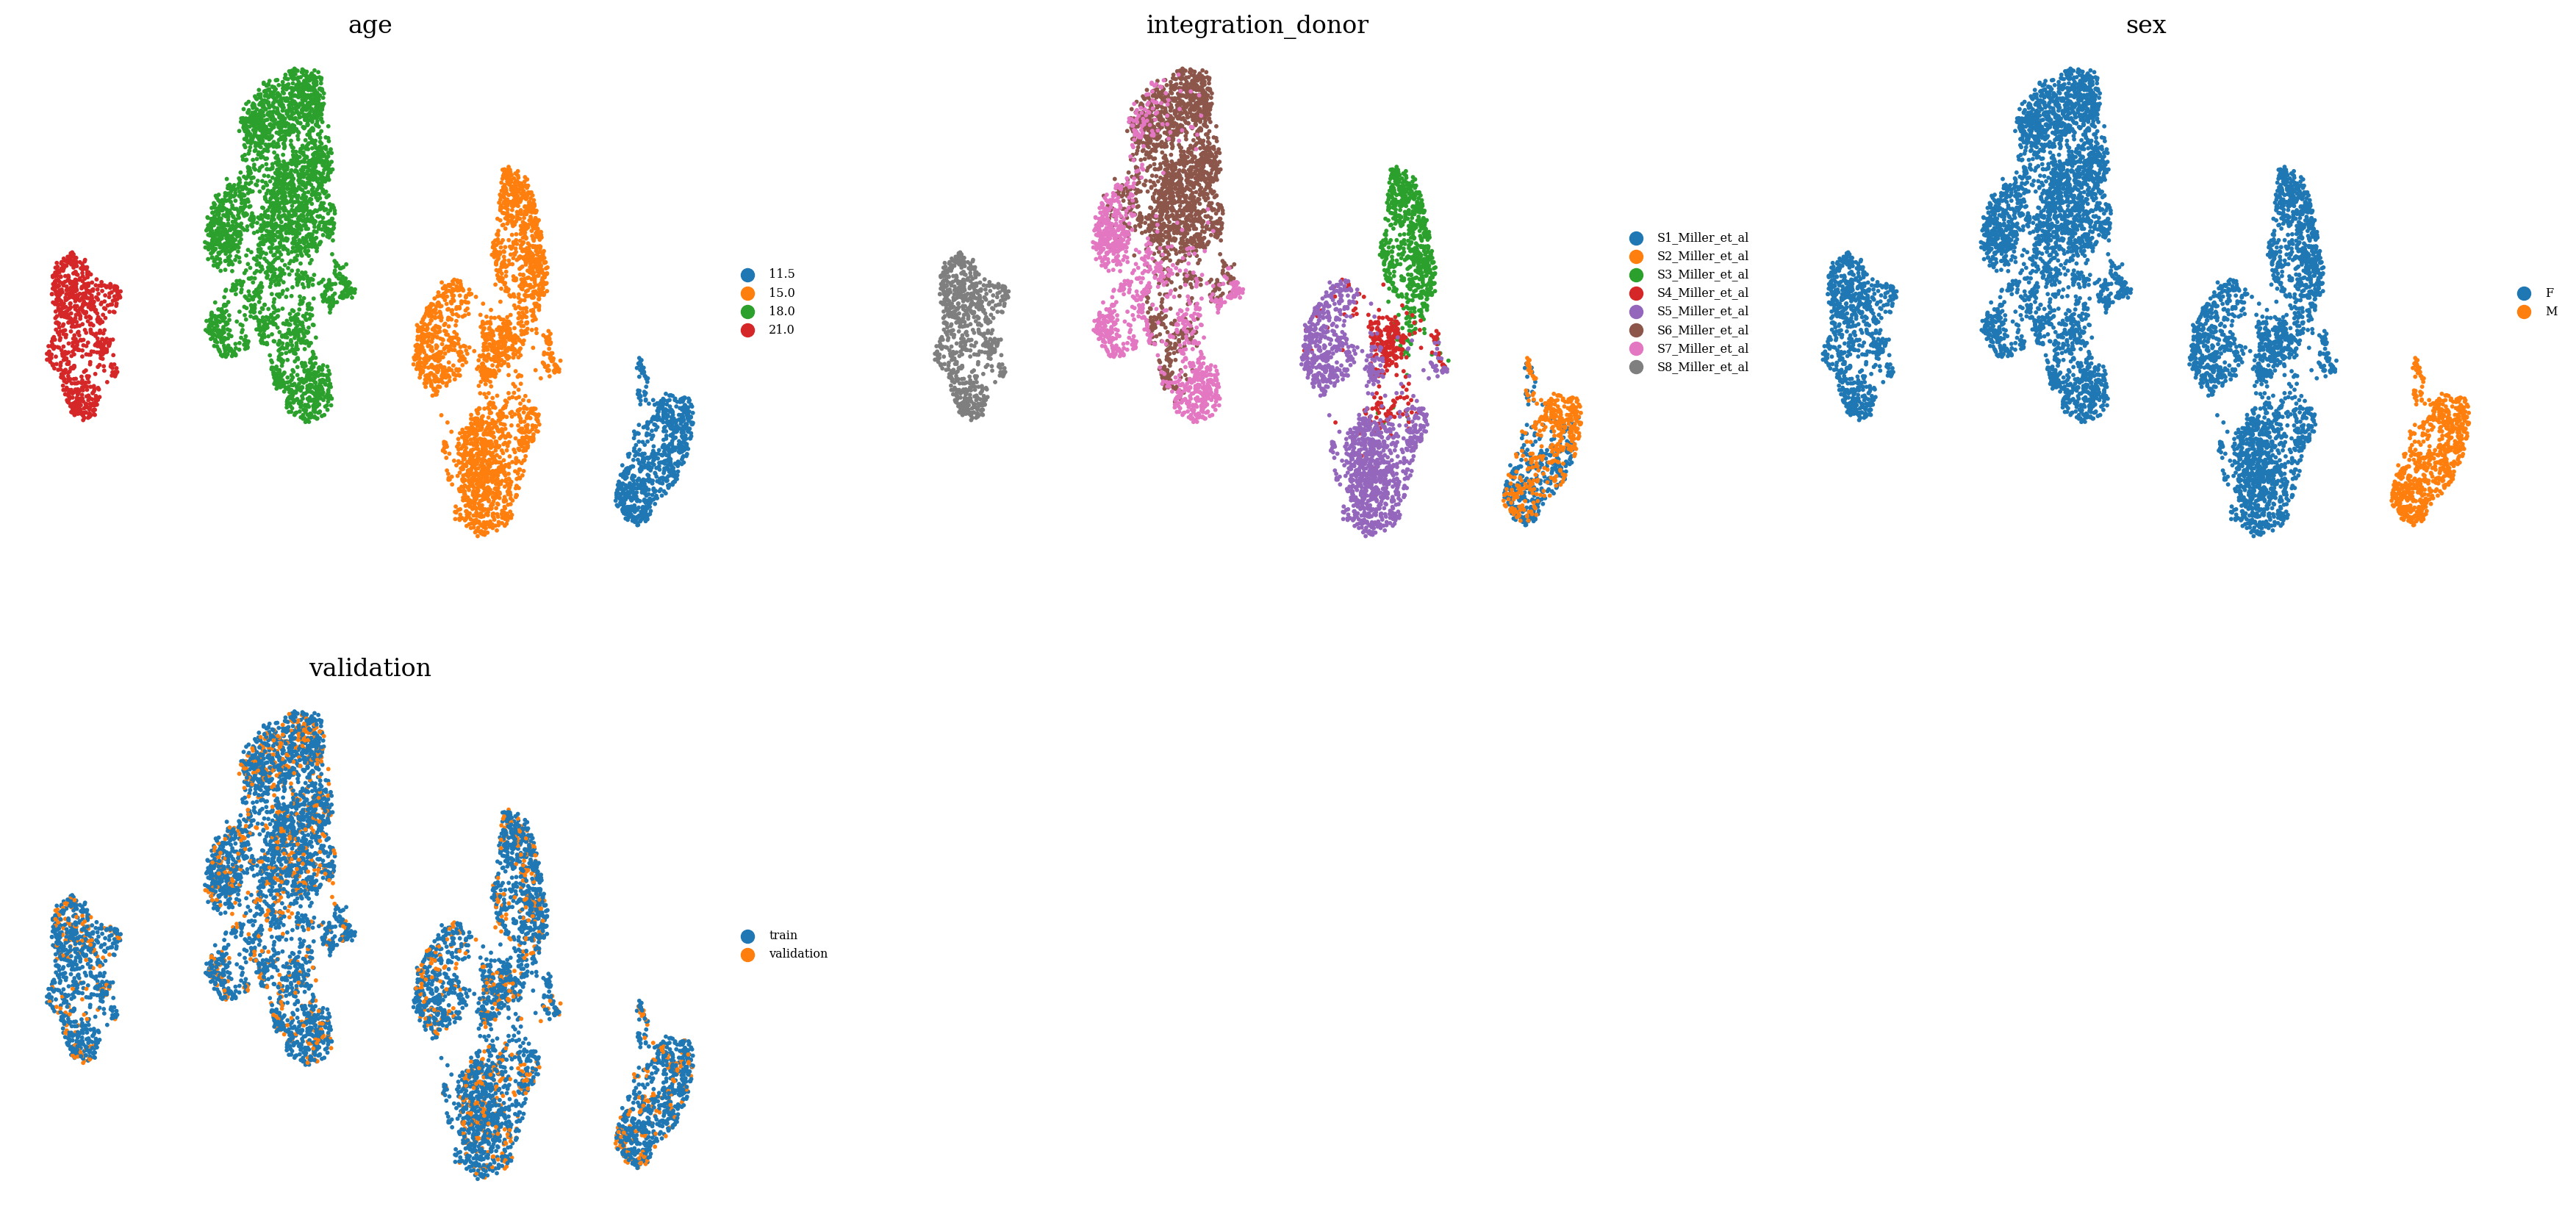

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [26]:
from tardis._disentanglementmanager import DisentanglementManager as DM

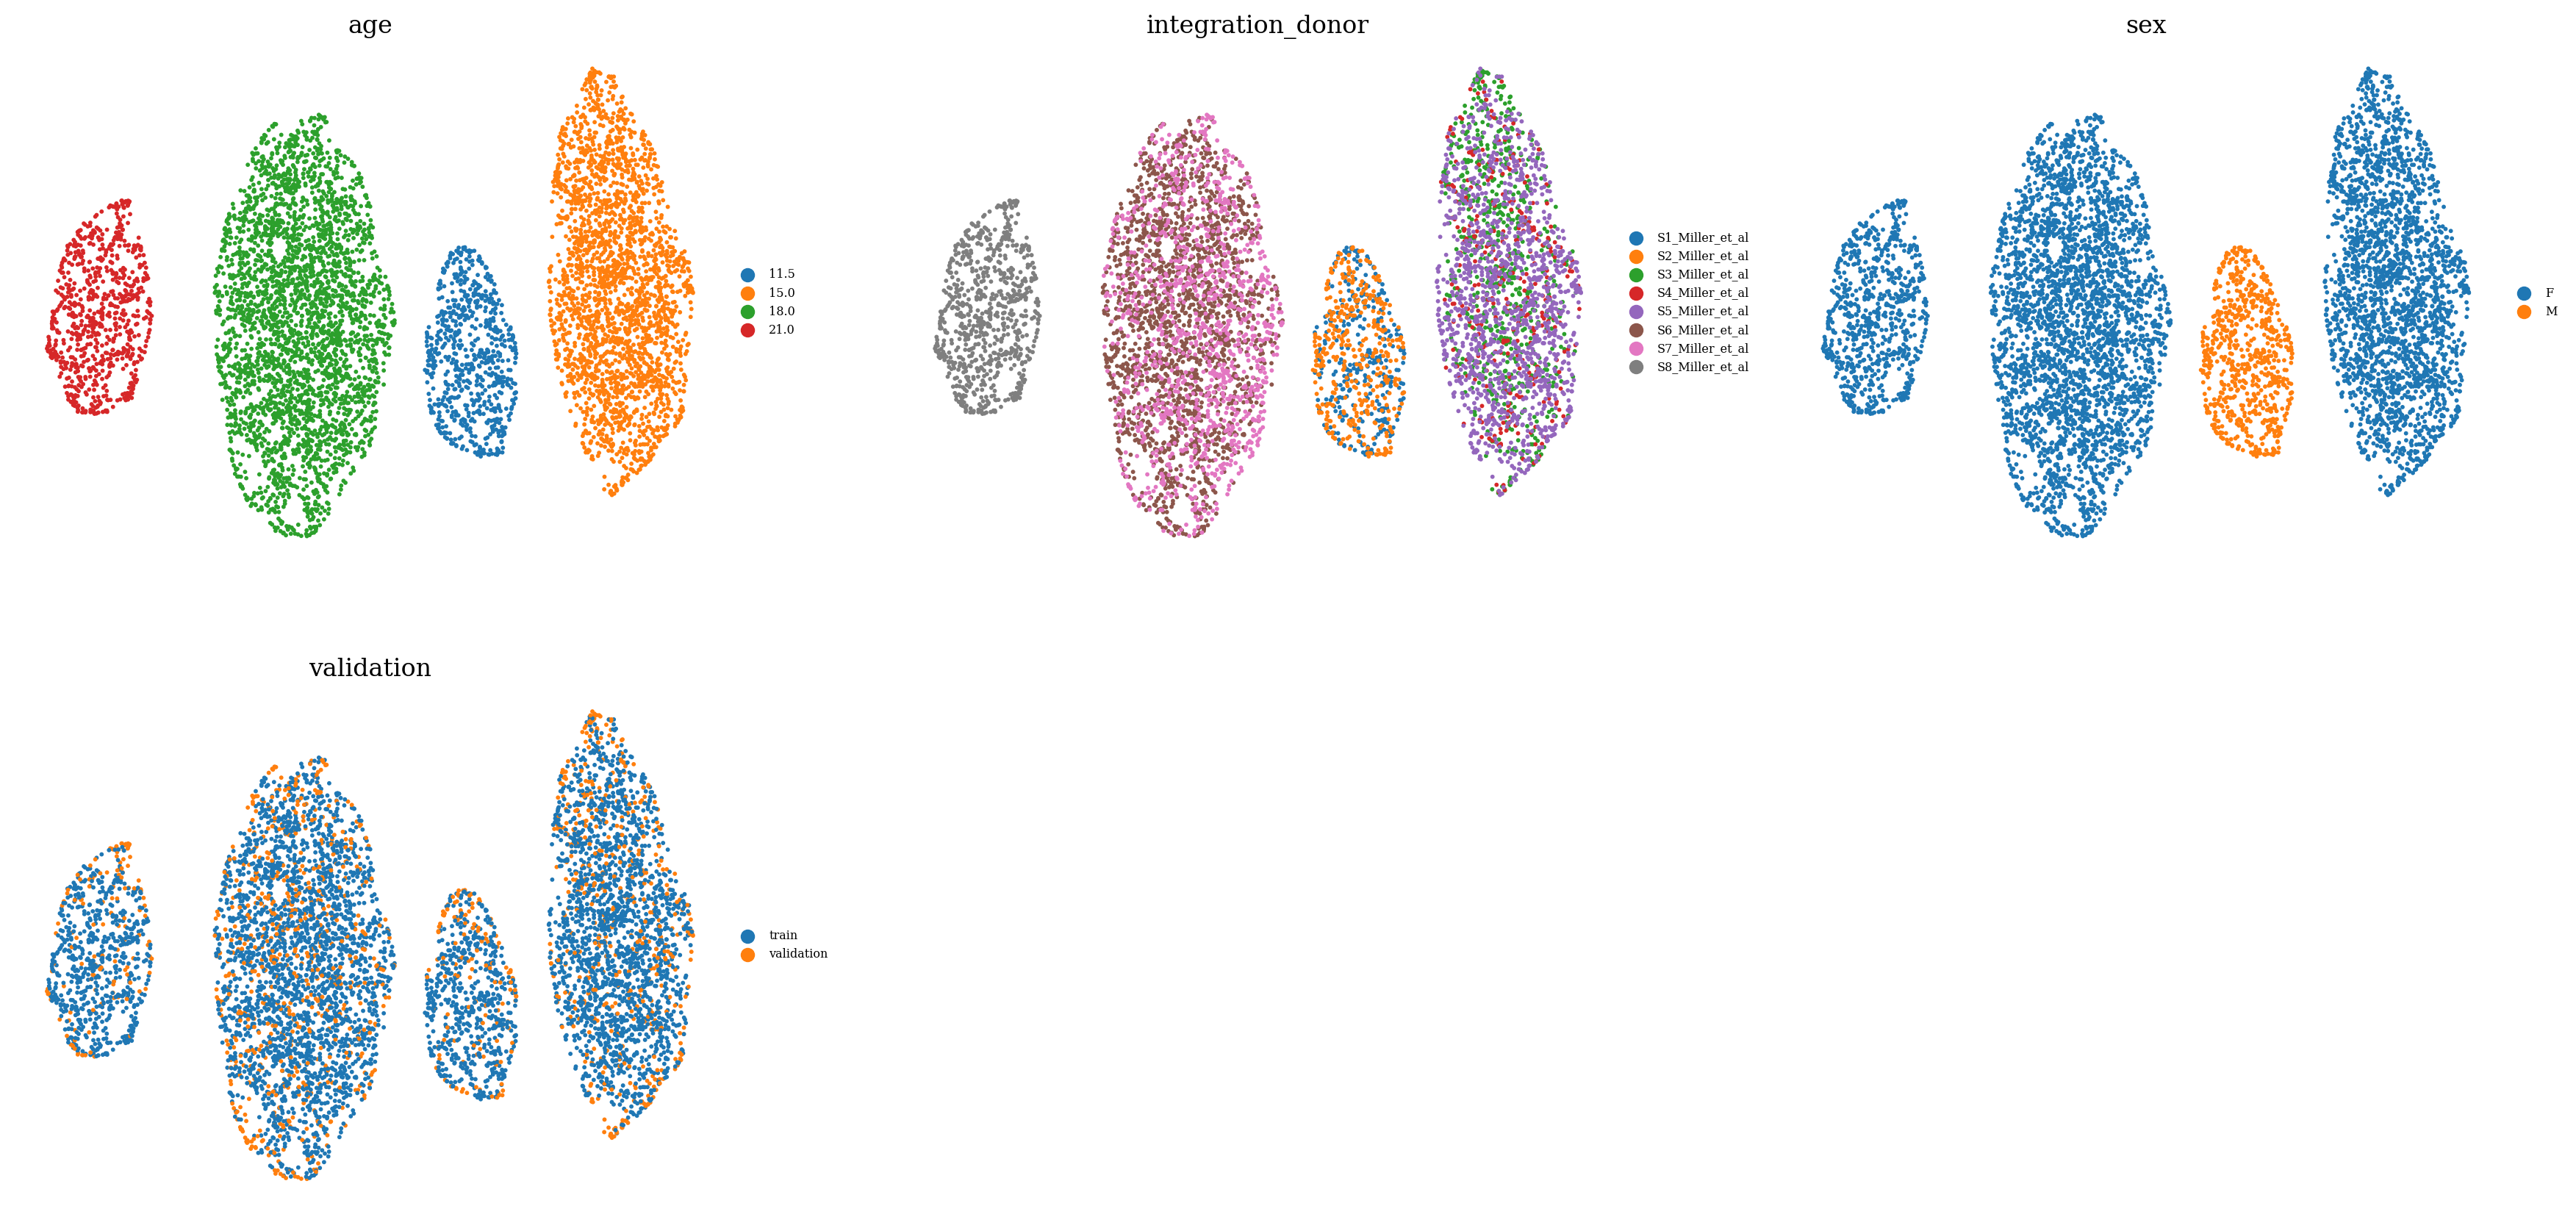

In [27]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DM.configurations.get_by_obs_key(obs_key).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["age", "integration_donor", "sex", "validation"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [28]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["age"] = adata_main.obs["age"].astype("str").astype("category")
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [29]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main, n_neighbors = 30)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


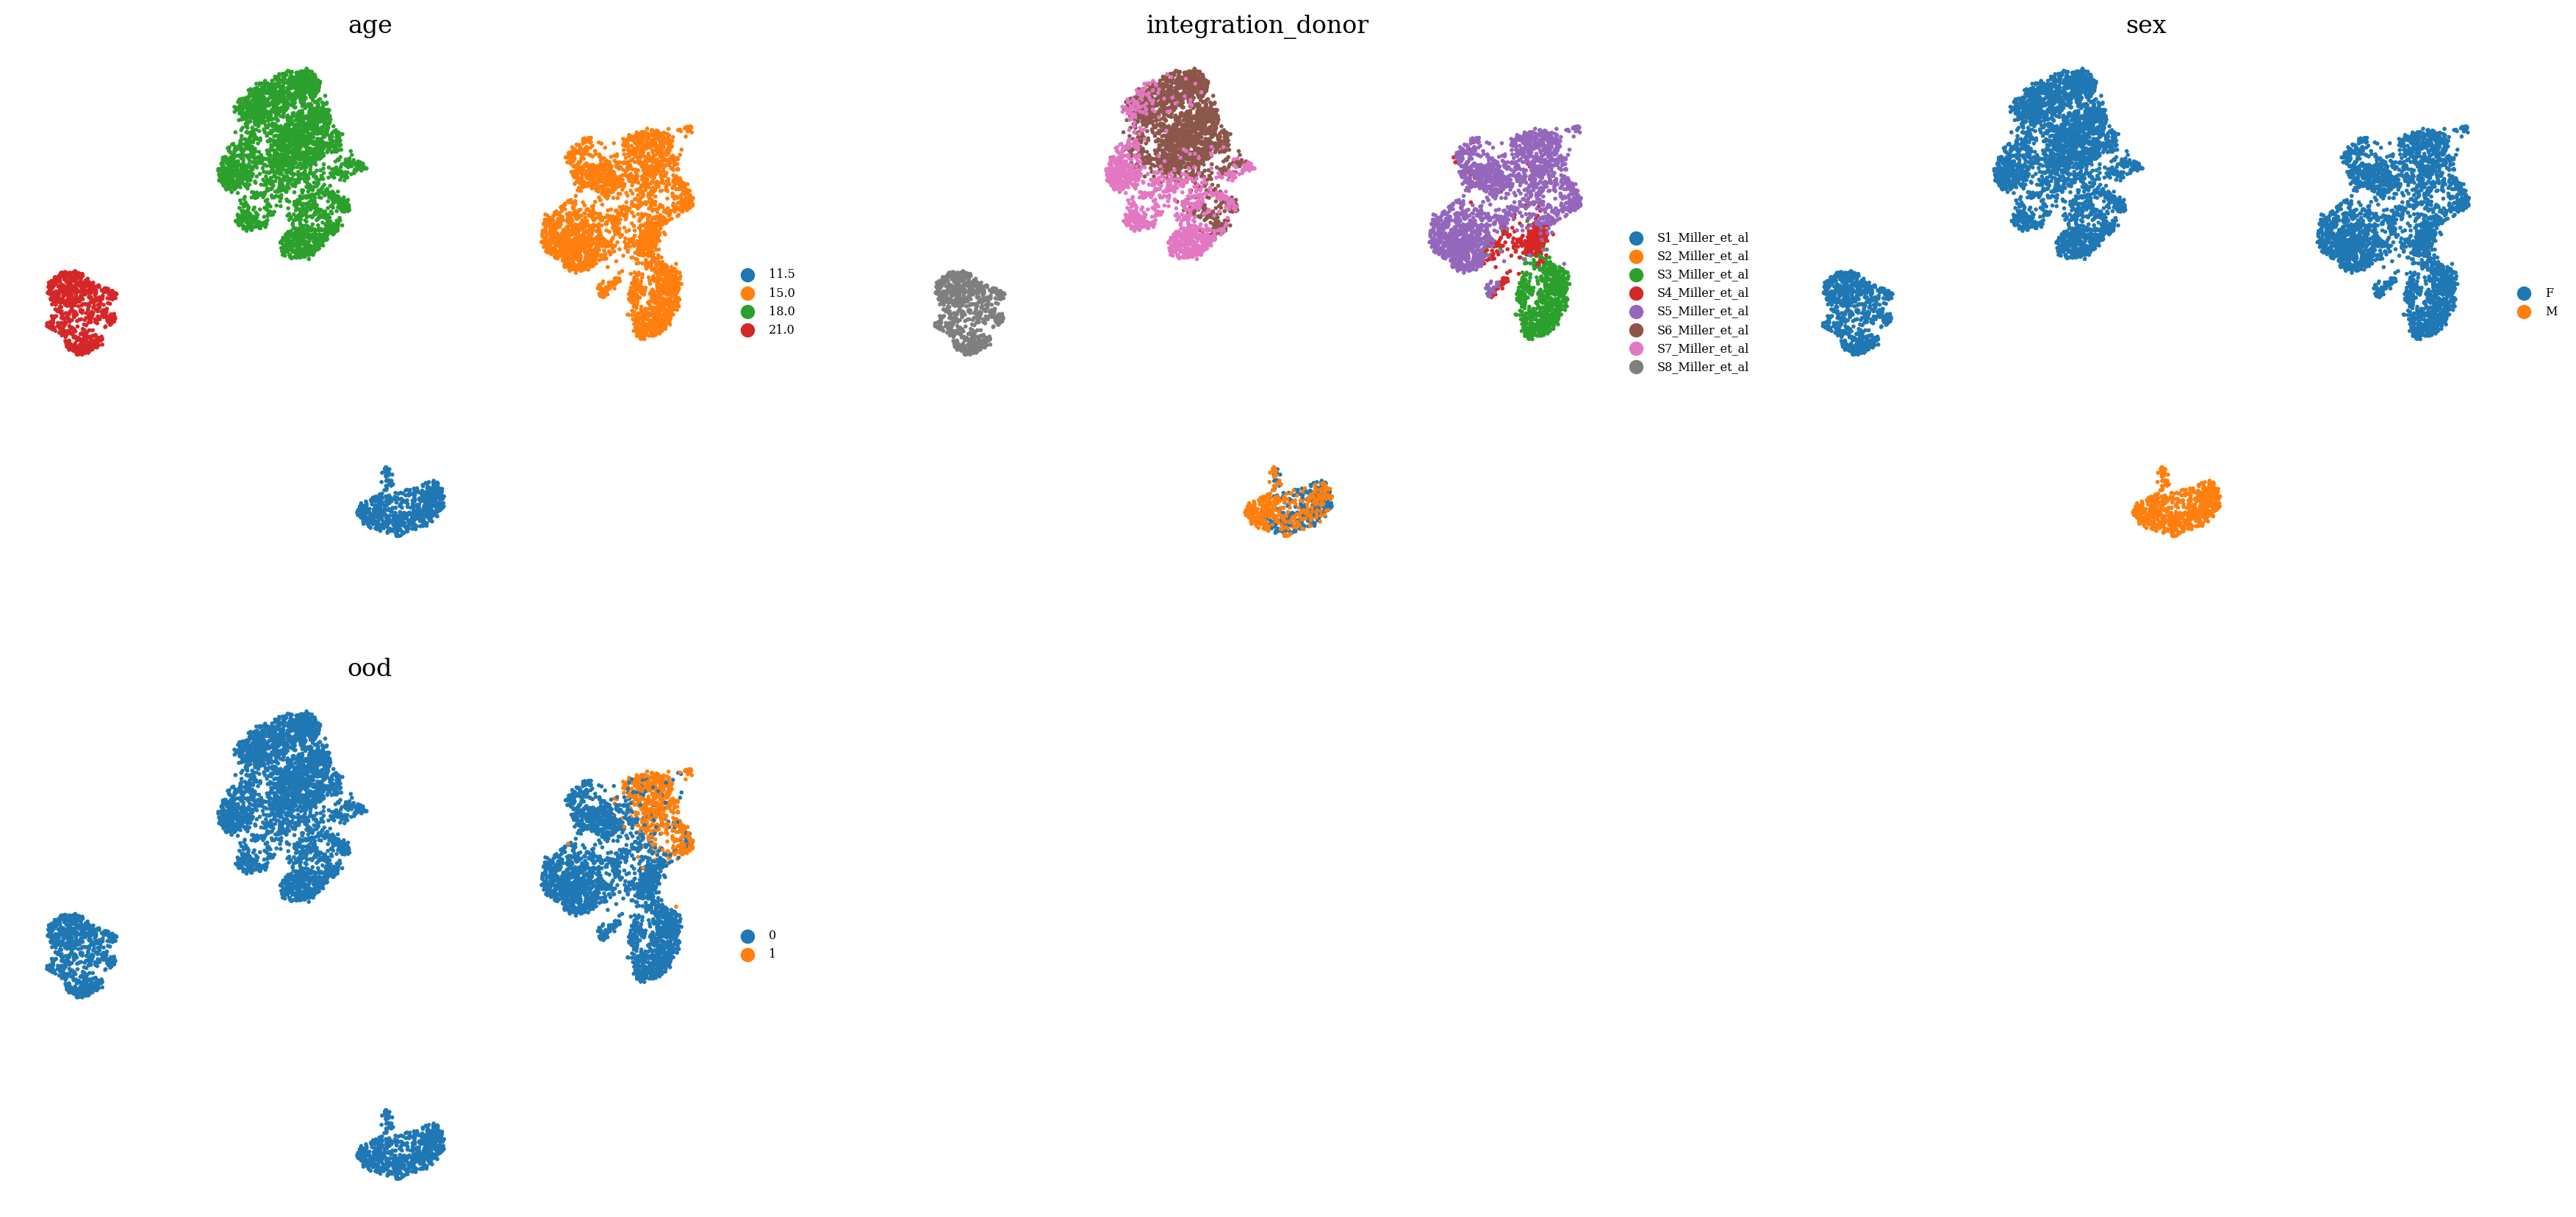

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=["age", "integration_donor", "sex", "ood"], 
        ncols=3,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )